In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os, gc
pd.set_option("display.max_rows",200)
pd.set_option("display.max_columns",50)
# os.listdir()

In [2]:
train_df = pd.read_csv('train_aox2Jxw/train.csv')
test_df  = pd.read_csv('test_bqCt9Pv.csv')
sub      = pd.read_csv('sample_submission_24jSKY6.csv')
info_df  = pd.read_excel('train_aox2Jxw/Data Dictionary.xlsx')

In [3]:
train_df.shape, test_df.shape, sub.shape, info_df.shape

((233154, 41), (112392, 40), (112392, 2), (41, 3))

In [4]:
train_df.head()

UniqueID  disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
0    420825             50578       58400  89.55         67        22807   
1    537409             47145       65550  73.23         67        22807   
2    417566             53278       61360  89.63         67        22807   
3    624493             57513       66113  88.48         67        22807   
4    539055             52378       60300  88.39         67        22807   

   manufacturer_id  Current_pincode_ID Date.of.Birth Employment.Type  \
0               45                1441      01-01-84        Salaried   
1               45                1502      31-07-85   Self employed   
2               45                1497      24-08-85   Self employed   
3               45                1501      30-12-93   Self employed   
4               45                1495      09-12-77   Self employed   

  DisbursalDate  State_ID  Employee_code_ID  MobileNo_Avl_Flag  Aadhar_flag  \
0      03-08-18         6              1998                  1            1   
1      26-09-18         6              1998                  1            1   
2      01-08-18         6              1998                  1            1   
3      26-10-18         6              1998                  1            1   
4      26-09-18         6              1998                  1            1   

   PAN_flag  VoterID_flag  Driving_flag  Passport_flag  PERFORM_CNS.SCORE  \
0         0             0             0              0                  0   
1         0             0             0              0                598   
2         0             0             0              0                  0   
3         0             0             0              0                305   
4         0             0             0              0                  0   

  PERFORM_CNS.SCORE.DESCRIPTION  PRI.NO.OF.ACCTS  PRI.ACTIVE.ACCTS  \
0   No Bureau History Available                0                 0   
1                 I-Medium Risk                1                 1   
2   No Bureau History Available                0                 0   
3              L-Very High Risk                3                 0   
4   No Bureau History Available                0                 0   

   PRI.OVERDUE.ACCTS  PRI.CURRENT.BALANCE  PRI.SANCTIONED.AMOUNT  \
0                  0                    0                      0   
1                  1                27600                  50200   
2                  0                    0                      0   
3                  0                    0                      0   
4                  0                    0                      0   

   PRI.DISBURSED.AMOUNT  SEC.NO.OF.ACCTS  SEC.ACTIVE.ACCTS  SEC.OVERDUE.ACCTS  \
0                     0                0                 0                  0   
1                 50200                0                 0                  0   
2                     0                0                 0                  0   
3                     0                0                 0                  0   
4                     0                0                 0                  0   

   SEC.CURRENT.BALANCE  SEC.SANCTIONED.AMOUNT  SEC.DISBURSED.AMOUNT  \
0                    0                      0                     0   
1                    0                      0                     0   
2                    0                      0                     0   
3                    0                      0                     0   
4                    0                      0                     0   

   PRIMARY.INSTAL.AMT  SEC.INSTAL.AMT  NEW.ACCTS.IN.LAST.SIX.MONTHS  \
0                   0               0                             0   
1                1991               0                             0   
2                   0               0                             0   
3                  31               0                             0   
4                   0               0                             0   

   D

# Only `Employment.Type` have `NaN` values

In [5]:
import warnings
warnings.filterwarnings("ignore")
train_test = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
train_test.shape

(345546, 41)

## Add flag to diffrentiate b/w train and test

In [6]:
train_test['train_flag'] = 0
train_test['train_flag'].iloc[:train_df.shape[0]] = 1
train_test.train_flag.value_counts()

1    233154
0    112392
Name: train_flag, dtype: int64

In [21]:
train_test['Date.of.Birth'].apply(lambda x: str(x)[-2:]).sort_values().unique()

array(['00', '49', '54', '55', '56', '57', '58', '59', '60', '61', '62',
       '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73',
       '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84',
       '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95',
       '96', '97', '98', '99'], dtype=object)

In [7]:
train_test['Date.of.Birth'] = train_test['Date.of.Birth'].apply(
    lambda x: str(x)[:-2]+'20'+str(x)[-2:] if str(x)[-2:] == '00' \
    else str(x)[:-2]+'19'+str(x)[-2:])
train_test['date_of_birth']  = pd.to_datetime(pd.Series(train_test['Date.of.Birth']))
train_test.drop('Date.of.Birth', axis=1, inplace=True)

In [39]:
train_test['Date.of.Birth'].apply(
    lambda x: str(x)[-7:-5]).unique()

array(['01', '07', '08', '12', '09', '06', '10', '11', '02', '04', '05',
       '03'], dtype=object)

In [40]:
# train_test['day_of_birth']   = train_test['date_of_birth'].dt.day
# train_test['month_of_birth'] = train_test['date_of_birth'].dt.month
# train_test['year_of_birth']  = train_test['date_of_birth'].dt.year

# train_test.drop(['Date.of.Birth1','Date.of.Birth'], axis=1, inplace=True)

In [8]:
train_test['DisbursalDate_new'] = pd.to_datetime(
    pd.Series(train_test['DisbursalDate'].apply(lambda x: str(x)[:-3])), 
    format="%d-%m")

train_test.DisbursalDate_new = train_test.DisbursalDate_new.apply(
    lambda dt: dt.replace(year=2018))

train_test['disbursal_week']  = train_test['DisbursalDate_new'].dt.week
train_test['disbursal_day']   = train_test['DisbursalDate_new'].dt.day
train_test['disbursal_month'] = train_test['DisbursalDate_new'].dt.month

# train_test.DisbursalDate_new.unique()

In [9]:
id_cols = ['Current_pincode_ID', 'State_ID','Employee_code_ID', 
           'supplier_id', 'manufacturer_id', 'branch_id']
# train_test[id_cols]
# train_test.
print(train_df[id_cols].apply(lambda x: pd.Series(x).value_counts().shape[0]))
print("="*30)
print(test_df[id_cols].apply(lambda x: pd.Series(x).value_counts().shape[0]))
print("="*30)
print(train_test[id_cols].apply(lambda x: pd.Series(x).value_counts().shape[0]))


Current_pincode_ID    6698
State_ID                22
Employee_code_ID      3270
supplier_id           2953
manufacturer_id         11
branch_id               82
dtype: int64
Current_pincode_ID    6202
State_ID                22
Employee_code_ID      3143
supplier_id           2863
manufacturer_id         11
branch_id               82
dtype: int64
Current_pincode_ID    7096
State_ID                22
Employee_code_ID      3398
supplier_id           3089
manufacturer_id         12
branch_id               82
dtype: int64


## Drop Employee-Id, it is different for both train and test, for example, it represent the student at the school, with same roll-no

In [18]:
tr_id = train_df.UniqueID.unique()
ts_id = test_df.UniqueID.unique()

print("unique's ids: ",tr_id.shape, ts_id.shape)
min(tr_id), max(tr_id), min(ts_id), max(ts_id), len(set(tr_id).intersection(set(ts_id)))

unique's ids:  (233154,) (112392,)


(417428, 671084, 654115, 769909, 0)

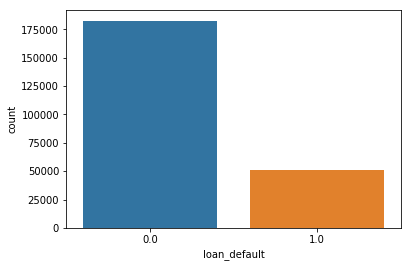

In [43]:
sns.countplot(train_test.loan_default)

In [44]:
info_df

Variable Name  \
0                              UniqueID   
1                          loan_default   
2                      disbursed_amount   
3                            asset_cost   
4                                   ltv   
5                             branch_id   
6                           supplier_id   
7                       manufacturer_id   
8                       Current_pincode   
9                         Date.of.Birth   
10                      Employment.Type   
11                        DisbursalDate   
12                             State_ID   
13                     Employee_code_ID   
14                    MobileNo_Avl_Flag   
15                          Aadhar_flag   
16                             PAN_flag   
17                         VoterID_flag   
18                         Driving_flag   
19                        Passport_flag   
20                    PERFORM_CNS.SCORE   
21        PERFORM_CNS.SCORE.DESCRIPTION   
22                      PRI.NO.OF.ACCTS   
23                     PRI.ACTIVE.ACCTS   
24                    PRI.OVERDUE.ACCTS   
25                  PRI.CURRENT.BALANCE   
26                PRI.SANCTIONED.AMOUNT   
27                 PRI.DISBURSED.AMOUNT   
28                      SEC.NO.OF.ACCTS   
29                     SEC.ACTIVE.ACCTS   
30                    SEC.OVERDUE.ACCTS   
31                  SEC.CURRENT.BALANCE   
32                SEC.SANCTIONED.AMOUNT   
33                 SEC.DISBURSED.AMOUNT   
34                   PRIMARY.INSTAL.AMT   
35                       SEC.INSTAL.AMT   
36         NEW.ACCTS.IN.LAST.SIX.MONTHS   
37  DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS   
38                     AVERAGE.ACCT.AGE   
39                CREDIT.HISTORY.LENGTH   
40                      NO.OF_INQUIRIES   

                                          Description  \
0                            Identifier for customers   
1        Payment default in the first EMI on due date   
2                            Amount of Loan disbursed   
3                                   Cost of the Asset   
4                          Loan to Value of the asset   
5                 Branch where the loan was disbursed   
6         Vehicle Dealer where the loan was disbursed   
7         Vehicle manufacturer(Hero, Honda, TVS etc.)   
8                     Current pincode of the customer   
9                       Date of birth of the customer   
10  Employment Type of the customer (Salaried/Self...   
11                               Date of disbursement   
12                              State of disbursement   
13  Employee of the organization who logged the di...   
14  if Mobile no. was shared by the customer then ...   
15  if aadhar was shared by the customer then flag...   
16  if pan was shared by the customer then flagged...   
17  if voter  was shared by the customer then flag...   
18  if DL was shared by the customer then flagged ...   
19  if passport was shared by the customer then fl...   
20                                       Bureau Score   
21                           Bureau score description   
22  count of total loans taken by the customer at ...   
23  count of active loans taken by the customer at...   
24  count of default accounts at the time of disbu...   
25  total Principal outstanding amount of the acti...   
26  total amount that was sanctioned for all the l...   
27  total amount that was disbursed for all the lo...   
28  count of total loans taken by the customer at ...   
29  count of active loans taken by the customer at...   
30  count of default accounts at the time of disbu...   
31  total Principal outstanding amount of the acti...   
32  total amount that was sanctioned for all the l...   
33  total amount that was disbursed for all the lo...   
34                     EMI Amount of the primary loan   
35                   EMI Amount of the secondary loan   
36  New loans taken by the customer in last 6 mont...   
37               Loans defaulted in the last 6 months

In [24]:
train_df[['CREDIT.HISTORY.LENGTH','loan_default']].groupby(['CREDIT.HISTORY.LENGTH','loan_default']).size().unstack()

loan_default                 0        1
CREDIT.HISTORY.LENGTH                  
0yrs 0mon              91555.0  27572.0
0yrs 10mon              1912.0    455.0
0yrs 11mon              2083.0    544.0
0yrs 1mon               1393.0    460.0
0yrs 2mon               1545.0    432.0
0yrs 3mon               1570.0    412.0
0yrs 4mon               1683.0    460.0
0yrs 5mon               1644.0    442.0
0yrs 6mon               3761.0   1000.0
0yrs 7mon               3163.0    854.0
0yrs 8mon               1948.0    511.0
0yrs 9mon               1917.0    486.0
10yrs 0mon                83.0     13.0
10yrs 10mon               93.0     18.0
10yrs 11mon              115.0     16.0
10yrs 1mon                79.0     13.0
10yrs 2mon                87.0     13.0
10yrs 3mon                81.0     15.0
10yrs 4mon                91.0     11.0
10yrs 5mon                74.0      9.0
10yrs 6mon                76.0     13.0
10yrs 7mon                79.0     19.0
10yrs 8mon                83.0     13.0
10yrs 9mon                75.0     17.0
11yrs 0mon                94.0     11.0
11yrs 10mon               76.0     13.0
11yrs 11mon               64.0     14.0
11yrs 1mon                99.0     17.0
11yrs 2mon                92.0     13.0
11yrs 3mon                96.0     16.0
...                        ...      ...
7yrs 4mon                122.0     21.0
7yrs 5mon                117.0     27.0
7yrs 6mon                126.0     24.0
7yrs 7mon                129.0     33.0
7yrs 8mon                113.0     33.0
7yrs 9mon                129.0     20.0
8yrs 0mon                134.0     25.0
8yrs 10mon                59.0     16.0
8yrs 11mon                80.0     17.0
8yrs 1mon                127.0     22.0
8yrs 2mon                111.0     17.0
8yrs 3mon                 86.0     25.0
8yrs 4mon                100.0     17.0
8yrs 5mon                105.0     20.0
8yrs 6mon                104.0     16.0
8yrs 7mon                 99.0     22.0
8yrs 8mon                 86.0     24.0
8yrs 9mon                 99.0     14.0
9yrs 0mon                 89.0     11.0
9yrs 10mon                65.0     16.0
9yrs 11mon                88.0     17.0
9yrs 1mon                 87.0     15.0
9yrs 2mon                 66.0     21.0
9yrs 3mon                 77.0     13.0
9yrs 4mon                 73.0     15.0
9yrs 5mon                 60.0     12.0
9yrs 6mon                 66.0     15.0
9yrs 7mon                 80.0     16.0
9yrs 8mon                 75.0     12.0
9yrs 9mon                 68.0     12.0

[294 rows x 2 columns]

In [8]:
train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             2
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION              20
PRI.NO.OF.ACCTS                   

In [10]:
train_test['credit_hist_year'] = train_test['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[0][:-3])
train_test['credit_hist_month']= train_test['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[1][:-3])

train_test['credit_hist_year'] = train_test['credit_hist_year'].astype('int')
train_test['credit_hist_month']= train_test['credit_hist_month'].astype('int')

train_test['credit_hist_total_month']= train_test['credit_hist_month'] + \
                                        train_test['credit_hist_year']*12

train_test['loan_tenure_year'] = train_test['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[0][:-3])
train_test['loan_tenure_month']= train_test['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[1][:-3])

train_test['loan_tenure_year'] = train_test['loan_tenure_year'].astype('int')
train_test['loan_tenure_month']= train_test['loan_tenure_month'].astype('int')

train_test['loan_tenure_total_month']= train_test['loan_tenure_month'] + \
                                        train_test['loan_tenure_year']*12

# train_test.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace=True)


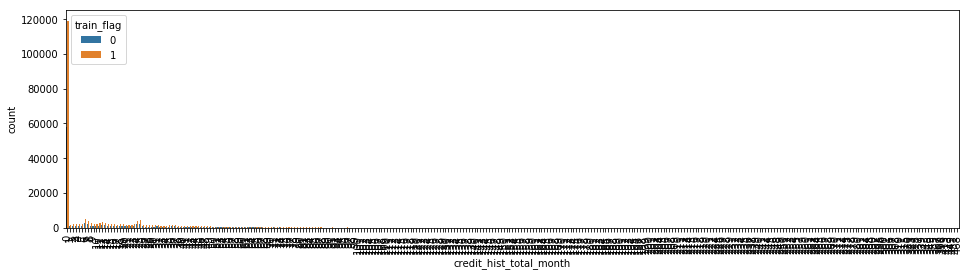

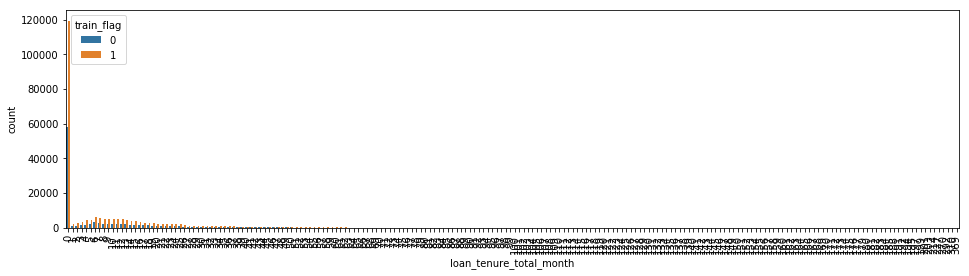

In [15]:
plt.figure(figsize=(16,4))
sns.countplot(x='credit_hist_total_month', hue='train_flag', data=train_test)
_ = plt.xticks(rotation='vertical')

plt.figure(figsize=(16,4))
sns.countplot(x='loan_tenure_total_month', hue='train_flag', data=train_test)
_ = plt.xticks(rotation='vertical')


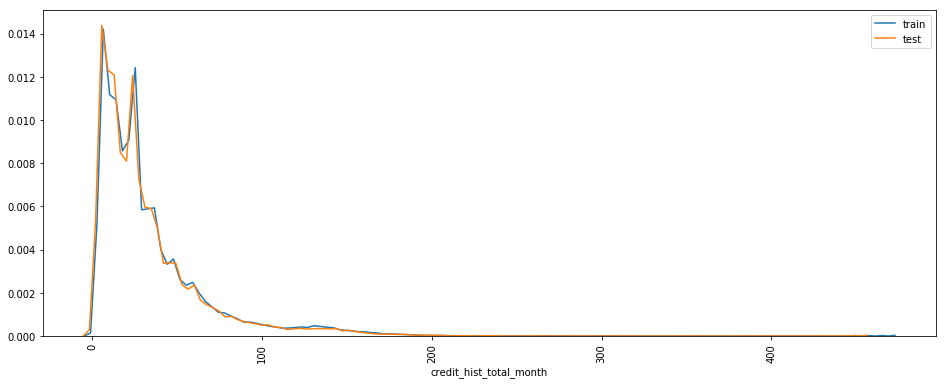

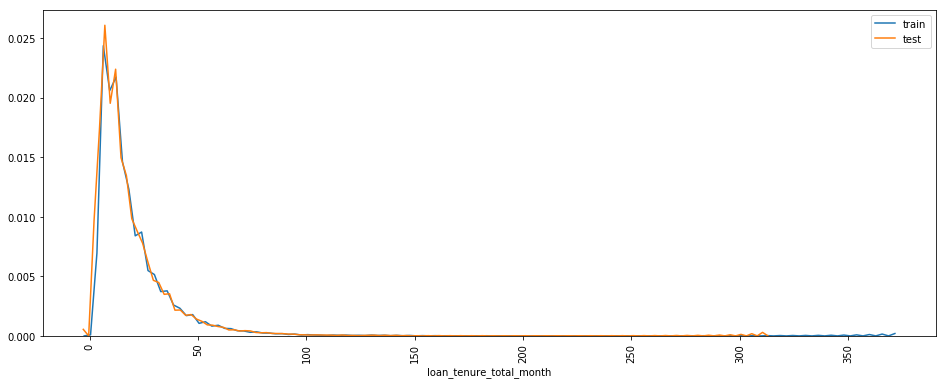

In [21]:
def distplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,6))
    sns.distplot(df[df[flag_col] == 1][col], hist=False, label='train')
    sns.distplot(df[df[flag_col] == 0][col], hist=False, label='test')
    _ = plt.xticks(rotation='vertical')
    
distplot_it(train_test, 'train_flag', 'credit_hist_total_month')
distplot_it(train_test, 'train_flag', 'loan_tenure_total_month')

(0, 6000)

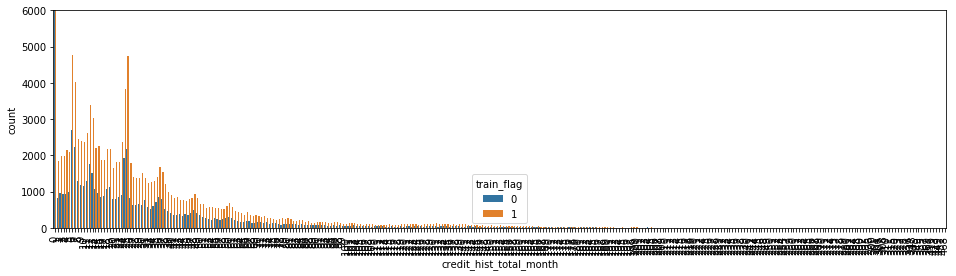

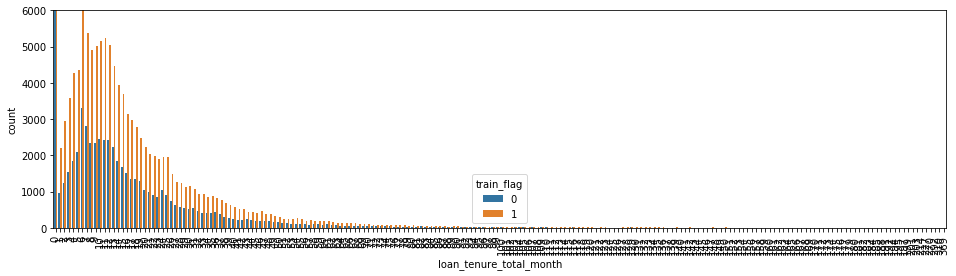

In [26]:
plt.figure(figsize=(16,4))
sns.countplot(x='credit_hist_total_month', hue='train_flag', data=train_test)
_ = plt.xticks(rotation='vertical')
plt.ylim([0,6000])
plt.figure(figsize=(16,4))
sns.countplot(x='loan_tenure_total_month', hue='train_flag', data=train_test)
_ = plt.xticks(rotation='vertical')
plt.ylim([0,6000])

In [27]:
train_test.credit_hist_total_month.unique().shape, \
train_test.loan_tenure_total_month.unique().shape

((307,), (200,))

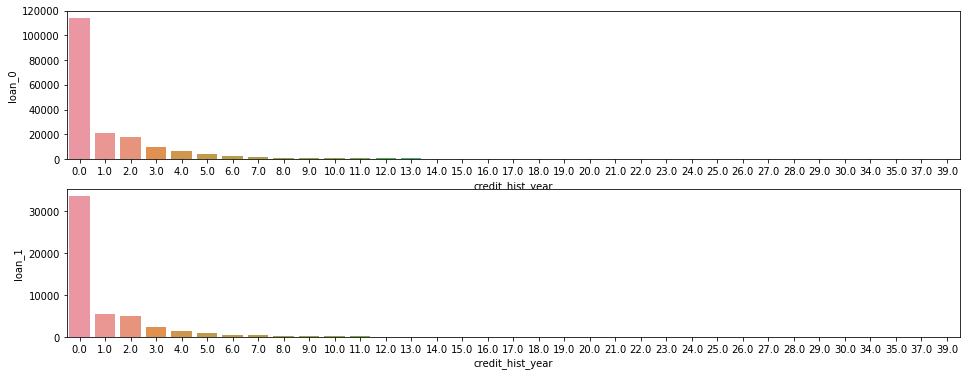

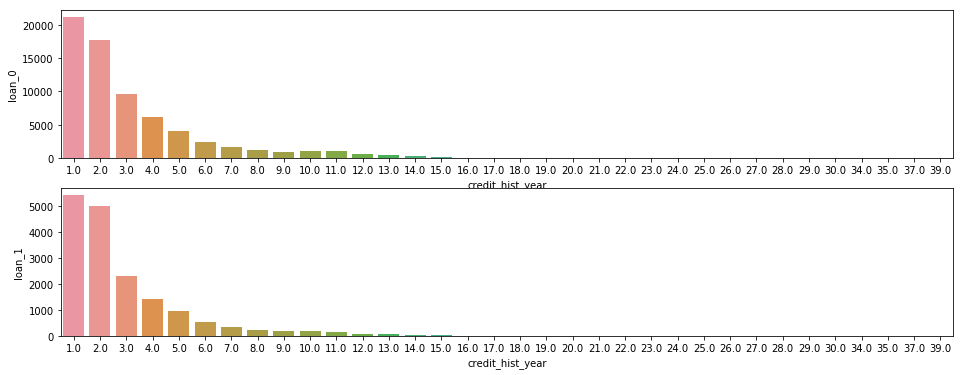

In [44]:
# train_df[['CREDIT.HISTORY.LENGTH','loan_default']].groupby(['CREDIT.HISTORY.LENGTH','loan_default']).size().unstack()
credit_gps = train_test.groupby(['credit_hist_year','loan_default']).size().unstack()
credit_gps.columns = ['loan_0', 'loan_1']
credit_gps['credit_hist_year'] = credit_gps.index
credit_gps.reset_index(drop=True, inplace=True)
credit_gps = credit_gps.astype('float')
credit_gps = credit_gps.sort_values(by='credit_hist_year', ascending=False)

fig, ax = plt.subplots(2,1,figsize=(16,6))
sns.barplot(x='credit_hist_year',y="loan_0", data=credit_gps, ax=ax[0])
sns.barplot(x='credit_hist_year',y="loan_1", data=credit_gps, ax=ax[1])

credit_gps1 = credit_gps[credit_gps != 0]
fig, ax = plt.subplots(2,1,figsize=(16,6))
sns.barplot(x='credit_hist_year',y="loan_0", data=credit_gps1, ax=ax[0])
sns.barplot(x='credit_hist_year',y="loan_1", data=credit_gps1, ax=ax[1])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

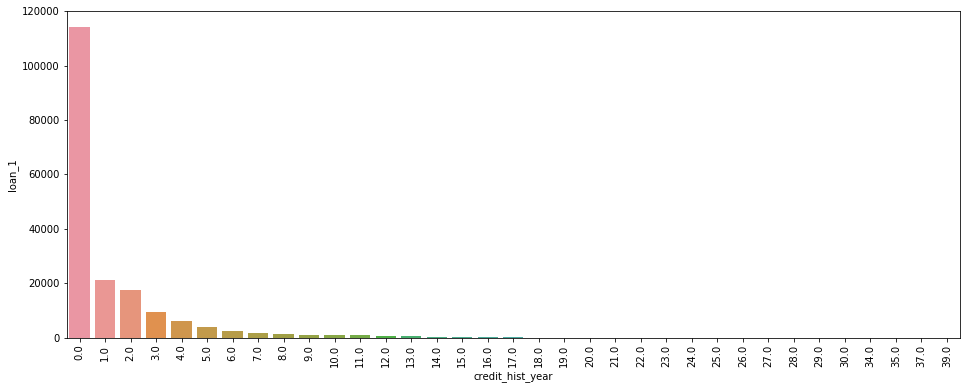

In [43]:
plt.figure(figsize=(16,6))
sns.barplot(x='credit_hist_year',y="loan_0", data=credit_gps)
sns.barplot(x='credit_hist_year',y="loan_1", data=credit_gps)
plt.xticks(rotation='vertical')

In [11]:
# train_df['disbursal_date'] = pd.to_datetime(train_df['DisbursalDate'])
# test_df['disbursal_date']  = pd.to_datetime(test_df['DisbursalDate'])

# train_df['day_of_disbursal']   = train_df['disbursal_date'].dt.day
# train_df['month_of_disbursal'] = train_df['disbursal_date'].dt.month
# train_df['year_of_disbursal']  = train_df['disbursal_date'].dt.year

# test_df['day_of_disbursal']   = test_df['disbursal_date'].dt.day
# test_df['month_of_disbursal'] = test_df['disbursal_date'].dt.month
# test_df['year_of_disbursal']  = test_df['disbursal_date'].dt.year

# train_df.drop(['disbursal_date','DisbursalDate'], axis=1, inplace=True)
# test_df.drop(['disbursal_date','DisbursalDate'], axis=1, inplace=True)


## Very suspicious various `train_df['PERFORM_CNS.SCORE.DESCRIPTION']`

In [47]:
train_test['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                174843
C-Very Low Risk                                             23870
A-Very Low Risk                                             21683
D-Very Low Risk                                             16472
B-Very Low Risk                                             13696
M-Very High Risk                                            12808
F-Low Risk                                                  12176
K-High Risk                                                 12141
H-Medium Risk                                               10142
E-Low Risk                                                   8393
I-Medium Risk                                                8260
G-Low Risk                                                   5795
J-High Risk                                                  5526
Not Scored: Sufficient History Not Available                 5025
Not Scored: Not Enough Info available on the customer        4940
Not Scored

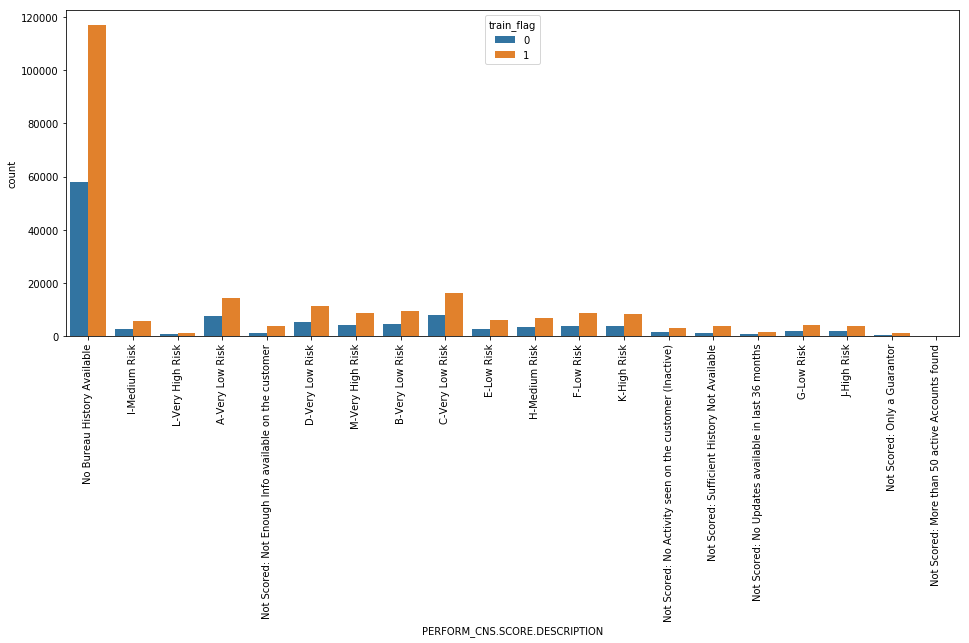

In [28]:
plt.figure(figsize=(16,6))
sns.countplot(x='PERFORM_CNS.SCORE.DESCRIPTION', hue='train_flag', 
              data=train_test)#, labels=['test','train'])
_ = plt.xticks(rotation='vertical')

In [29]:
# train_df.groupby(['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE'])['PERFORM_CNS.SCORE'].mean()

In [11]:
# bureau description and corresponding score
mapping = {
        'No Bureau History Available'                            :'not_enough_info',# 00
        'Not Scored: More than 50 active Accounts found'         :'not_enough_info',# 11
        'Not Scored: No Activity seen on the customer (Inactive)':'not_enough_info',# 16
        'Not Scored: No Updates available in last 36 months'     :'not_enough_info',# 18 
        'Not Scored: Not Enough Info available on the customer'  :'not_enough_info',# 17
        'Not Scored: Only a Guarantor'                           :'not_enough_info',# 14
        'Not Scored: Sufficient History Not Available'           :'not_enough_info' # 15
       }

train_test['Bureau_desc'] = train_test['PERFORM_CNS.SCORE.DESCRIPTION'].replace(mapping)

use_index = train_test[['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE']][
    train_test['Bureau_desc'] == 'not_enough_info']['PERFORM_CNS.SCORE'].index
train_test['bureau_score'] = train_test['PERFORM_CNS.SCORE']
train_test.loc[use_index,'bureau_score'] = 0


train_test.drop(['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE'], 
                axis=1, inplace=True)


In [31]:
train_test.bureau_score.value_counts()

0      192802
738     13044
300     12808
825     11833
763      4560
708      3170
737      3024
836      2831
749      2019
710      1652
681      1529
832      1491
726      1487
706      1483
680      1429
774      1365
615      1295
758      1210
783      1202
657      1120
719       977
771       964
709       952
679       920
845       806
707       804
653       792
694       762
728       739
753       739
830       732
597       689
640       660
785       642
599       640
762       622
743       615
651       569
627       563
810       561
624       558
585       558
792       548
654       539
819       531
721       519
630       518
818       516
572       512
723       509
659       495
824       487
643       474
625       446
705       440
667       440
670       439
628       430
740       428
684       427
698       425
571       423
626       415
646       411
598       403
637       402
650       400
648       396
623       393
583       390
635       389
815   

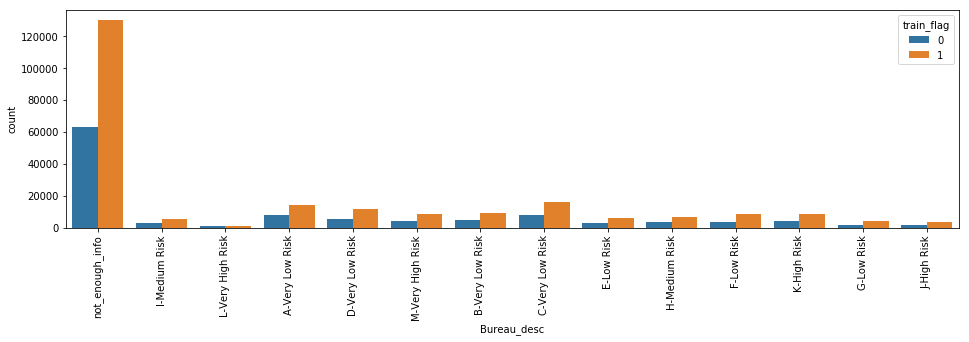

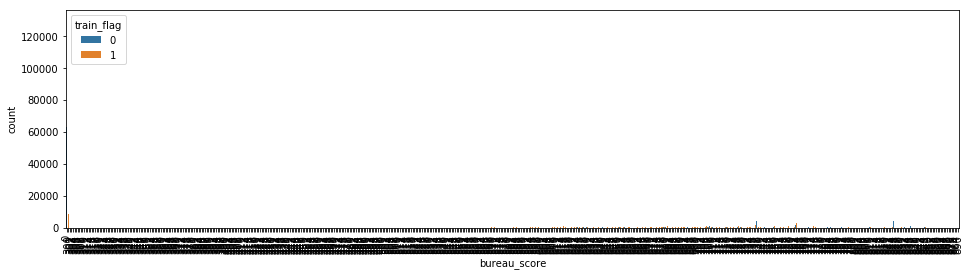

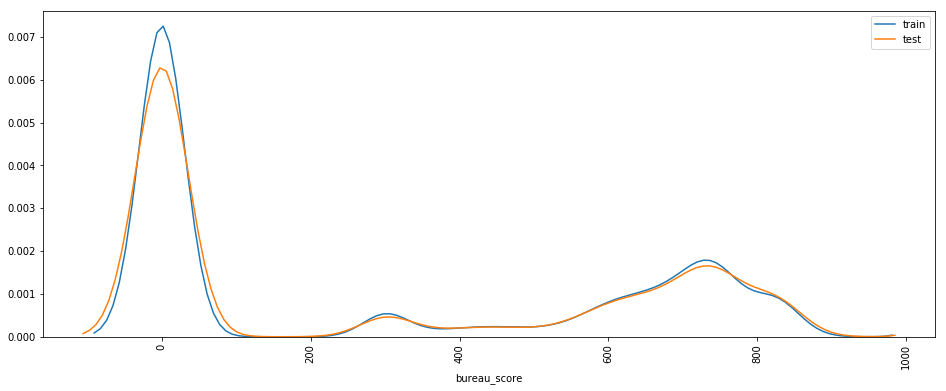

In [32]:
plt.figure(figsize=(16,4))
sns.countplot(x='Bureau_desc', hue='train_flag', 
              data=train_test)
_ = plt.xticks(rotation='vertical')

plt.figure(figsize=(16,4))
sns.countplot(x='bureau_score', hue='train_flag', 
              data=train_test)
_ = plt.xticks(rotation='vertical')

# plt.figure(figsize=(16,6))
# sns.distplot(train_test[train_test['train_flag'] == 1]['bureau_score'], hist=False, rug=True)
# sns.distplot(train_test[train_test['train_flag'] == 0]['bureau_score'], hist=False, rug=True)
# # sns.countplot(x='bureau_score', hue='train_flag', data=train_test)
# _ = plt.xticks(rotation='vertical')

# distplot_it(train_test, 'train_flag', 'Bureau_desc')
distplot_it(train_test, 'train_flag', 'bureau_score')

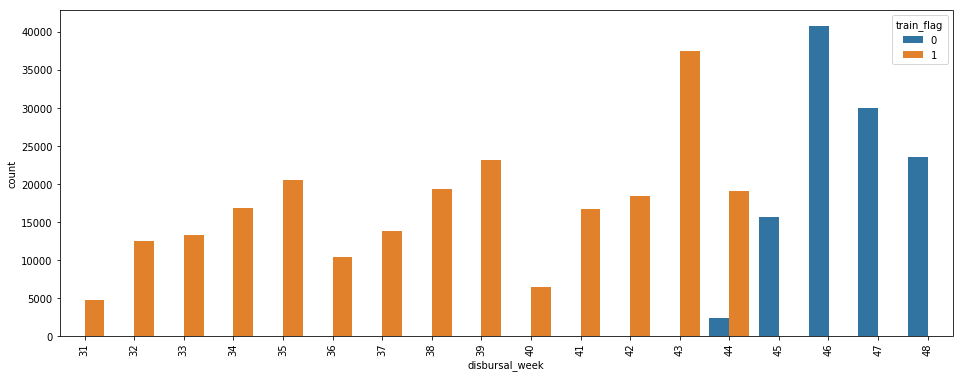

In [33]:
plt.figure(figsize=(16,6))
sns.countplot(x='disbursal_week', hue='train_flag', 
              data=train_test)#, labels=['test','train'])
_ = plt.xticks(rotation='vertical')


In [81]:
train_test.columns

Index(['AVERAGE.ACCT.AGE', 'Aadhar_flag', 'CREDIT.HISTORY.LENGTH',
       'Current_pincode_ID', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'Date.of.Birth', 'DisbursalDate', 'Driving_flag', 'Employee_code_ID',
       'Employment.Type', 'MobileNo_Avl_Flag', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'PAN_flag', 'PRI.ACTIVE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.SANCTIONED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'Passport_flag', 'SEC.ACTIVE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'SEC.INSTAL.AMT', 'SEC.NO.OF.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT', 'State_ID', 'UniqueID',
       'VoterID_flag', 'asset_cost', 'branch_id', 'disbursed_amount',
       'loan_default', 'ltv', 'manufacturer_id', 'supplier_id',
       'DisbursalDate_new', 'disbursal_week', 'disbursal_day',
       'disbursal_month', 'credit_hist_year', 'credit_hist_month',
       'loan_tenure_year', 

In [89]:
train_test.iloc[:train_df.shape[0],:].groupby(['disbursal_week'])['ltv'].size()

disbursal_week
31     4827
32    12549
33    13301
34    16847
35    20478
36    10423
37    13855
38    19342
39    23168
40     6503
41    16786
42    18494
43    37529
44    19052
Name: ltv, dtype: int64

In [95]:
train_test.groupby(['disbursal_week'])['ltv'].size()

disbursal_week
31     4827
32    12549
33    13301
34    16847
35    20478
36    10423
37    13855
38    19342
39    23168
40     6503
41    16786
42    18494
43    37529
44    21505
45    15693
46    40810
47    29929
48    23507
dtype: int64

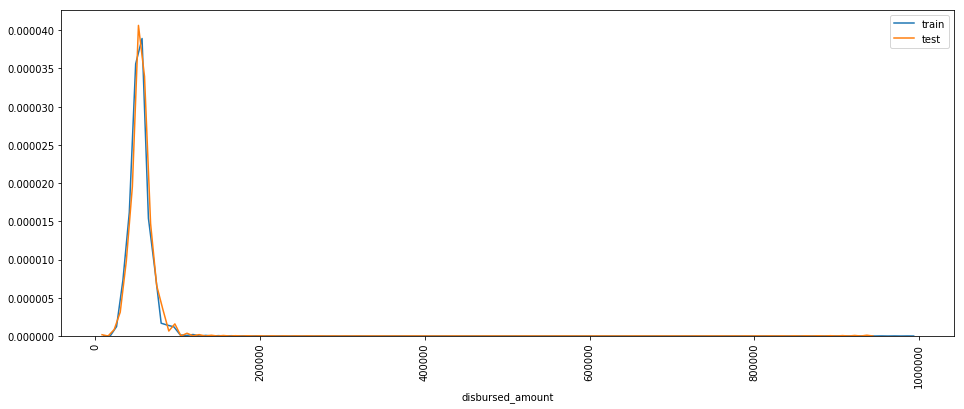

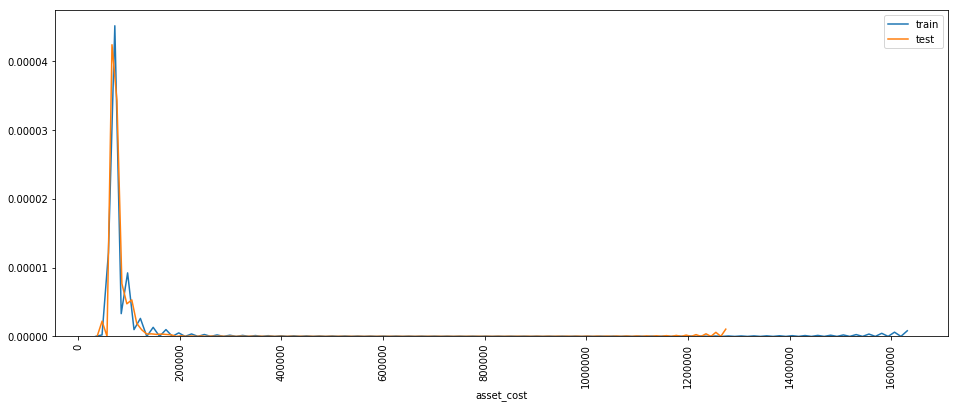

In [34]:
distplot_it(train_test, 'train_flag', 'disbursed_amount')
distplot_it(train_test, 'train_flag', 'asset_cost')


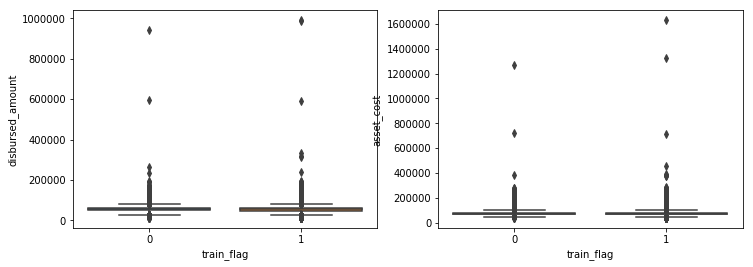

In [35]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(y='disbursed_amount', x='train_flag', data=train_test, ax=ax[0])
sns.boxplot(y='asset_cost', x='train_flag', data=train_test, ax=ax[1])


In [12]:
def remove_and_fill_outlier(df, flag):
    """fill outlier with the nan values"""
    """
    Args:
        df  : feature
        flag: string ['lower','upper','both']
    return: array containing new feature
    """
    lower_bound = np.percentile(df, q=1)
    upper_bound = np.percentile(df, q=99)
    print("low: ", np.round(lower_bound,2), "   high: ", np.round(upper_bound,2))
    if flag == 'upper':
        new = np.where(df>upper_bound, np.nan, df)
    elif flag == 'lower':
        new = np.where(df<lower_bound, np.nan, df)
    else: # when both are selected
        new = np.where(df>upper_bound, np.nan, df)
        new = np.where(new<lower_bound, np.nan, new)
    print("null count: ", pd.DataFrame(new).isnull().sum().values)
    return new


# new = remove_and_fill_outlier(train_test.disbursed_amount, flag='upper')
# new.shape
# np.clip(train_test.disbursed_amount, lower_bound, upper_bound).shape, train_test.shape

In [13]:
def remove_outlier(df, col, flag):
    """fill outlier with the nan values"""
    """
    Args:
        df  : feature
        flag: string ['lower','upper','both']
    return: array containing new feature
    """
    lower_bound = np.percentile(df[col], q=1)
    upper_bound = np.percentile(df[col], q=99)
    print("low: ", np.round(lower_bound,2), "   high: ", np.round(upper_bound,2))
    print("check shape: ", df.shape[0], "==>", end=" ")
    if flag == 'upper':
        df = df[df[col]<upper_bound]
    elif flag == 'lower':
        df = df[df[col]>lower_bound]
    else: # when both are selected
        df = df[df[col]<upper_bound]
        df = df[df[col]>lower_bound]
    print(df.shape[0])
    return df



low:  27016.6    high:  95490.0
check shape:  345546 ==> 342042
low:  48263.51    high:  132417.0
check shape:  342042 ==> 338607


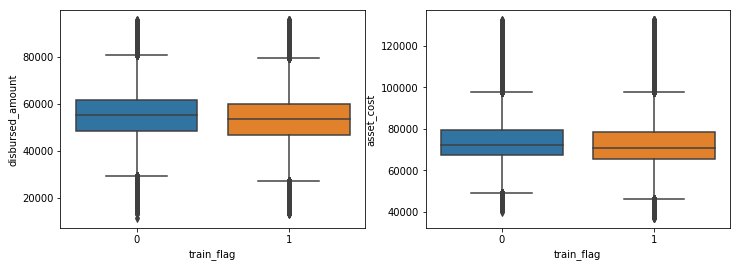

In [14]:
train_test = remove_outlier(train_test, 'disbursed_amount','upper')
train_test = remove_outlier(train_test, 'asset_cost','upper')

fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(y='disbursed_amount', x='train_flag', data=train_test, ax=ax[0])
sns.boxplot(y='asset_cost', x='train_flag', data=train_test, ax=ax[1])


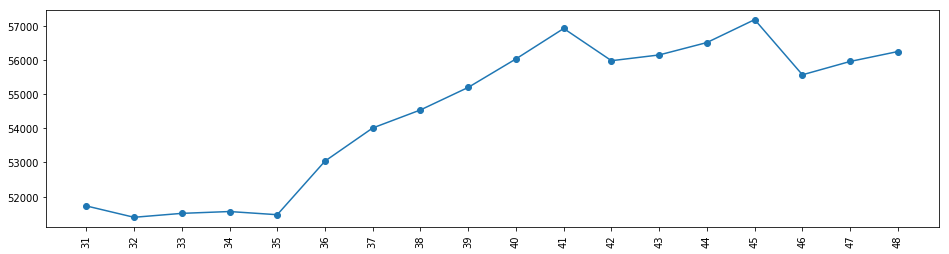

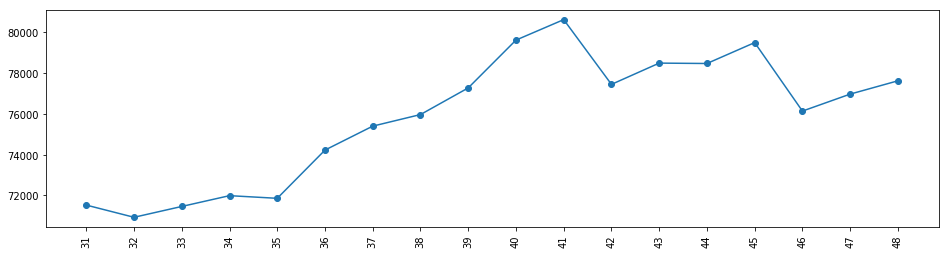

In [113]:
plt.figure(figsize=(16,4))
plt.plot(train_test.groupby(['disbursal_week'])['disbursed_amount'].mean(),'-o')
plt.xticks(np.arange(31,49))
_ = plt.xticks(rotation='vertical')

plt.figure(figsize=(16,4))
plt.plot(train_test.groupby(['disbursal_week'])['asset_cost'].mean(),'-o')
plt.xticks(np.arange(31,49))
_ = plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'After removing outliers')

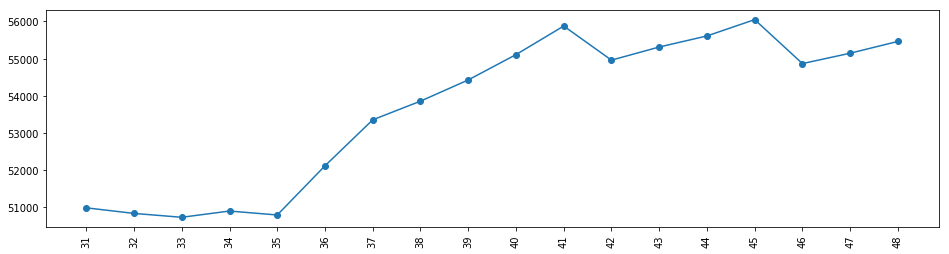

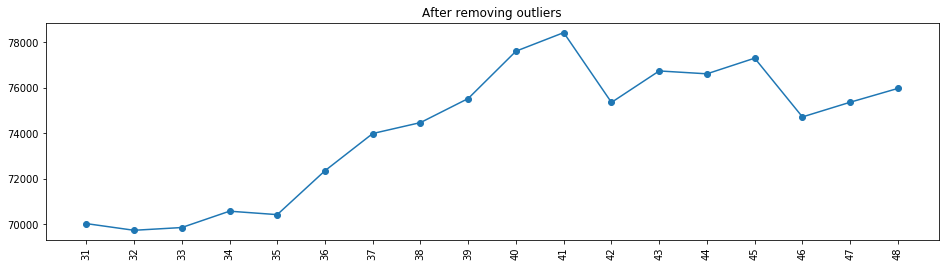

In [39]:
plt.figure(figsize=(16,4))
plt.plot(train_test.groupby(['disbursal_week'])['disbursed_amount'].mean(),'-o')
plt.xticks(np.arange(31,49))
_ = plt.xticks(rotation='vertical')

plt.figure(figsize=(16,4))
plt.plot(train_test.groupby(['disbursal_week'])['asset_cost'].mean(),'-o')
plt.xticks(np.arange(31,49))
_ = plt.xticks(rotation='vertical')
plt.title("After removing outliers")

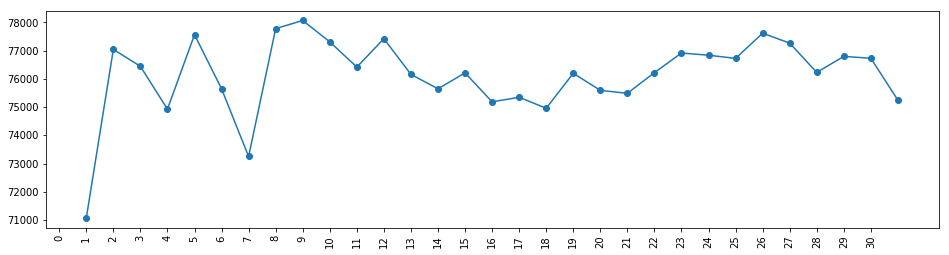

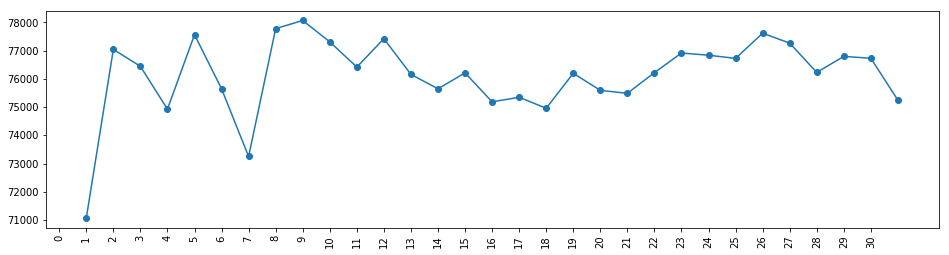

In [115]:
plt.figure(figsize=(16,4))
plt.plot(train_test.groupby(['disbursal_day'])['disbursed_amount'].mean(),'-o')
plt.xticks(np.arange(31))
_ = plt.xticks(rotation='vertical')

plt.figure(figsize=(16,4))
plt.plot(train_test.groupby(['disbursal_day'])['asset_cost'].mean(),'-o')
plt.xticks(np.arange(31))
_ = plt.xticks(rotation='vertical')

In [15]:
def countplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,4))
    sns.countplot(x=col, hue=flag_col, data=train_test)
    _ = plt.xticks(rotation='vertical')

In [149]:
train_test.columns

Index(['AVERAGE.ACCT.AGE', 'Aadhar_flag', 'CREDIT.HISTORY.LENGTH',
       'Current_pincode_ID', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'Date.of.Birth', 'DisbursalDate', 'Driving_flag', 'Employee_code_ID',
       'Employment.Type', 'MobileNo_Avl_Flag', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'PAN_flag', 'PRI.ACTIVE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'PRI.NO.OF.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.SANCTIONED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'Passport_flag', 'SEC.ACTIVE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'SEC.INSTAL.AMT', 'SEC.NO.OF.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.SANCTIONED.AMOUNT', 'State_ID', 'UniqueID',
       'VoterID_flag', 'asset_cost', 'branch_id', 'disbursed_amount',
       'loan_default', 'ltv', 'manufacturer_id', 'supplier_id',
       'DisbursalDate_new', 'disbursal_week', 'disbursal_day',
       'disbursal_month', 'credit_hist_year', 'credit_hist_month',
       'loan_tenure_year', 

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df['Bureau_desc'])+list(test_df['Bureau_desc']))
print(le.classes_)
train_df['Bureau_desc'] = le.transform(train_df['Bureau_desc'])
test_df['Bureau_desc'] = le.transform(test_df['Bureau_desc'])


['A-Very Low Risk' 'B-Very Low Risk' 'C-Very Low Risk' 'D-Very Low Risk'
 'E-Low Risk' 'F-Low Risk' 'G-Low Risk' 'H-Medium Risk' 'I-Medium Risk'
 'J-High Risk' 'K-High Risk' 'L-Very High Risk' 'M-Very High Risk'
 'not_enough_info']


In [19]:
cat_cols = ['State_ID', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'Driving_flag', 
            'VoterID_flag', 'Passport_flag', 'PRI.OVERDUE.ACCTS', 'SEC.NO.OF.ACCTS',
            'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'NO.OF_INQUIRIES',
            'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

In [20]:
test_df[['credit_hist_year', 'credit_hist_month','loan_tenure_year', 'loan_tenure_month']] = \
test_df[['credit_hist_year', 'credit_hist_month','loan_tenure_year', 'loan_tenure_month']].astype('int')

In [21]:
# tr_ids = train_df['UniqueID']
# ts_ids = test_df['UniqueID']
# target = train_df['loan_default']
# print(target.value_counts())
# # 182543/50611

# train_df_save = train_df.copy()
# test_df_save = test_df.copy()
# print(train_df.shape, test_df.shape, target.shape)

0    182543
1     50611
Name: loan_default, dtype: int64
(233154, 47) (112392, 46) (233154,)


In [22]:
target[train_df['Employment.Type'].isnull()].value_counts()

0    6017
1    1644
Name: loan_default, dtype: int64

In [79]:
train_df['Employment.Type'].isnull().sum()/train_df.shape[0], \
test_df['Employment.Type'].isnull().sum()/test_df.shape[0], \
train_test['Employment.Type'].isnull().sum()/train_test.shape[0]

(0.0328581109481287, 0.030633852943269983, 0.03213465066879663)

In [75]:
train_test.groupby(['Employment.Type','loan_default']).size().unstack()

loan_default       0.0    1.0
Employment.Type              
Salaried         77948  19910
Self employed    98578  29057

In [16]:
train_test['Employment.Type'].fillna('Self employed', inplace=True)
# test_df['Employment.Type'].fillna('Self employed', inplace=True)

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(list(train_df['Employment.Type'])+list(test_df['Employment.Type']))
# print(le.classes_)
# train_df['Employment.Type'] = le.transform(train_df['Employment.Type'])
# test_df['Employment.Type'] = le.transform(test_df['Employment.Type'])


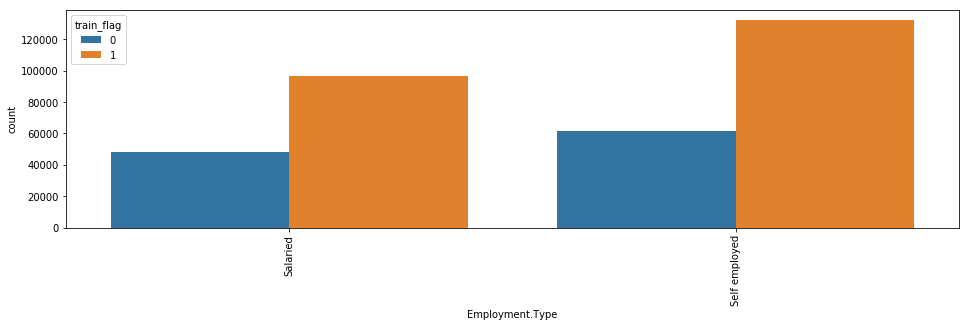

In [17]:
countplot_it(train_test, 'train_flag', 'Employment.Type')

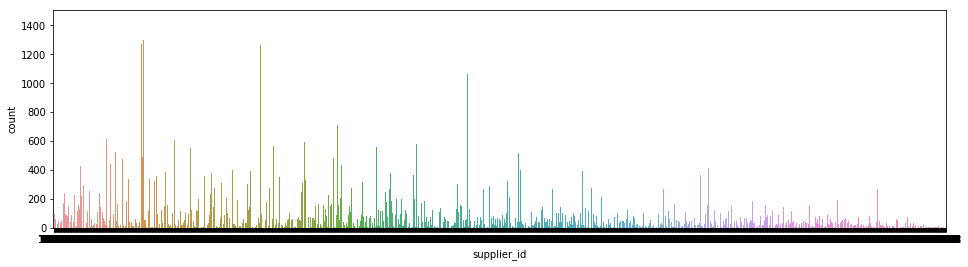

In [24]:
plt.figure(figsize=(16,4))
sns.countplot(train_df['supplier_id'])

In [25]:
train_df.groupby(['supplier_id','loan_default'])['loan_default'].count().unstack().mean()

loan_default
0    62.967575
1    18.983871
dtype: float64

In [26]:
len(set(train_df.supplier_id)),len(set(test_df.supplier_id)), len(set(train_df.supplier_id).intersection(set(test_df.supplier_id))),\
len(set(train_df.State_ID)),len(set(test_df.State_ID)), len(set(train_df.State_ID).intersection(set(test_df.State_ID)))

(2953, 2863, 2727, 22, 22, 22)

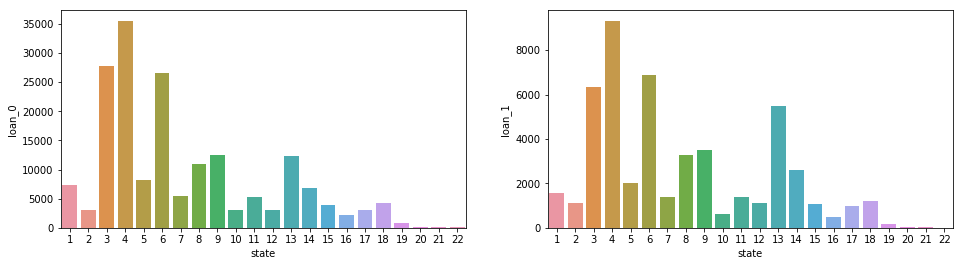

In [27]:
state_gps = train_df.groupby(['State_ID','loan_default'])['loan_default'].count().unstack()
state_gps.columns = ['loan_0', 'loan_1']
state_gps['state'] = state_gps.index

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=state_gps, ax=ax[0])
sns.barplot(x='state',y="loan_1", data=state_gps, ax=ax[1])

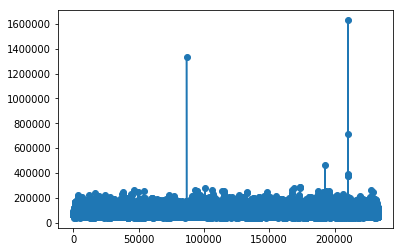

In [28]:
#   	asset_cost  	Cost of the Asset 	NaN
# 4 	ltv         	Loan to Value of the asset 	NaN
# 5 	branch_id   	Branch where the loan was disbursed 	NaN
# 6 	supplier_id 	Vehicle Dealer where the loan was disbursed 	NaN
# 7 	manufacturer_id 	Vehicle manufacturer(Hero, Honda, TVS etc.) 	NaN

plt.plot(train_df['asset_cost'],'-o')

228729 233154
unique values:  (46252,) (46252,) (43802,) (43802,)


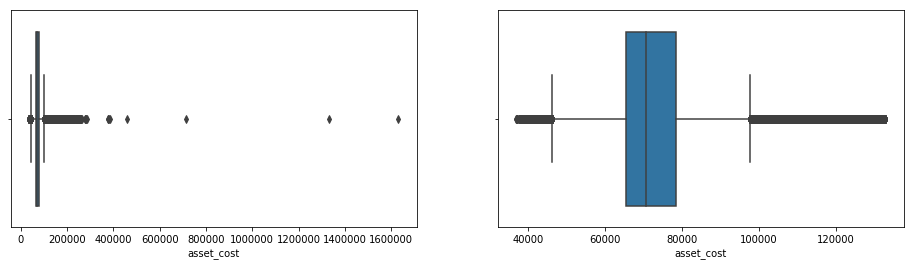

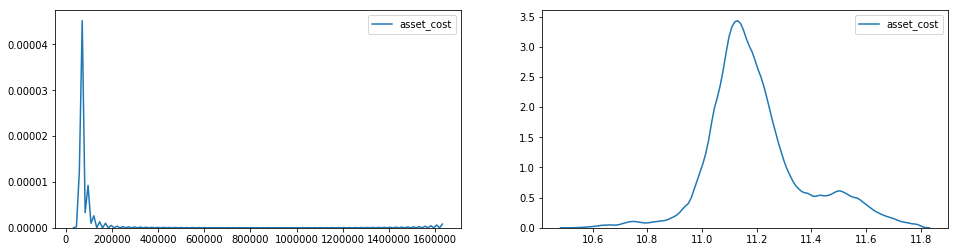

In [31]:
from scipy import stats
col = 'asset_cost'
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(np.log(tp), ax=ax[1])#,label='1')

print("unique values: ", train_df[col].unique().shape, 
      train_df[col].round().unique().shape, 
      tp.unique().shape, tp.round().unique().shape)

233154 ==> 230409


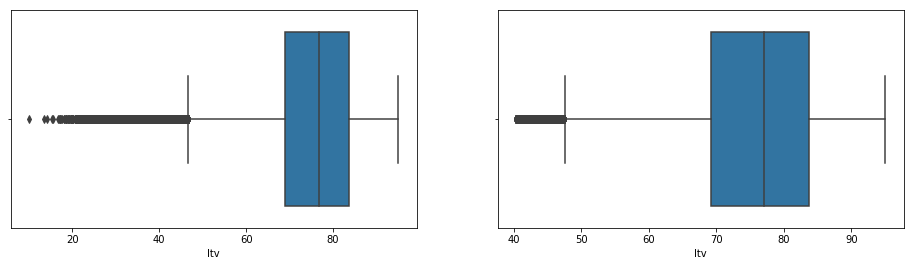

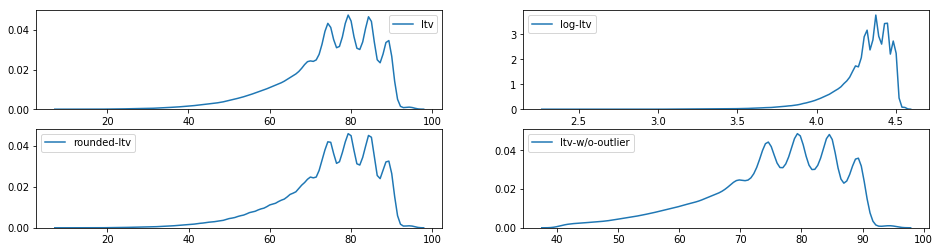

In [37]:
col = 'ltv'
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(train_df.shape[0], "==>", tp.shape[0])

fig, ax = plt.subplots(2,2,figsize=(16,4))
axes = ax.flatten()
sns.kdeplot(train_df[col], ax=axes[0],label='ltv')
sns.kdeplot(np.log(train_df[col]), ax=axes[1],label='log-ltv')

sns.kdeplot(train_df[col].round(), ax=axes[2],label='rounded-ltv')
sns.kdeplot(tp, ax=axes[3],label='ltv-w/o-outlier')
plt.legend()

Let's say the current appraised value of your home is $200,000. The remaining mortgage balance is $160,000. $160,000 is 80% of $200,000 — so that's an 80% loan-to-value ratio. Generally, a lower LTV ratio is better, although we consider many factors when figuring out your refinance options.


In [35]:
col = 'ltv'
train_df[col].unique().shape, train_df[col].round().unique().shape, tp.unique().shape, tp.round().unique().shape

((6579,), (83,), (5282,), (56,))

In [39]:
train_df['ltv_round'] = train_df[col].round()
test_df['ltv_round']  = test_df[col].round()


In [40]:
len(set(train_df.branch_id)),len(set(test_df.branch_id)), \
len(set(train_df.branch_id).intersection(set(test_df.branch_id))),\
len(set(train_df.supplier_id)),len(set(test_df.supplier_id)), \
len(set(train_df.supplier_id).intersection(set(test_df.supplier_id))),\
len(set(train_df.manufacturer_id)),len(set(test_df.manufacturer_id)), \
len(set(train_df.manufacturer_id).intersection(set(test_df.manufacturer_id)))

(82, 82, 82, 2953, 2863, 2727, 11, 11, 10)

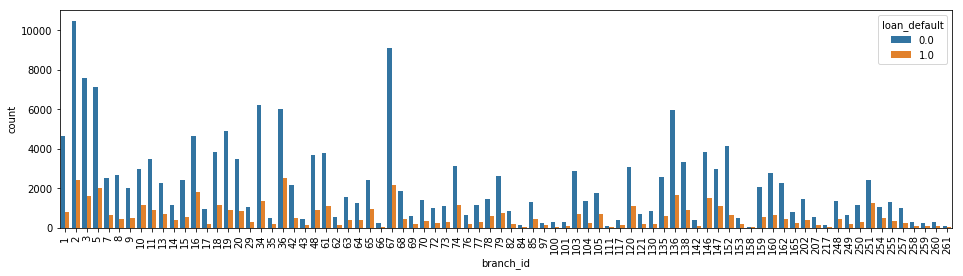

In [45]:
countplot_it(train_test.iloc[:train_df.shape[0]], 'loan_default', 'branch_id')

In [56]:
train_df.groupby(['branch_id'])['asset_cost'].aggregate(['mean','std'])


mean           std
branch_id                            
1          86410.787003  22098.958507
2          78939.855229  19146.206014
3          66546.842254  11856.884504
5          73373.572033  12592.612090
7          85287.626009  18500.421368
8          80832.183408  19563.584126
9          81444.541139  16881.834466
10         79372.339394  16628.248341
11         88804.317798  21459.253573
13         77007.602624  10233.071890
14         66955.134146  18540.870756
15         64671.588908   8832.832572
16         74521.035880  11394.519502
17         75633.900000  15811.345941
18         72664.396860  14087.967392
19         71926.820648  12501.208322
20         76719.257730  20704.388518
29         95192.981877  31414.755396
34         70559.260842  18574.780993
35         80784.750361  23966.303796
36         84519.302649  19971.104779
42         82633.892410  18620.877607
43         76143.169521  17200.735668
48         76472.626243  21287.054677
61         68411.148390  11804.724280
62         66518.690304  13053.627931
63         69008.072671   9696.293298
64         73517.813487  12473.904620
65         81402.660872  21697.994114
66         74747.025478  11545.273415
67         69270.290519   9876.502691
68         67133.551858  10725.750492
69         77822.670370  19076.556043
70         70391.808765  11989.021114
72         65576.196291  17429.621108
73         67683.568776  17343.326056
74         69949.322318  15605.917896
76         76471.945029  14306.752056
77         74192.112803  16141.956194
78         74584.647113  24025.065219
79         68262.634339  15266.829322
82         77173.536232  10282.119890
84         71609.044872  12274.228955
85         76186.603945  25460.037368
97         63769.048843   7907.361713
100        71865.879154  12732.147737
101        77319.475543  24073.024738
103        86968.744972  28311.579037
104        78054.273168  20836.630672
105        65317.178571  10229.647659
111        73772.101124   9591.122528
117        78719.609319  15861.275509
120        84565.849169  17790.313606
121        73636.658371   6516.654842
130        69050.507016  10580.013754
135        78354.808617  13609.477540
136        76280.826631  19288.106156
138        78249.817785  36045.390399
142        69826.621564  10527.036093
146        74568.912016  11480.616025
147        69785.454087  14876.181867
152        85235.431380  20609.550135
153        63087.398844  11316.649904
158        76616.652174   9089.004622
159        78613.631927  21638.367627
160        69461.047932  17275.686444
162        74000.597172  13938.944354
165        75578.957884  15582.153143
202        74098.407204  22327.642206
207        63030.566038   8823.867005
217        86984.224044  32217.295833
248        81789.913446  13016.006390
249        75211.257576  15169.140361
250        72931.154625  15988.728637
251        82125.196410  22538.530907
254        90313.157151  24138.163067
255        88428.173939  17342.563334
257        64381.739650  12078.575730
258        76257.692513  28487.556311
259        61788.407514   6516.756540
260        84014.725806  20296.167804
261        85242.857955  36711.510515

In [55]:
train_test.groupby(['branch_id'])['asset_cost'].aggregate(['mean','std'])


mean           std
branch_id                            
1          82960.658576  14852.588298
2          79412.936813  11884.353037
3          67491.059113  11329.199066
5          73007.297989   9160.890677
7          84384.860372  15908.103682
8          79110.581943  15181.865589
9          79727.617469  13039.398323
10         79360.162464  14879.551777
11         86980.287986  18706.878638
13         77974.383782  10019.232536
14         66551.965704  14040.560412
15         65134.001671   6776.101504
16         75047.579626  10036.279531
17         74541.703147   9043.253880
18         72729.457352  11478.261466
19         72215.314789  11422.127988
20         74860.811225  16222.980111
29         84548.805391  16741.624426
34         68736.879430  10255.306048
35         78010.356522  18080.897358
36         82733.767656  15382.638499
42         80585.202045  14328.298279
43         76387.948068  15690.204989
48         74157.152058  15159.461361
61         69108.128093  10617.625736
62         66333.097561   6198.275899
63         69378.682506   8927.671163
64         73801.101911  10815.634164
65         78412.486360  15281.825518
66         75274.682746   9526.691848
67         69931.489318   9419.929053
68         67182.418683   7917.198453
69         76223.232618  15575.444416
70         70361.402682  10544.980279
72         63397.331193   7578.456444
73         65934.458899   9962.366445
74         69788.462637  12887.035321
76         77015.015444  12825.970156
77         73781.633512  11942.435071
78         72140.329606  12439.381901
79         67621.574464   8626.161872
82         77823.224982   9970.700749
84         73041.907455   8978.283177
85         71588.388889  12602.265859
97         64775.971386   8226.454523
100        71212.722003  11325.872296
101        73505.448000  14667.072910
103        81890.648584  17876.169321
104        76036.352403  15120.056150
105        66062.258685   9650.766638
111        72583.701389   7422.938911
117        78186.790570  14931.546444
120        84039.080605  15953.632239
121        74109.124690   6747.366854
130        69673.034270  10337.033663
135        79206.715027  10799.049696
136        75438.912106  16086.053126
138        74698.760005  11896.854131
142        70828.621277  10408.356390
146        75250.104191  10224.467087
147        69979.131850  11864.067962
152        82804.292679  15724.309238
153        63702.762982   6869.904436
158        77629.287129   9762.427106
159        76579.932542  13932.273591
160        68636.442150  12098.627391
162        73237.225831  10025.051058
165        75216.457321  13511.317777
202        70137.352000  12159.431675
207        63382.688231   7248.645310
217        77024.346416  11757.782071
248        82213.770995  11174.076158
249        74710.526277  11341.289785
250        72625.511863  12322.585314
251        79231.332999  15132.841069
254        85764.802224  16731.373636
255        87383.337950  16079.359042
257        63595.559186   6508.333422
258        69765.229604  12163.866492
259        63112.789731   6352.105046
260        83090.590133  19627.381089
261        67448.452214  12102.549126

In [62]:
# train_test.groupby(['branch_id'])['asset_cost'].aggregate(
#     ['min','max','std', 'mean', 'sum','mad','count'])

branch_mean
branch_id disbursal_week               
1         31               77734.611765
          32               77980.038217
          33               77343.461538
          34               78401.113514
          35               78349.271930
          36               78021.874016
          37               80435.760956
          38               82040.178404
          39               82338.577320
          40               83195.371542
          41               85077.952778
          42               84997.454936
          43               85227.532656
          44               83033.846154
          45               82855.828358
          46               83244.080103
          47               83690.408163
          48               83057.043546
2         31               71902.582840
          32               72535.600756
          33               72508.744604
          34               73076.096501
          35               73554.987292
          36               75153.681909
          37               76718.586002
          38               77875.648485
          39               77758.739164
          40               78764.018229
          41               80074.742857
          42               80924.137687
          43               81857.764361
          44               82658.270175
          45               82859.822310
          46               82720.661729
          47               82526.541993
          48               83264.078148
3         31               62391.379747
          32               63231.375000
          33               63678.482569
          34               63740.280151
          35               63748.400231
          36               64658.894879
          37               65972.570470
          38               66801.414081
          39               66752.150402
          40               65390.096774
          41               68334.463138
          42               68704.896410
          43               68830.963463
          44               68752.182491
          45               68533.910053
          46               68819.766856
          47               69857.128336
          48               70228.863450
5         31               68882.578571
          32               68606.074875
          33               69137.228426
          34               69159.147395
          35               69208.101430
          36               72482.788927
          37               73205.464373
          38               72937.900606
          39               74603.880526
          40               75804.468023
          41               75594.048620
          42               75773.018106
          43               75399.965190
          44               75558.588800
          45               76860.312292
          46               75746.942149
          47               76443.755656
          48               75348.582822
7         31               74988.840909
          32               80297.412844
          33               75210.115702
          34               76777.641026
          35               76512.604167
          36               78443.357664
          37               82351.004425
          38               84867.722892
          39               83241.120907
          40               88155.402685
          41               88835.934940
          42               88593.846995
          43               87003.992188
          44               86146.736842
          45               86031.007547
          46               85802.754777
          47               85190.281124
          48               84993.368889
8         31               71782.545455
          32               77659.200000
          33               73790.991228
          34               73408.161290
          35               74343.246512
          36               78521.792079
          37               79046.157303
          38               78841.468013
          39               7

In [68]:
for col in ['manufacturer_id','State_ID','supplier_id','branch_id']:
    print(train_test[col].unique().shape[0])

8
22
2958
82


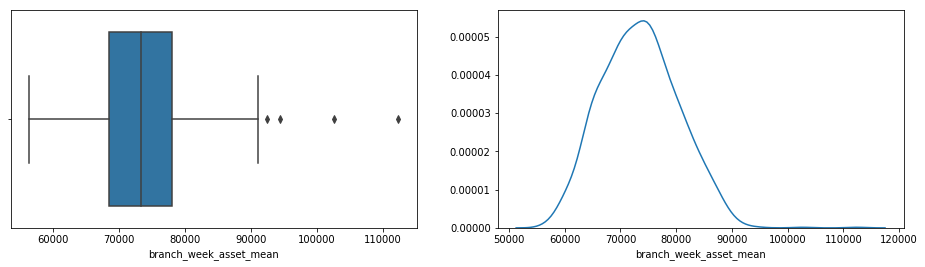

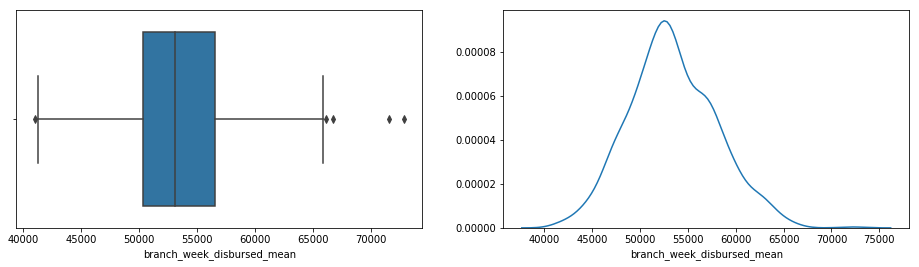

In [18]:
####################### Branch Mean #######################
branch_gps = train_test.groupby(['branch_id','disbursal_week'])[
    'asset_cost'].aggregate(['mean'])
branch_gps.columns = ['branch_week_asset_mean']
# train_test = pd.merge(train_test, branch_gps, on=['branch_id','disbursal_week'],how='left')
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(branch_gps['branch_week_asset_mean'], ax=ax[0])
sns.distplot(branch_gps['branch_week_asset_mean'], hist=False)

branch_gps = train_test.groupby(['branch_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_week_disbursed_mean']

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(branch_gps['branch_week_disbursed_mean'], ax=ax[0])
sns.distplot(branch_gps['branch_week_disbursed_mean'], hist=False)



## Including time component `week` in mean grouping

In [19]:
print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id','disbursal_week'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID','disbursal_week'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id','disbursal_week'],how='left')

print(train_test.shape)

(338607, 52) ==> (338607, 55)


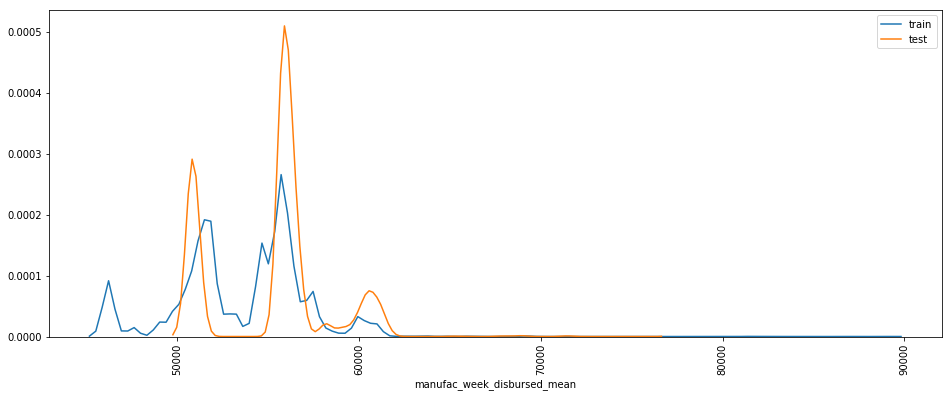

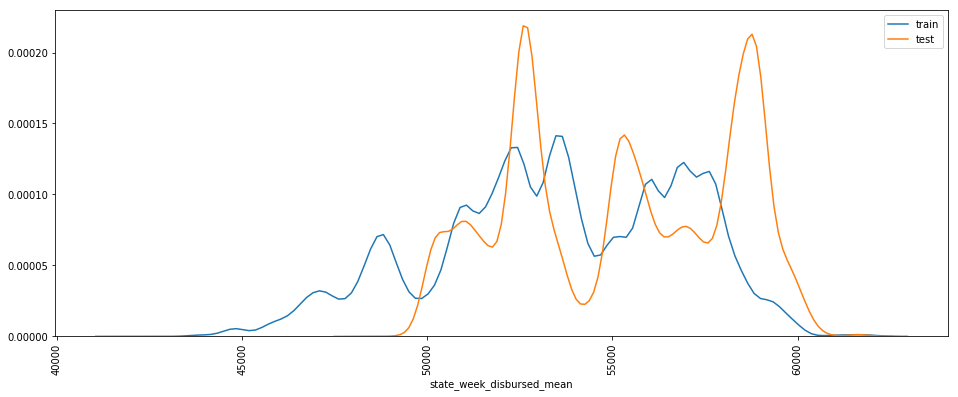

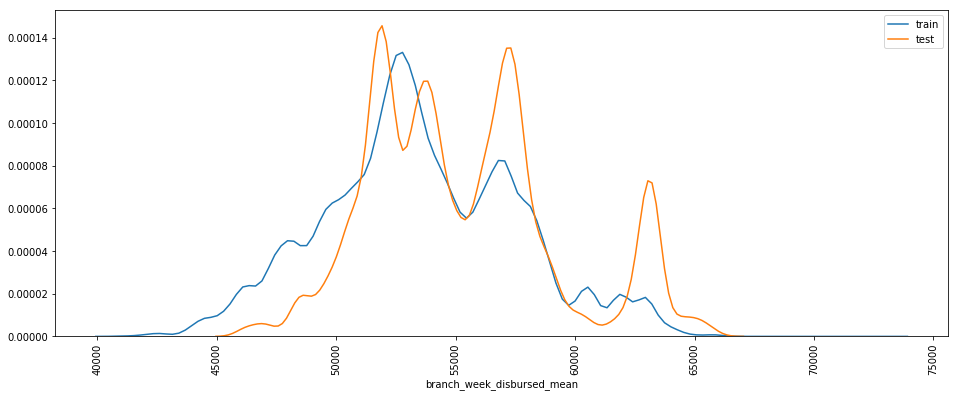

In [70]:
distplot_it(train_test, 'train_flag', 'manufac_week_disbursed_mean')
distplot_it(train_test, 'train_flag', 'state_week_disbursed_mean')
distplot_it(train_test, 'train_flag', 'branch_week_disbursed_mean')

In [20]:
print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id'],how='left')

print(train_test.shape)


(338607, 55) ==> (338607, 58)


NameError: name 'distplot_it' is not defined

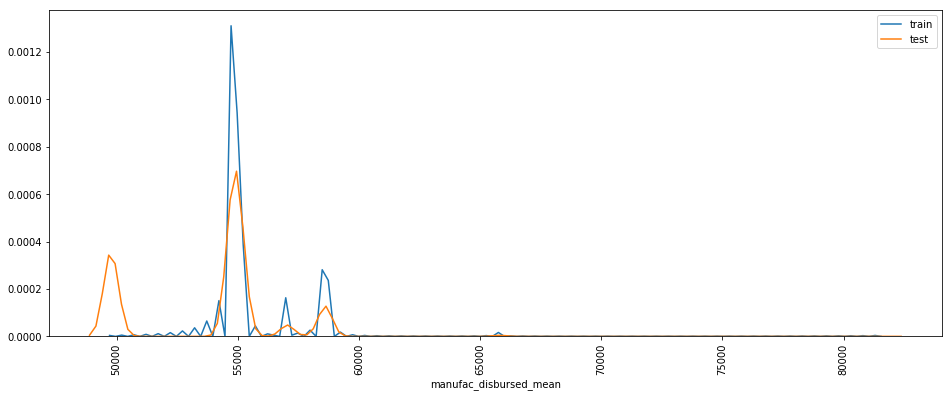

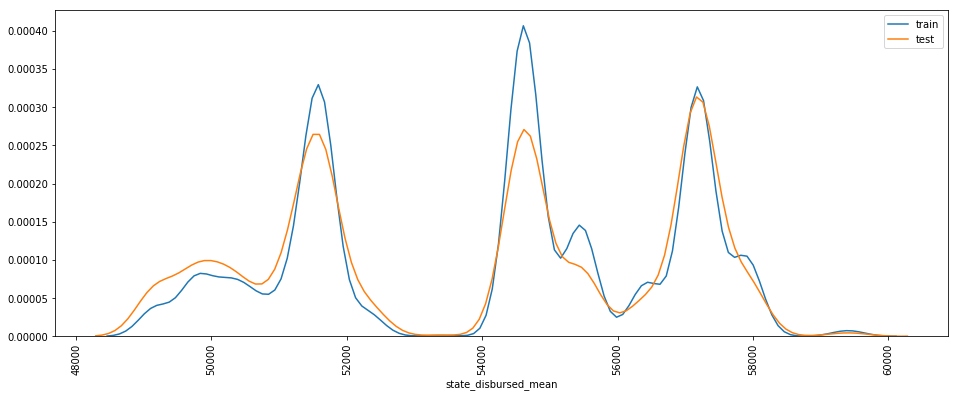

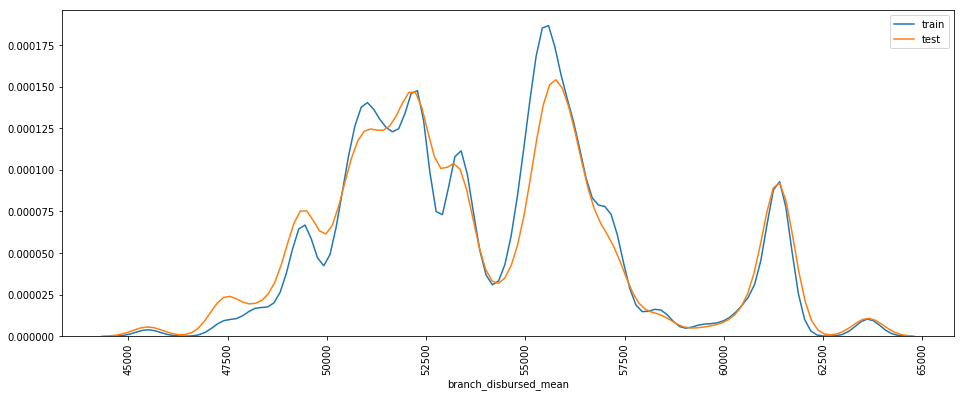

In [21]:
def distplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,6))
    sns.distplot(df[df[flag_col] == 1][col], hist=False, label='train')
    sns.distplot(df[df[flag_col] == 0][col], hist=False, label='test')
    _ = plt.xticks(rotation='vertical')
    
distplot_it(train_test, 'train_flag', 'manufac_disbursed_mean')
distplot_it(train_test, 'train_flag', 'state_disbursed_mean')
distplot_it(train_test, 'train_flag', 'branch_disbursed_mean')

In [ ]:
# >>> targetEncoder = TargetEncoder(x=te_columns, y=responseColumnName, blended_avg=True, inflection_point=3, smoothing=1)
# >>> targetEncoder.fit(trainFrame) 
# >>> encodedTrain = targetEncoder.transform(frame=trainFrame, holdout_type="kfold", seed=1234, is_train_or_valid=True)
# >>> encodedValid = targetEncoder.transform(frame=validFrame, holdout_type="none", noise=0.0, is_train_or_valid=True)
# >>> encodedTest = targetEncoder.transform(frame=testFrame, holdout_type="none", noise=0.0, is_train_or_valid=False)

Text(0, 0.5, 'loan_1(normalized)')

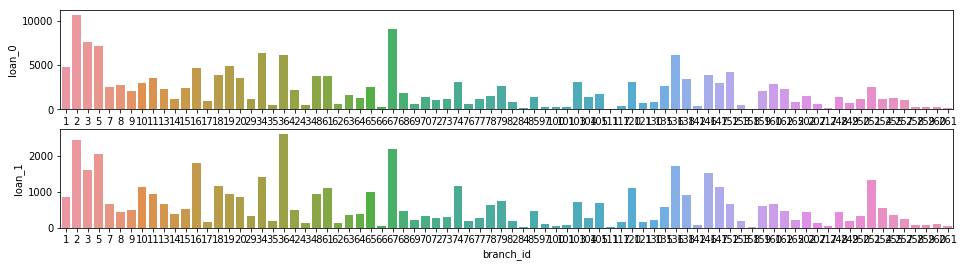

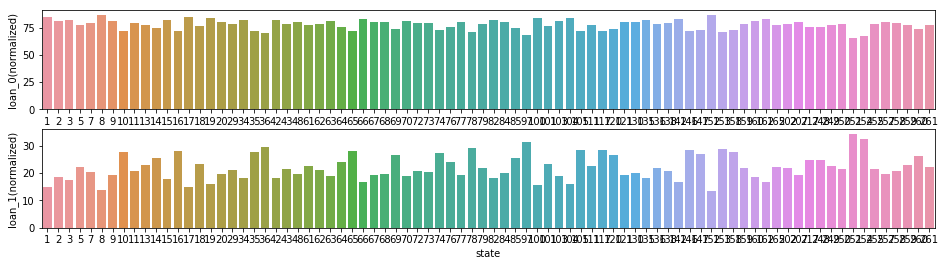

In [42]:
branch_gps = train_df.groupby(['branch_id','loan_default'])['loan_default'].count().unstack()
branch_gps.columns = ['loan_0', 'loan_1']
branch_gps['state'] = branch_gps.index

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=branch_gps, ax=ax[0])#,label='0')
ax[0].set_xlabel('branch_id')
sns.barplot(x='state',y="loan_1", data=branch_gps, ax=ax[1])#,label='1')
ax[1].set_xlabel('branch_id')

branch_gps[['loan_0','loan_1']] = 100*branch_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=branch_gps, ax=ax[0])#,label='0')
ax[0].set_ylabel('loan_0(normalized)')
sns.barplot(x='state',y="loan_1", data=branch_gps, ax=ax[1])#,label='1')
ax[1].set_ylabel('loan_1(normalized)')



Text(0, 0.5, 'loan_1(norm)')

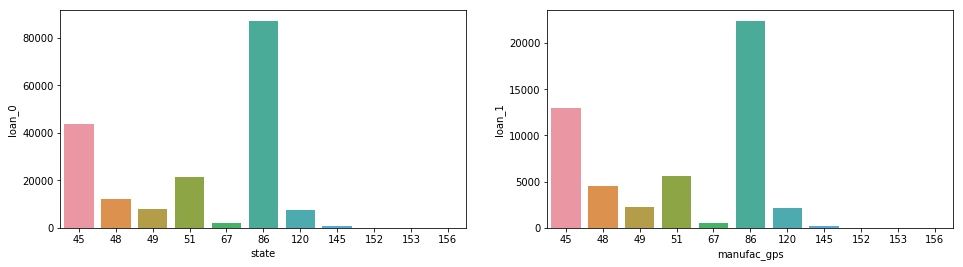

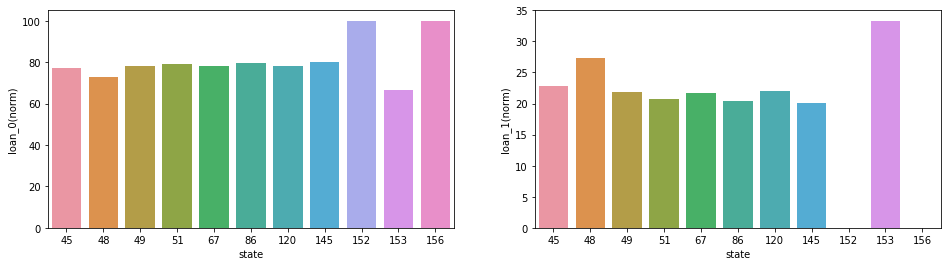

In [43]:
manufac_gps = train_df.groupby(['manufacturer_id','loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
ax[1].set_xlabel('manufac_gps')

manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
ax[0].set_ylabel('loan_0(norm)')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
ax[1].set_ylabel('loan_1(norm)')


In [ ]:
# Application amount: This is the amount you are applying for. You might want to apply for a loan of 40 lakhs to pursue your higher studies.
# Sanctioned amount: This is the amount that the bank has approved you for after their due diligence. This will be less than or equal to the application amount. In the case mentioned above, it might happen that the bank can only approve you for a loan for 30 lakhs due to any number of reasons.
# Disbursed amount: The amount that has been used from the sanctioned amount. It might happen that you were approved for 30 lakhs. But you received a scholarship, or decided to use your savings to fund your education. You only take 5 lakhs from the bank as the loan. This is the disbursed amount
    

# 22  	PRI.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Primary 
#     accounts are those which the customer ...
# 23  	PRI.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 24  	PRI.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN
# 25 	PRI.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	The outstanding amount is the Total due of your loan that you need to pay to the bank including interest and principal till date. Its nothing but the total loan amount sanctioned minus the pricipal part part of ur EMI.
# 26 	PRI.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 27 	PRI.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo... 	NaN


In [44]:
cols = [  'PRI.NO.OF.ACCTS','PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS',
          'PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT',
          'PRIMARY.INSTAL.AMT']
train_df[cols].apply(lambda x: pd.Series.value_counts(x).shape[0])

PRI.NO.OF.ACCTS            108
PRI.ACTIVE.ACCTS            40
PRI.OVERDUE.ACCTS           22
PRI.CURRENT.BALANCE      71341
PRI.SANCTIONED.AMOUNT    44390
PRI.DISBURSED.AMOUNT     47909
PRIMARY.INSTAL.AMT       28067
dtype: int64

In [68]:
# sorted(train_df['PRI.NO.OF.ACCTS'].unique())

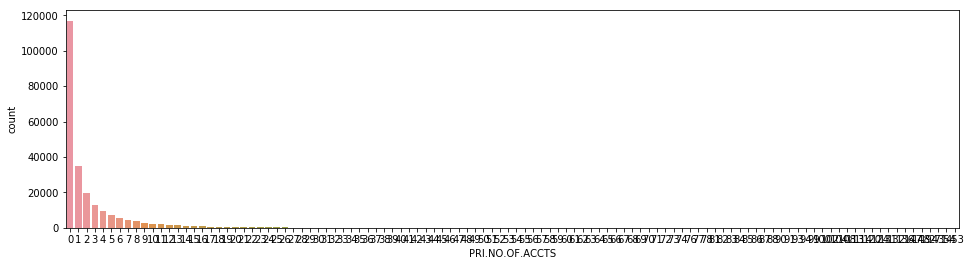

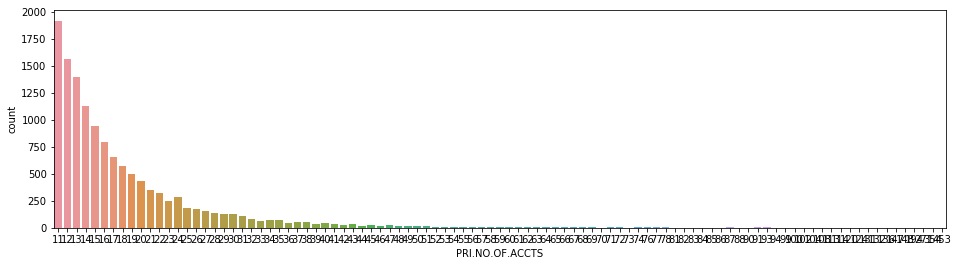

In [64]:
col = 'PRI.NO.OF.ACCTS'
plt.figure(figsize=(16,4))
sns.countplot(train_df[col])

plt.figure(figsize=(16,4))
sns.countplot(train_df[col][train_df[col] > 10])


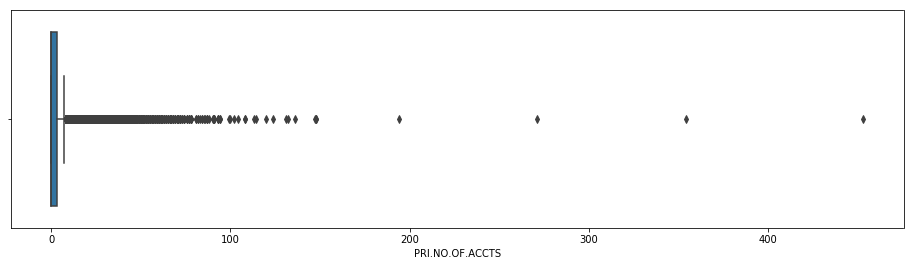

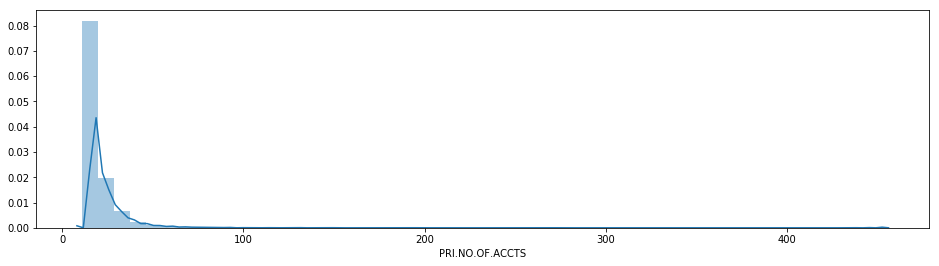

In [76]:
plt.figure(figsize=(16,4))
sns.boxplot(train_df['PRI.NO.OF.ACCTS'])

plt.figure(figsize=(16,4))
sns.distplot(train_df['PRI.NO.OF.ACCTS'][train_df['PRI.NO.OF.ACCTS'] > 10])


In [146]:
train_test['PRI.NO.OF.ACCTS'].value_counts()

0      171556
1       50798
2       28613
3       18993
4       13451
5       10325
6        7887
7        6266
8        5093
9        4082
10       3336
11       2705
12       2234
13       1906
14       1583
15       1327
16       1103
17        935
18        790
19        695
20        606
21        489
22        434
24        385
23        341
25        265
26        240
27        206
28        189
29        177
30        160
31        145
32        114
33        104
35        101
34         96
36         72
38         71
37         69
40         55
39         52
43         41
41         41
42         32
45         31
46         26
47         26
44         24
49         23
51         22
50         21
53         17
54         16
48         15
56         14
52         12
55         11
59         11
60         11
57          9
58          9
62          9
63          9
61          7
65          7
72          7
68          7
67          6
78          6
71          5
69          5
70    

In [147]:
no_of_loans = train_df.groupby(['PRI.NO.OF.ACCTS','loan_default'])['loan_default'].count().unstack()
no_of_loans.columns = ['loan_0','loan_1']
no_of_loans
# no_of_loans[no_of_loans.loan_0 < 20]

loan_0   loan_1
PRI.NO.OF.ACCTS                  
0                89898.0  27052.0
1                27241.0   7737.0
2                15535.0   4249.0
3                10377.0   2638.0
4                 7535.0   1788.0
5                 5818.0   1404.0
6                 4498.0   1059.0
7                 3574.0    837.0
8                 2901.0    669.0
9                 2347.0    537.0
10                1933.0    425.0
11                1588.0    331.0
12                1285.0    282.0
13                1150.0    251.0
14                 936.0    196.0
15                 787.0    154.0
16                 670.0    128.0
17                 540.0    112.0
18                 477.0     96.0
19                 426.0     77.0
20                 373.0     63.0
21                 296.0     51.0
22                 266.0     57.0
23                 201.0     49.0
24                 243.0     43.0
25                 150.0     37.0
26                 142.0     28.0
27                 134.0     19.0
28                 114.0     27.0
29                 108.0     22.0
30                 106.0     18.0
31                  97.0     14.0
32                  67.0     16.0
33                  60.0      7.0
34                  58.0     12.0
35                  60.0     13.0
36                  46.0      3.0
37                  49.0      4.0
38                  45.0      8.0
39                  25.0      9.0
40                  36.0      5.0
41                  26.0      5.0
42                  20.0      5.0
43                  25.0      7.0
44                  17.0      NaN
45                  19.0      5.0
46                  18.0      2.0
47                  20.0      3.0
48                  10.0      4.0
49                  13.0      1.0
50                  11.0      5.0
51                  13.0      4.0
52                   7.0      2.0
53                   8.0      3.0
54                   8.0      4.0
55                   6.0      1.0
56                   8.0      2.0
57                   8.0      1.0
58                   6.0      1.0
59                   7.0      2.0
60                   9.0      1.0
61                   3.0      4.0
62                   5.0      NaN
63                   4.0      3.0
64                   4.0      1.0
65                   5.0      NaN
66                   3.0      1.0
67                   4.0      NaN
68                   6.0      NaN
69                   2.0      1.0
70                   2.0      NaN
71                   3.0      1.0
72                   6.0      NaN
73                   1.0      1.0
74                   4.0      NaN
76                   3.0      NaN
77                   3.0      NaN
78                   5.0      NaN
81                   NaN      2.0
82                   2.0      NaN
83                   1.0      NaN
84                   1.0      1.0
85                   1.0      NaN
86                   1.0      NaN
87                   1.0      2.0
88                   NaN      1.0
90                   2.0      NaN
91                   3.0      NaN
93                   2.0      1.0
94                   NaN      2.0
99                   1.0      NaN
100                  1.0      NaN
102                  1.0      NaN
104                  NaN      1.0
108                  NaN      2.0
113                  1.0      NaN
114                  1.0      NaN
120                  1.0      NaN
124                  1.0      NaN
131                  1.0      NaN
132                  1.0      NaN
136                  1.0      NaN
147                  1.0      NaN
148                  1.0      1.0
194                  1.0      NaN
271                  1.0      NaN
354                  1.0      NaN
453                  NaN      1.0

In [65]:
bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 1), (1, 500)])
train_df['no_of_loans'] = pd.cut(train_df['PRI.NO.OF.ACCTS'], bins)
test_df['no_of_loans'] = pd.cut(test_df['PRI.NO.OF.ACCTS'], bins)
print(train_df.no_of_loans.value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df['no_of_loans']) + list(test_df['no_of_loans']))
print(le.classes_)
train_df['no_of_loans'] = le.transform(train_df['no_of_loans'])
test_df['no_of_loans']  = le.transform(test_df['no_of_loans'])

train_df.groupby(['no_of_loans','loan_default'])['loan_default'].count().unstack()


(-1, 0]     116950
(1, 500]     81226
(0, 1]       34978
Name: no_of_loans, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 500, closed='right')]


loan_default      0      1
no_of_loans               
0             89898  27052
1             27241   7737
2             65404  15822

In [148]:
4*3600

14400

In [66]:
train_df.drop('PRI.NO.OF.ACCTS', axis=1, inplace=True)
test_df.drop('PRI.NO.OF.ACCTS', axis=1, inplace=True)


229035 233154


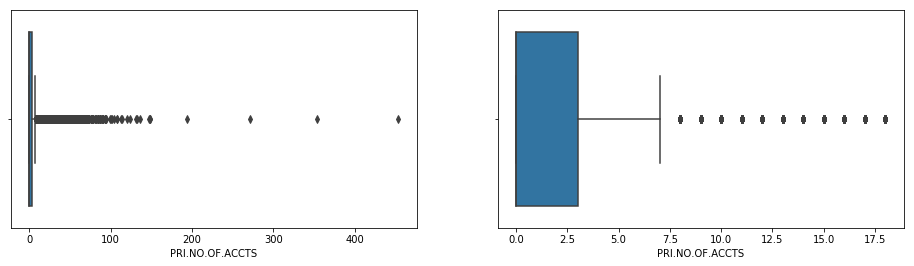

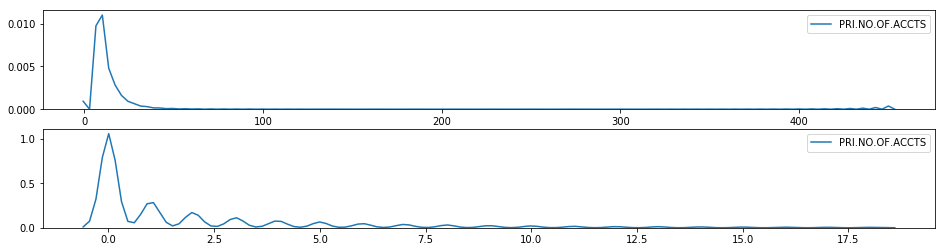

In [367]:
# col = cols[0]
# fig, ax = plt.subplots(1,2,figsize=(16,4))
# sns.boxplot(train_df[col], ax=ax[0])

# tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
# sns.boxplot(tp, ax=ax[1])
# print(tp.shape[0], train_df.shape[0])

# fig, ax = plt.subplots(2,1,figsize=(16,4))
# sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
# sns.kdeplot(tp, ax=ax[1])#,label='1')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 34, 35, 37, 39, 42, 43, 52, 65, 144]


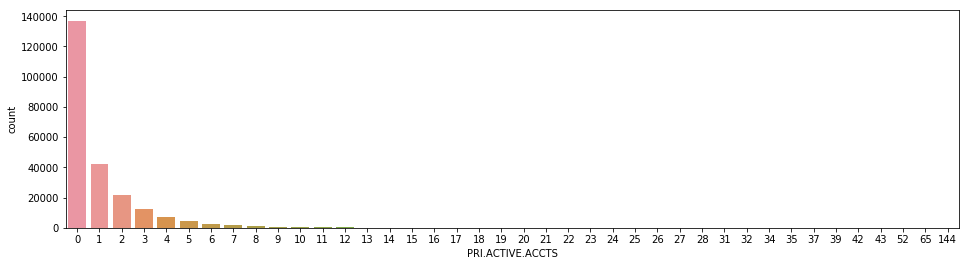

In [69]:
col = 'PRI.ACTIVE.ACCTS'
print(sorted(train_df[col].unique()))
plt.figure(figsize=(16,4))
sns.countplot(train_df[col])

# plt.figure(figsize=(16,4))
# sns.countplot(train_df[col][train_df[col] > 10])


In [73]:
# no_of_acc = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
# no_of_acc.columns = ['loan_0','loan_1']
# no_of_acc[no_of_acc.loan_0 < 10]

227678 233154


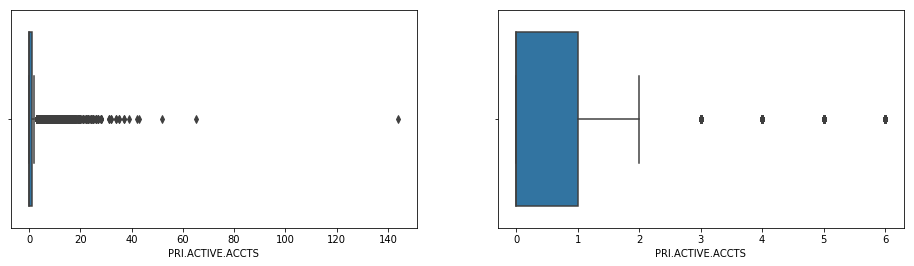

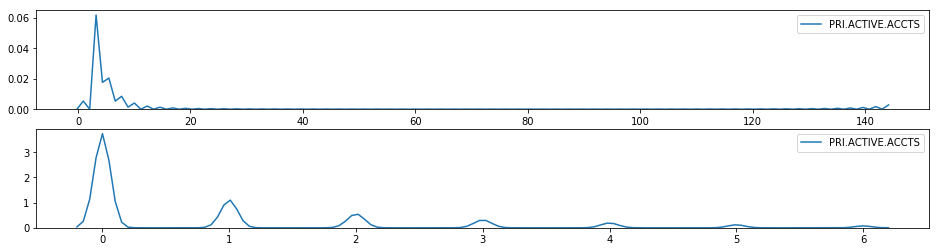

In [368]:

# col = cols[1]
# fig, ax = plt.subplots(1,2,figsize=(16,4))
# sns.boxplot(train_df[col], ax=ax[0])

# tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
# sns.boxplot(tp, ax=ax[1])
# print(tp.shape[0], train_df.shape[0])

# fig, ax = plt.subplots(2,1,figsize=(16,4))
# sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
# sns.kdeplot(tp, ax=ax[1])#,label='1')

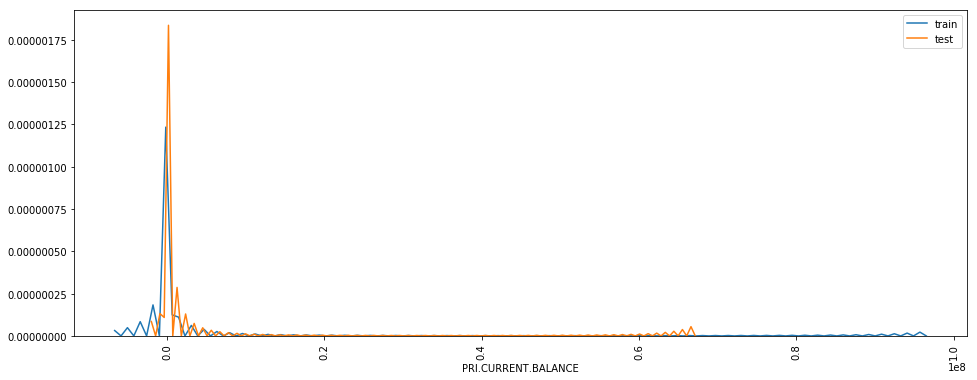

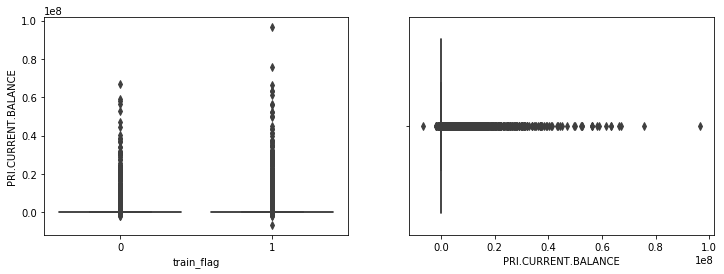

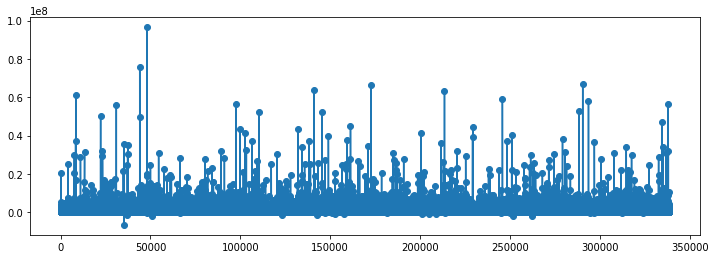

In [83]:
distplot_it(train_test, 'train_flag','PRI.CURRENT.BALANCE')

fig, ax = plt.subplots(1,2,figsize=(12,4))
# plt.figure(figsize=(12,4))
sns.boxplot(y='PRI.CURRENT.BALANCE', x='train_flag', data=train_test, ax=ax[0])
sns.boxplot(train_test['PRI.CURRENT.BALANCE'], ax=ax[1])

plt.figure(figsize=(12,4))
plt.plot(train_test['PRI.CURRENT.BALANCE'],'-o')

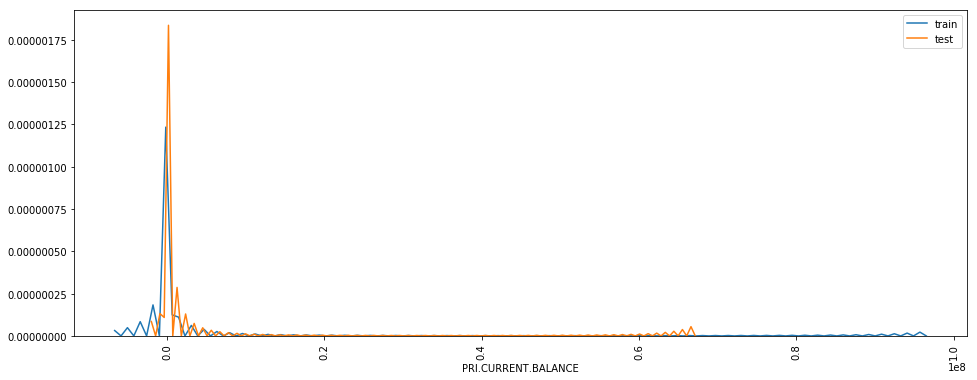

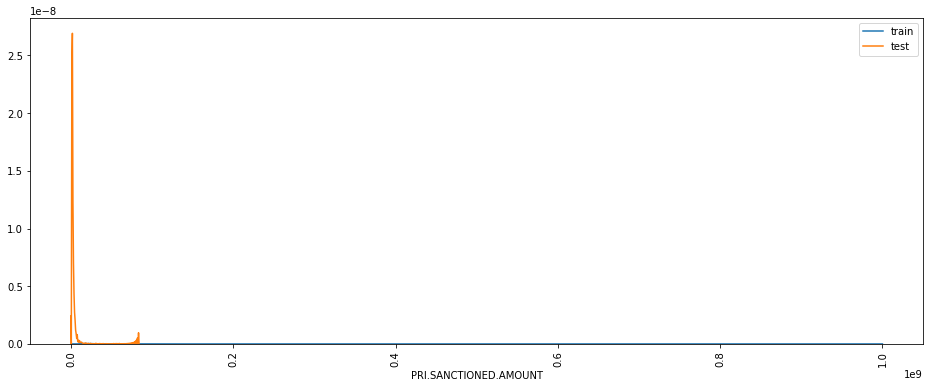

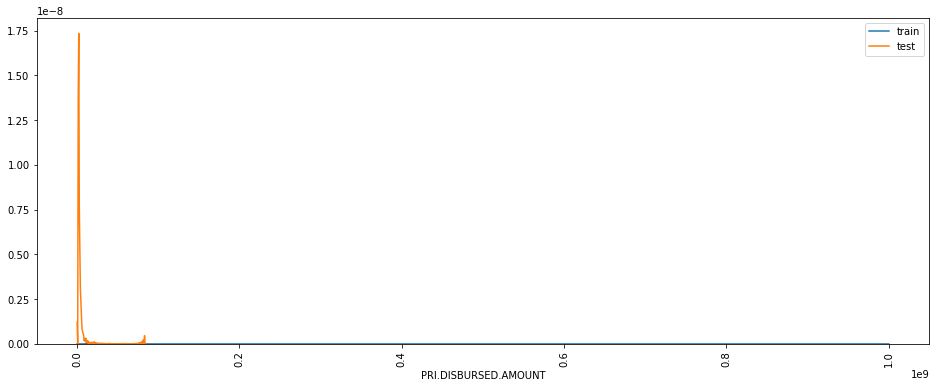

In [94]:
distplot_it(train_test, 'train_flag','PRI.CURRENT.BALANCE')
distplot_it(train_test, 'train_flag','PRI.SANCTIONED.AMOUNT')
distplot_it(train_test, 'train_flag','PRI.DISBURSED.AMOUNT')


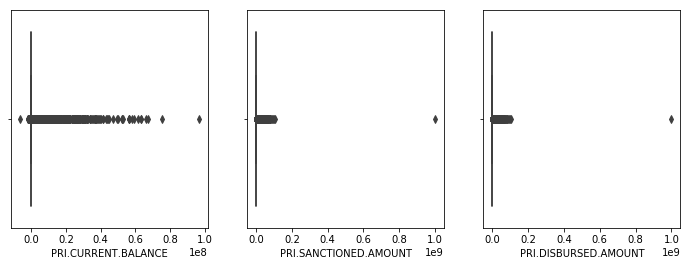

In [95]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
# plt.figure(figsize=(12,4))
sns.boxplot(train_test['PRI.CURRENT.BALANCE'], ax=ax[0])
sns.boxplot(train_test['PRI.SANCTIONED.AMOUNT'], ax=ax[1])
sns.boxplot(train_test['PRI.DISBURSED.AMOUNT'], ax=ax[2])


In [111]:
np.percentile(train_test['PRI.DISBURSED.AMOUNT'], q=99)

3351419.18

In [114]:
train_test['PRI.SANCTIONED.AMOUNT'][train_test['PRI.SANCTIONED.AMOUNT'] > 5000000].shape,\
train_df['PRI.SANCTIONED.AMOUNT'][train_df['PRI.SANCTIONED.AMOUNT'] > 5000000].shape,\
test_df['PRI.SANCTIONED.AMOUNT'][test_df['PRI.SANCTIONED.AMOUNT'] > 5000000].shape

((1687,), (1256,), (485,))

In [115]:
train_test['PRI.DISBURSED.AMOUNT'][train_test['PRI.DISBURSED.AMOUNT'] > 5000000].shape,\
train_df['PRI.DISBURSED.AMOUNT'][train_df['PRI.DISBURSED.AMOUNT'] > 5000000].shape,\
test_df['PRI.DISBURSED.AMOUNT'][test_df['PRI.DISBURSED.AMOUNT'] > 5000000].shape

((1696,), (1260,), (489,))

In [22]:
print(train_test.shape, "==>", end=" ")
train_test = train_test[train_test['PRI.SANCTIONED.AMOUNT'] >= 0]
train_test = train_test[train_test['PRI.SANCTIONED.AMOUNT'] < 5000000]
train_test = train_test[train_test['PRI.DISBURSED.AMOUNT'] < 5000000]
print(train_test.shape)

(338607, 58) ==> (336875, 58)


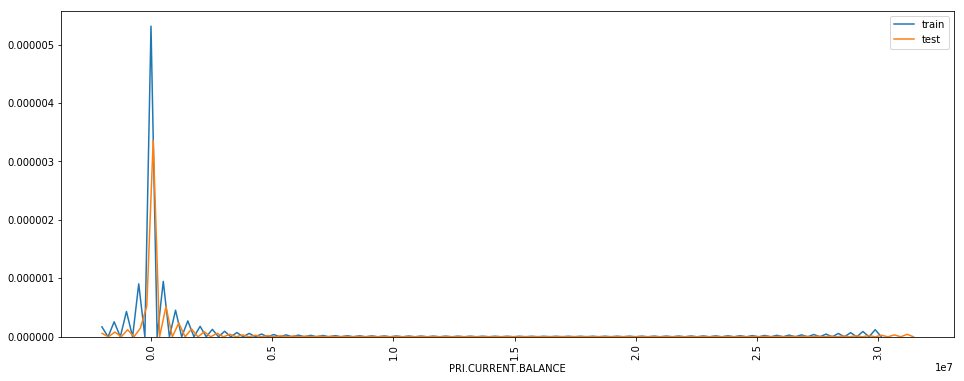

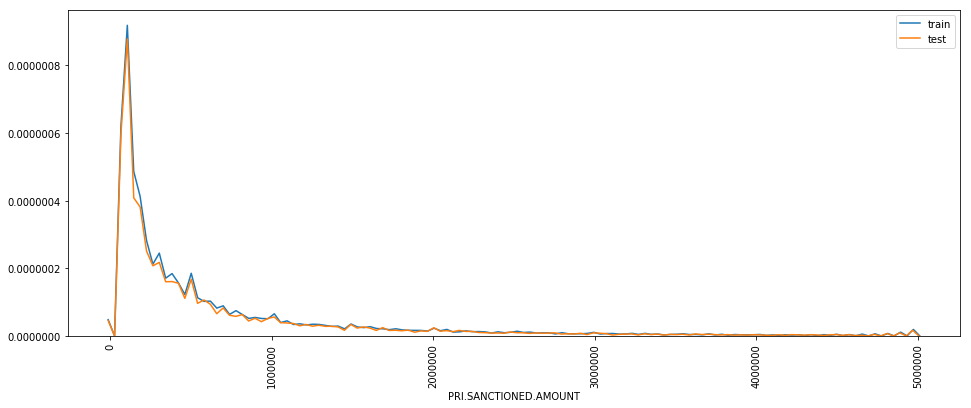

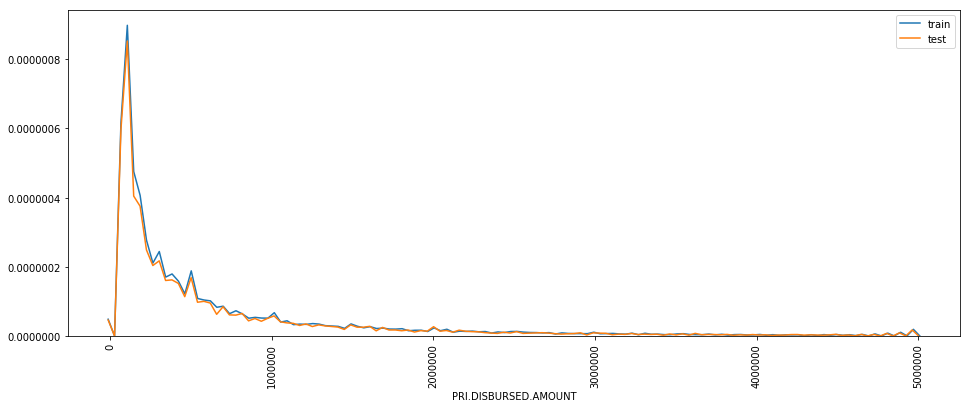

In [117]:
distplot_it(train_test, 'train_flag','PRI.CURRENT.BALANCE')
distplot_it(train_test, 'train_flag','PRI.SANCTIONED.AMOUNT')
distplot_it(train_test, 'train_flag','PRI.DISBURSED.AMOUNT')


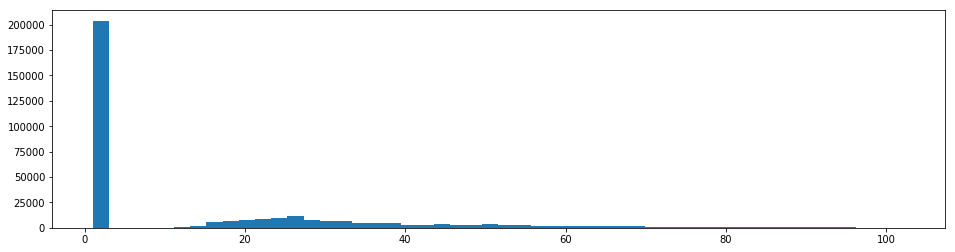

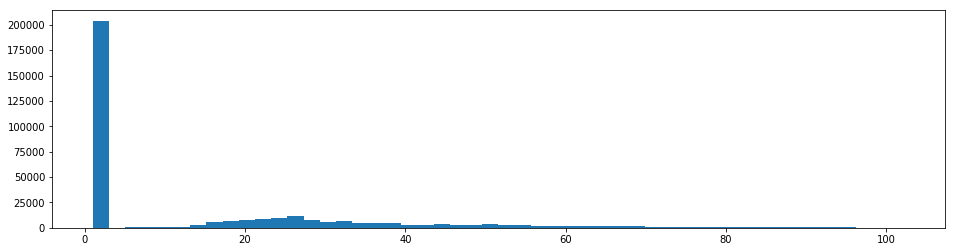

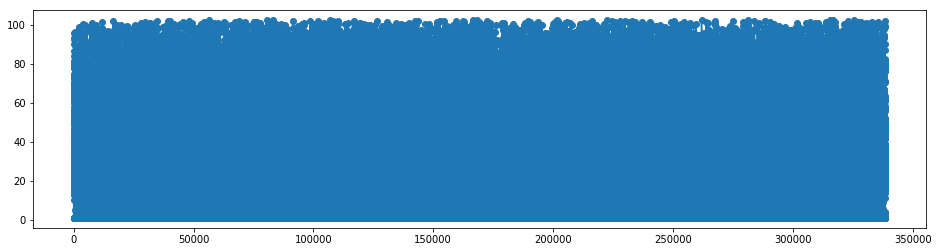

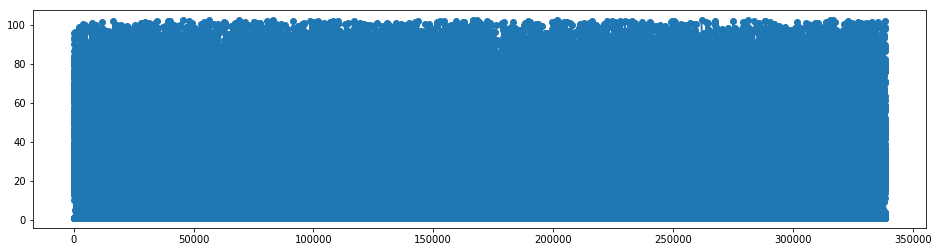

In [130]:
col1 = 'PRI.SANCTIONED.AMOUNT'
col2 = 'PRI.DISBURSED.AMOUNT'

plt.figure(figsize=(16,4))
_ = plt.hist(np.power(1+train_test[col1], 0.3), bins=50)

plt.figure(figsize=(16,4))
_ = plt.hist(np.power(1+train_test[col2], 0.3), bins=50)

plt.figure(figsize=(16,4))
_ = plt.plot(np.power(1+train_test[col1], 0.3),'-o')

plt.figure(figsize=(16,4))
_ = plt.plot(np.power(1+train_test[col2], 0.3),'-o')


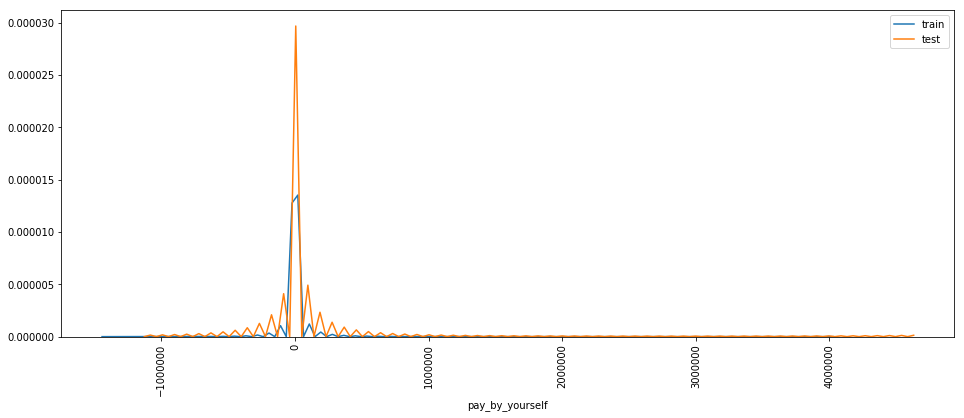

In [23]:
col1 = 'PRI.SANCTIONED.AMOUNT'
col2 = 'PRI.DISBURSED.AMOUNT'
train_test['pay_by_yourself'] = train_test[col2] - train_test[col1]
distplot_it(train_test, 'train_flag', 'pay_by_yourself')

In [133]:
remove_and_fill_outlier(train_test['pay_by_yourself'],'both')

low:  -54410.78    high:  4617.0
null count:  [6737]


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


array([0., 0., 0., ..., 0., 0., 0.])

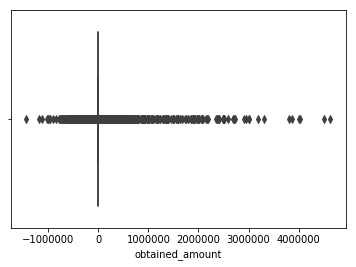

In [132]:
sns.boxplot(train_test['pay_by_yourself'])

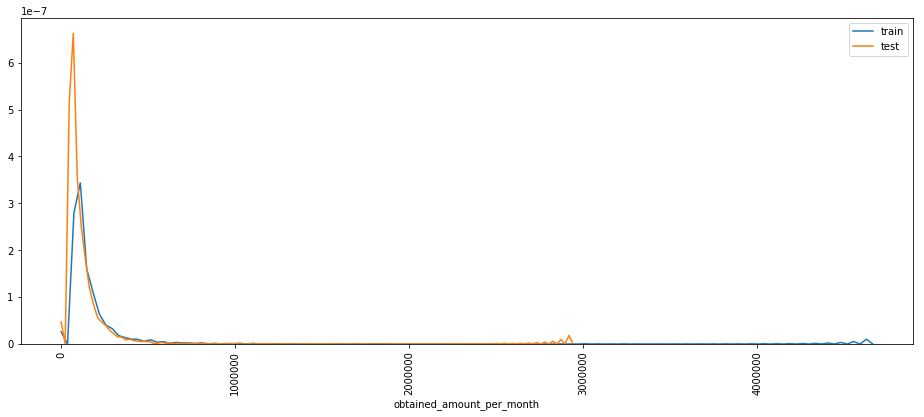

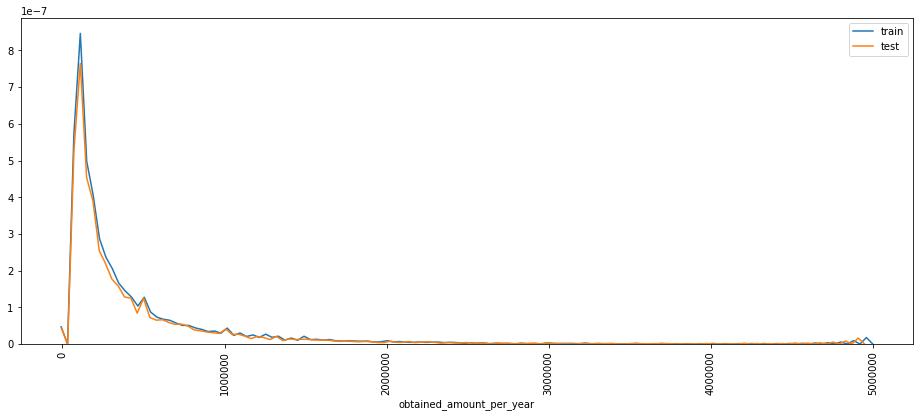

In [24]:
col1 = 'PRI.SANCTIONED.AMOUNT'
col2 = 'PRI.DISBURSED.AMOUNT'
train_test['obtained_amount_per_month'] = train_test[col2]/(1+\
                                                train_test['loan_tenure_total_month'])
train_test['obtained_amount_per_year'] = train_test[col2]/(1+\
                                                train_test['loan_tenure_year'])
distplot_it(train_test, 'train_flag', 'obtained_amount_per_month')
distplot_it(train_test, 'train_flag', 'obtained_amount_per_year')

In [25]:
col = 'PRI.ACTIVE.ACCTS'

bins = pd.IntervalIndex.from_tuples([(-1, 0),(0, 1),(1,3),(3,6),(6,10),(10,500)])
train_test['no_of_acc'] = pd.cut(train_test[col], bins)
print(train_test['no_of_acc'].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test['no_of_acc'] = le.fit_transform(train_test['no_of_acc'])
print(le.classes_)
print(train_test.groupby(['no_of_acc','loan_default'])['loan_default'].count().unstack())

train_test.drop(col, axis=1, inplace=True)


(-1, 0]      201626
(0, 1]        60667
(1, 3]        48174
(3, 6]        20000
(6, 10]        5218
(10, 500]      1190
Name: no_of_acc, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 6, closed='right')
 Interval(6, 10, closed='right') Interval(10, 500, closed='right')]
loan_default     0.0    1.0
no_of_acc                  
0             104024  30460
1              32111   8980
2              26103   6787
3              11576   2474
4               3256    549
5                779    126


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 23, 25]


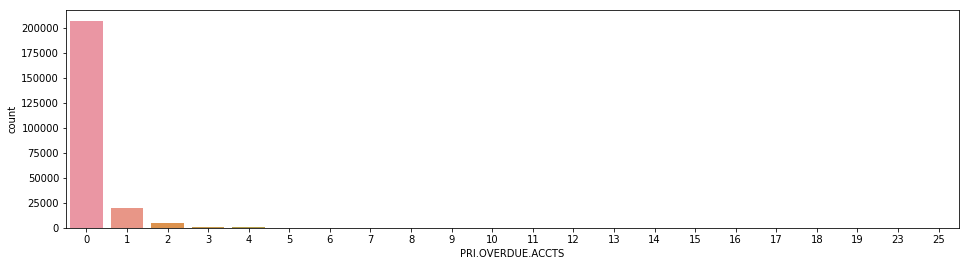

In [76]:
col = 'PRI.OVERDUE.ACCTS'
print(sorted(train_df[col].unique()))
plt.figure(figsize=(16,4))
sns.countplot(train_df[col])

# plt.figure(figsize=(16,4))
# sns.countplot(train_df[col][train_df[col] > 10])


In [77]:
no_of_acc = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
no_of_acc.columns = ['loan_0','loan_1']
no_of_acc#[no_of_acc.loan_0 < 10]

loan_0   loan_1
PRI.OVERDUE.ACCTS                   
0                  163471.0  43408.0
1                   14588.0   5382.0
2                    3061.0   1241.0
3                     841.0    361.0
4                     284.0    120.0
5                     118.0     48.0
6                      74.0     22.0
7                      31.0      7.0
8                      20.0      7.0
9                      21.0      4.0
10                      5.0      1.0
11                      8.0      4.0
12                      6.0      2.0
13                      4.0      1.0
14                      4.0      1.0
15                      1.0      NaN
16                      NaN      1.0
17                      2.0      NaN
18                      1.0      1.0
19                      1.0      NaN
23                      1.0      NaN
25                      1.0      NaN

In [26]:
col = 'PRI.OVERDUE.ACCTS'
new_col = 'no_of_acc_overdue'
bins = pd.IntervalIndex.from_tuples([(-1, 0),(0, 1),(1,2),(2,5),(5,500)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)
print(train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack())

train_test.drop(col, axis=1, inplace=True)


(-1, 0]     300156
(0, 1]       28266
(1, 2]        5859
(2, 5]        2340
(5, 500]       254
Name: no_of_acc_overdue, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 5, closed='right')
 Interval(5, 500, closed='right')]
loan_default          0.0    1.0
no_of_acc_overdue               
0                  159778  42474
1                   13982   5214
2                    2859   1182
3                    1084    476
4                     146     30


226849 233154


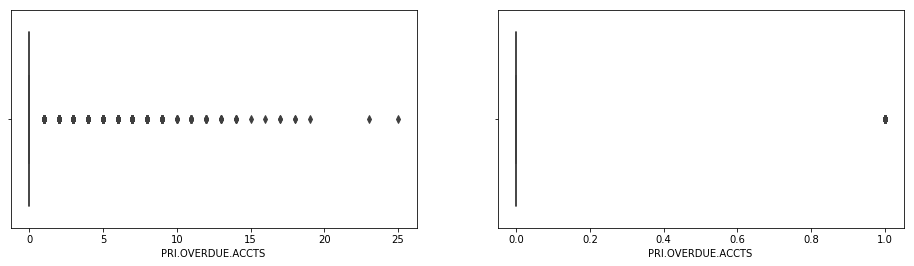

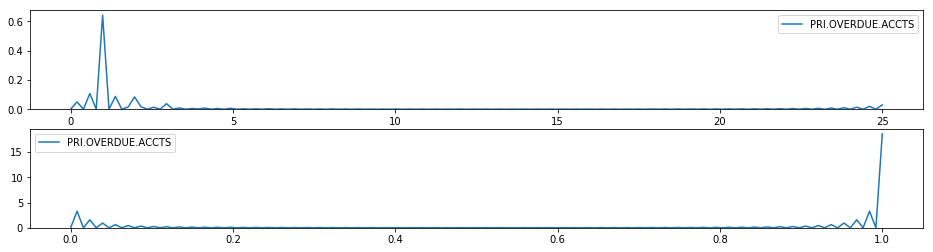

In [369]:
# col = cols[2]
# fig, ax = plt.subplots(1,2,figsize=(16,4))
# sns.boxplot(train_df[col], ax=ax[0])

# tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
# sns.boxplot(tp, ax=ax[1])
# print(tp.shape[0], train_df.shape[0])

# fig, ax = plt.subplots(2,1,figsize=(16,4))
# sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
# sns.kdeplot(tp, ax=ax[1])#,label='1')

/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


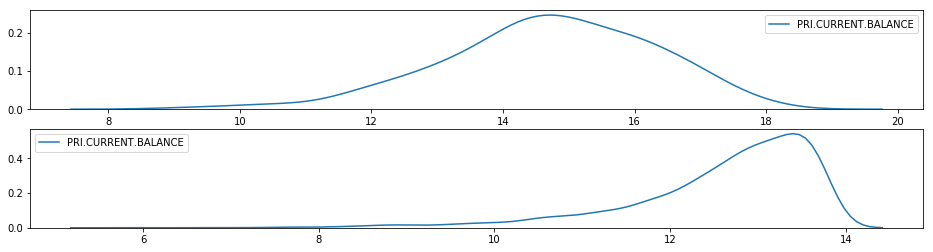

In [390]:
fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(np.log(2+train_df[col]+train_df[col].min()), ax=ax[0])#,label='0')
sns.kdeplot(np.log(2+tp+tp.min()), ax=ax[1])#,label='1')

## new feature, no of active accounts before and after loan, Please take care of noise in both cols

In [86]:
# train_df['diff_no_of_acc'] = (train_df_save[cols[1]] - train_df_save[cols[2]])
# train_df['diff_no_of_acc'].value_counts().sort_index()

-12          1
-11          2
-10          4
-9           4
-8           2
-7           5
-6           5
-5          11
-4          37
-3          84
-2         320
-1        2132
 0      144085
 1       39548
 2       19395
 3       10680
 4        6341
 5        3799
 6        2289
 7        1484
 8         958
 9         609
 10        404
 11        277
 12        195
 13        141
 14         84
 15         69
 16         44
 17         35
 18         28
 19         16
 20          9
 21          9
 22          7
 23         13
 24          5
 25          5
 26          1
 27          3
 28          2
 30          1
 31          3
 34          1
 35          2
 38          1
 41          1
 51          1
 64          1
 141         1
Name: diff_no_of_acc, dtype: int64

In [89]:
cols

['PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.CURRENT.BALANCE',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT']

In [90]:
# col = 'diff_no_of_acc'
# new_col = 'diff_of_acc'

# train_df[col] = (train_df_save['PRI.ACTIVE.ACCTS'] - train_df_save['PRI.OVERDUE.ACCTS'])
# test_df[col]  = (test_df_save['PRI.ACTIVE.ACCTS'] - test_df_save['PRI.OVERDUE.ACCTS'])

# bins = pd.IntervalIndex.from_tuples([(-50, -1), (-1, 0), (0, 1), (1, 4), (4, 500)])
# train_df[new_col] = pd.cut(train_df[col], bins)
# test_df[new_col] = pd.cut(test_df[col], bins)
# print(train_df[new_col].value_counts())

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(list(train_df[new_col]) + list(test_df[new_col]))
# print(le.classes_)
# train_df[new_col] = le.transform(train_df[new_col])
# test_df[new_col]  = le.transform(test_df[new_col])

# print(train_df.groupby([new_col,'loan_default'])['loan_default'].count().unstack())

# train_df.drop(col, axis=1, inplace=True)
# test_df.drop(col, axis=1, inplace=True)


(-1, 0]      144085
(0, 1]        39548
(1, 4]        36416
(4, 500]      10498
(-50, -1]      2607
Name: diff_of_acc, dtype: int64
[Interval(-50, -1, closed='right') Interval(-1, 0, closed='right')
 Interval(0, 1, closed='right') Interval(1, 4, closed='right')
 Interval(4, 500, closed='right')]
loan_default       0      1
diff_of_acc                
0               1891    716
1             110678  33407
2              31347   8201
3              29560   6856
4               9067   1431


In [ ]:
# Application amount: This is the amount you are applying for. You might want to apply for a loan of 40 lakhs to pursue your higher studies.
# Sanctioned amount: This is the amount that the bank has approved you for after their due diligence. This will be less than or equal to the application amount. In the case mentioned above, it might happen that the bank can only approve you for a loan for 30 lakhs due to any number of reasons.
# Disbursed amount: The amount that has been used from the sanctioned amount. It might happen that you were approved for 30 lakhs. But you received a scholarship, or decided to use your savings to fund your education. You only take 5 lakhs from the bank as the loan. This is the disbursed amount
    
25 	PRI.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	The outstanding amount is the Total due of your loan that you need to pay to the bank including interest and principal till date. Its nothing but the total loan amount sanctioned minus the pricipal part part of ur EMI.
26 	PRI.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
27 	PRI.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo... 	NaN


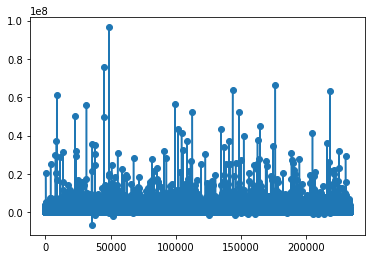

In [140]:
# col = cols[3]

plt.plot(train_df['PRI.CURRENT.BALANCE'],'-o')

In [144]:
np.percentile(train_df['PRI.CURRENT.BALANCE'], q=1), \
np.percentile(train_df['PRI.CURRENT.BALANCE'], q=99),\
train_df[train_df['PRI.CURRENT.BALANCE']>2917900].shape,\
test_df[test_df['PRI.CURRENT.BALANCE']>2917900].shape,\
train_test[train_test['PRI.CURRENT.BALANCE']>2917900].shape

(0.0, 2917864.330000001, (2332, 41), (957, 40), (1559, 61))

In [27]:
print(train_test.shape[0], "==>", end=" ")
train_test = train_test[train_test['PRI.CURRENT.BALANCE']<2917864]
train_test = train_test[train_test['PRI.CURRENT.BALANCE']>=0]
print(train_test.shape[0])

336875 ==> 334666


In [92]:
# train_df[train_df[col]>4000000][[col,cols[4],cols[5],'loan_default']]
train_df[train_df[col]>3000000]['loan_default'].value_counts()


0    1926
1     301
Name: loan_default, dtype: int64

# Drop all the rows with income more than `30Lakh`, which is only 1% of data, will not hurt too much(I guess)

In [95]:
100*train_df[train_df[col]>3000000][[col,cols[4],cols[5],'loan_default']].shape[0]/train_df.shape[0],\
100*test_df[test_df[col]>3000000][[col,cols[4],cols[5]]].shape[0]/test_df.shape[0]

(0.9551626821757293, 0.8078866823261442)

In [96]:
100*train_df[train_df[col]<0][[col,cols[4],cols[5]]].shape[0]/train_df.shape[0],\
100*test_df[test_df[col]<0][[col,cols[4],cols[5]]].shape[0]/test_df.shape[0]


(0.19214767921631196, 0.19396398320165137)

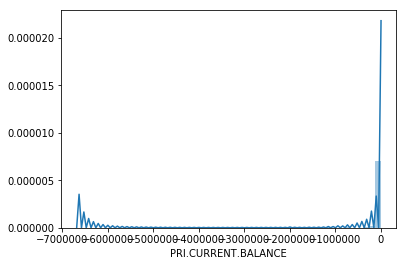

In [108]:
# plt.plot(train_df[train_df[col]<0][col],'-o')#[[col,cols[4],cols[5],'loan_default']]
sns.distplot(train_df[train_df[col]<0][col])

In [123]:
train_df[train_df[col]<0].shape, test_df[test_df[col]<0].shape,\
train_df[train_df[col]<-10000].shape, test_df[test_df[col]<-10000].shape

((448, 49), (218, 48), (98, 49), (47, 48))

0    383
1     65
Name: loan_default, dtype: int64

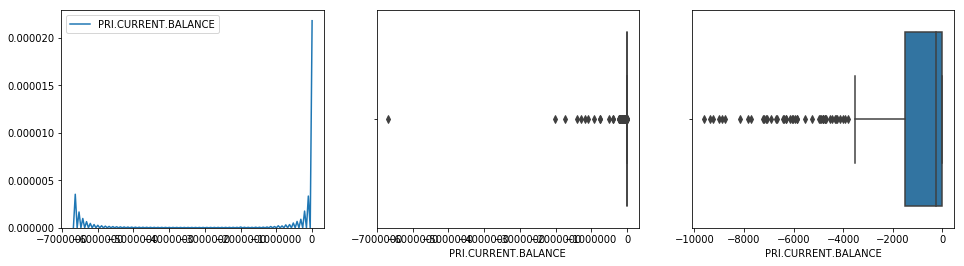

In [129]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.kdeplot(train_df[train_df[col]<0][col], ax=ax[0])
sns.boxplot(train_df[train_df[col]<0][col], ax=ax[1])
sns.boxplot(train_df[(train_df[col]<0)&(train_df[col]>-10000)][col], ax=ax[2])

train_df[train_df[col]<0]['loan_default'].value_counts()

In [133]:
# train_df[(train_df[col]<0)&(train_df[col]>-10000)][col]
def apply_income(x):
    if x>-10000:
        return x
    else:
        return -10000
train_df[col].apply(lambda x: apply_income(x)).value_counts()

# Or this and better
# train_df[col].apply(lambda x: x if x>-10000 else -10000).value_counts()

 0          141696
 800           121
 400           119
 30000         100
-10000          98
 50000          84
 100000         83
 40000          77
 25000          73
 20000          66
 60000          61
 35000          57
 10000          55
 5000           54
 1200           50
 2000           48
 3000           45
 15000          44
 1              43
 58000          42
 1600           41
 12000          40
 1500           40
 6000           40
 55000          39
 70000          39
 10             38
 52000          35
 48000          34
 200000         33
             ...  
 19520           1
 21571           1
 27716           1
 167333          1
 1496211         1
 140429          1
 660619          1
 154754          1
 126068          1
 765712          1
 341103          1
 601196          1
 66665           1
 593000          1
 95335           1
 97382           1
 1928292         1
 601392          1
 42077           1
 44124           1
 302170          1
 33881      

In [139]:
# train_df['negative_income'] = train_df[col].apply(lambda x: 1 if x<1 else 0)
# test_df['negative_income']  = test_df[col].apply(lambda x: 1 if x<1 else 0)

# col = 'PRI.CURRENT.BALANCE'
# new_col = 'income_status'

# bins = pd.IntervalIndex.from_tuples([(-1e9,-1),(-1,0),(0,10000),(10000,500000), 
#                                      (500000, 3000000), (3000000,1e11)])
# train_df[new_col] = pd.cut(train_df[col], bins)
# test_df[new_col] = pd.cut(test_df[col], bins)
# print(train_df[new_col].value_counts())

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(list(train_df[new_col]) + list(test_df[new_col]))
# print(le.classes_)
# train_df[new_col] = le.transform(train_df[new_col])
# test_df[new_col]  = le.transform(test_df[new_col])

# print(train_df.groupby([new_col,'loan_default'])['loan_default'].count().unstack())


(-1.0, 0.0]                    141696
(10000.0, 500000.0]             59566
(0.0, 10000.0]                  14611
(500000.0, 3000000.0]           14606
(3000000.0, 100000000000.0]      2227
(-1000000000.0, -1.0]             448
Name: income_status, dtype: int64
[Interval(-1000000000.0, -1.0, closed='right')
 Interval(-1.0, 0.0, closed='right')
 Interval(0.0, 10000.0, closed='right')
 Interval(10000.0, 500000.0, closed='right')
 Interval(500000.0, 3000000.0, closed='right')
 Interval(3000000.0, 100000000000.0, closed='right')]
loan_default        0      1
income_status               
0                 383     65
1              109716  31980
2               11539   3072
3               46652  12914
4               12327   2279
5                1926    301


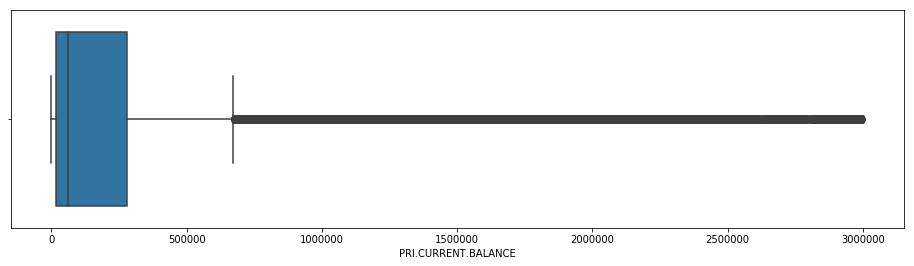

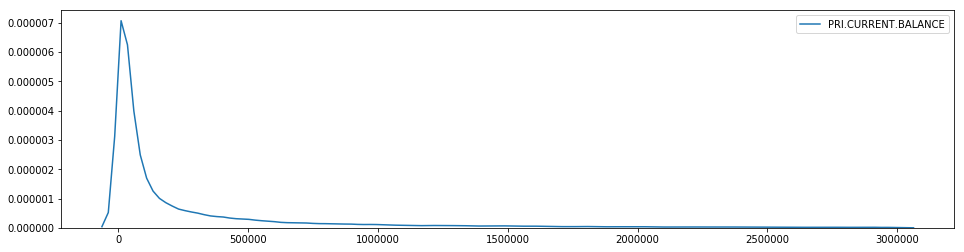

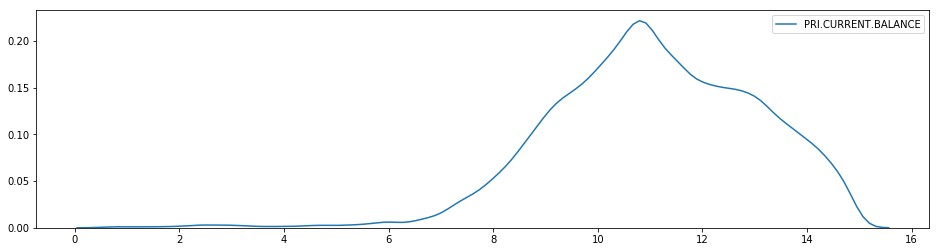

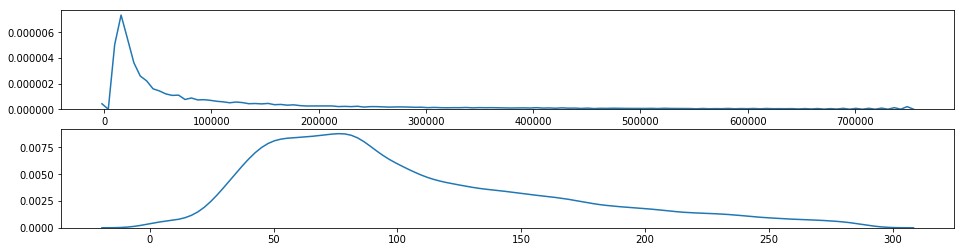

In [145]:
fig, ax = plt.subplots(figsize=(16,4))
sns.boxplot(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col], ax=ax)

fig, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col])


# fig, ax = plt.subplots(figsize=(16,4))
# sns.kdeplot(boxcox(train_df[col]-train_df[col].min()+1)[0])



fig, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(np.log(1+train_df[(train_df[col]<3000000) & (train_df[col]>0)][col]))

# scipy.stats.boxcox(x, lmbda=None, alpha=None)
# y = (x**lmbda - 1) / lmbda,  for lmbda > 0
#     log(x),                  for lmbda = 0
# def boxcox_func(x, lambda_):
#     return x**lambda_ -1
from scipy.stats import boxcox
fig, ax = plt.subplots(2,1, figsize=(16,4))
sns.kdeplot(boxcox(train_df[(train_df[col]<3000000) & 
                            (train_df[col]>-10000)][col]+10000,0.9), ax=ax[0])
sns.kdeplot(boxcox(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col],0.3), ax=ax[1])
# boxcox(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col])

230914 233154
-6678296 96524920 -2018309 2990946


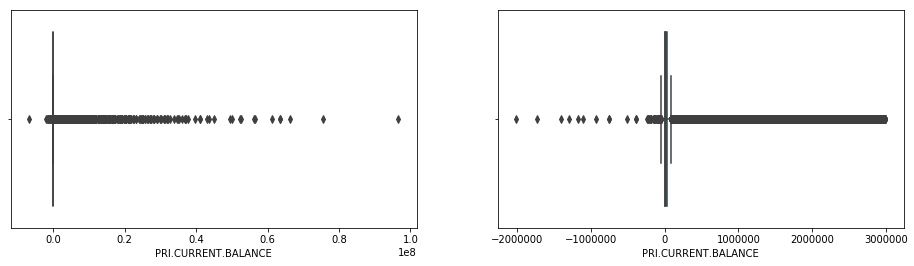

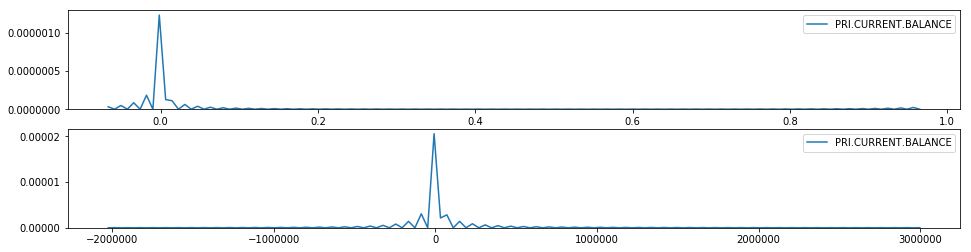

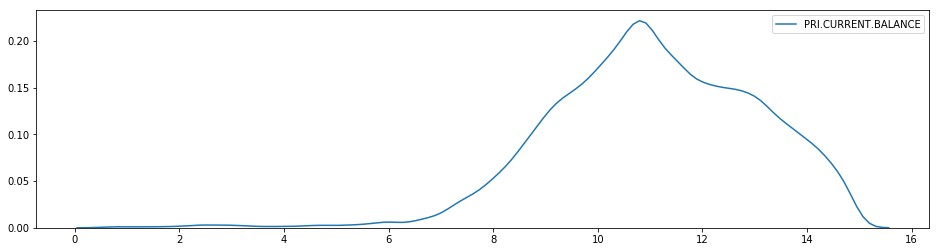

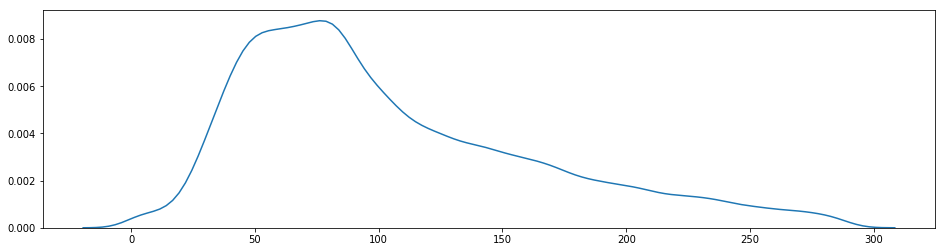

In [518]:
col = cols[3]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
# tp = pd.DataFrame(tp, columns=[col])
# tp = tp[col][(np.abs(stats.zscore(tp[[col]])) < 3).all(axis=1)]

sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])
print(train_df[col].min(), train_df[col].max(), tp.min(), tp.max())

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

fig, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(np.log(1+train_df[(train_df[col]<3000000) & (train_df[col]>0)][col]))

from scipy.stats import boxcox
fig, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(boxcox(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col],0.3))
# boxcox(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col])

PRI.SANCTIONED.AMOUNT
232537 233154


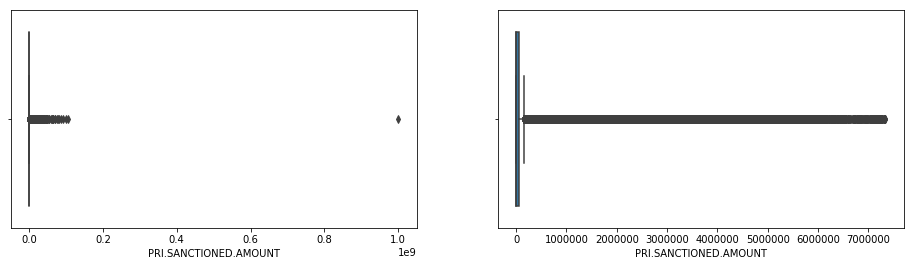

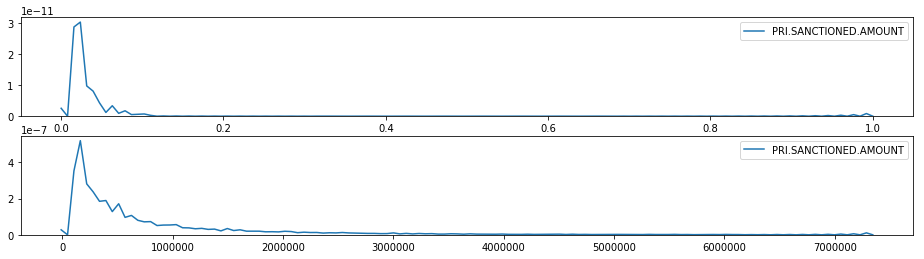

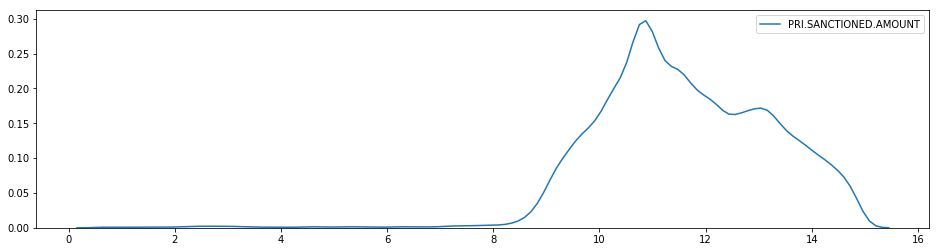

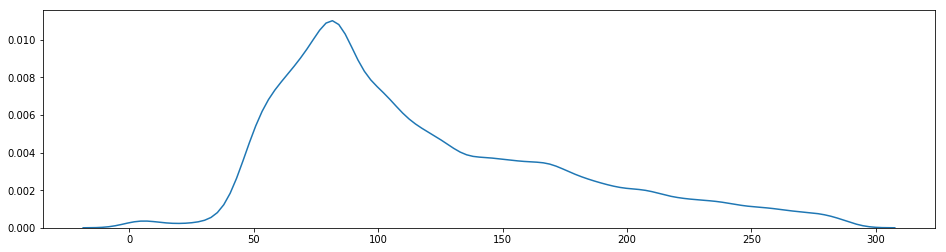

In [520]:
col = cols[4]
print(col)
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

fig, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(np.log(1+train_df[(train_df[col]<3000000) & (train_df[col]>0)][col]))

# scipy.stats.boxcox(x, lmbda=None, alpha=None)
# y = (x**lmbda - 1) / lmbda,  for lmbda > 0
#     log(x),                  for lmbda = 0
# def boxcox_func(x, lambda_):
#     return x**lambda_ -1
from scipy.stats import boxcox
fig, ax = plt.subplots(figsize=(16,4))
sns.kdeplot(boxcox(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col],0.3))
# boxcox(train_df[(train_df[col]<3000000) & (train_df[col]>0)][col])

232538 233154


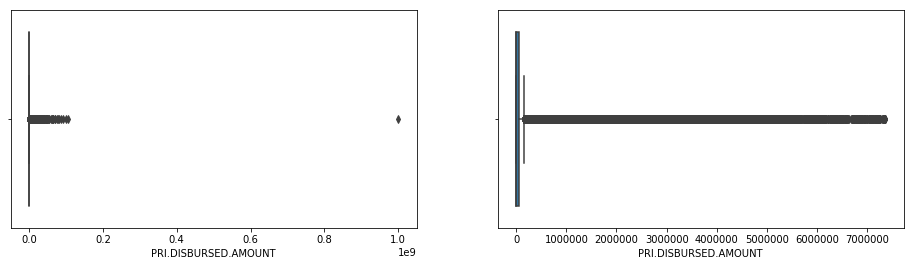

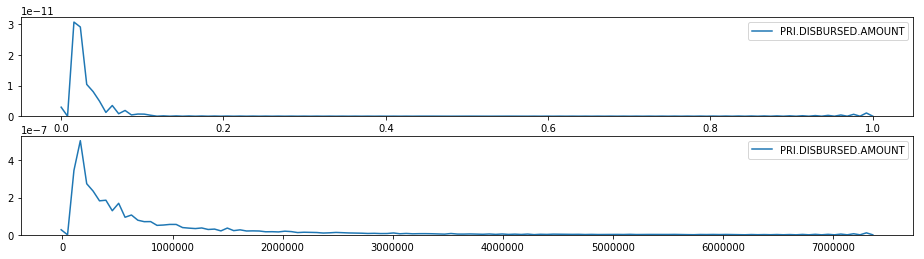

In [372]:
col = cols[5]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

In [148]:
cols[5]

'PRI.DISBURSED.AMOUNT'

In [529]:
train_df[train_df[cols[3]] > 0][[cols[3],cols[4],cols[5]]].shape, train_df.shape

((91010, 3), (233154, 47))

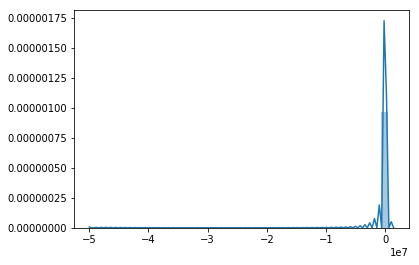

In [532]:
sns.distplot(train_df[train_df[cols[3]] > 0][cols[4]]-train_df[train_df[cols[3]] > 0][cols[5]])

/home/ankish/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ankish/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


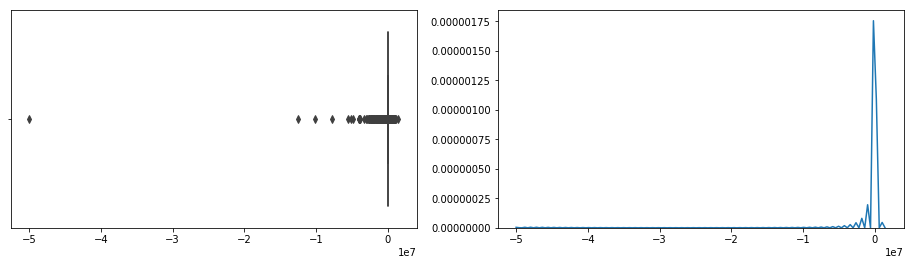

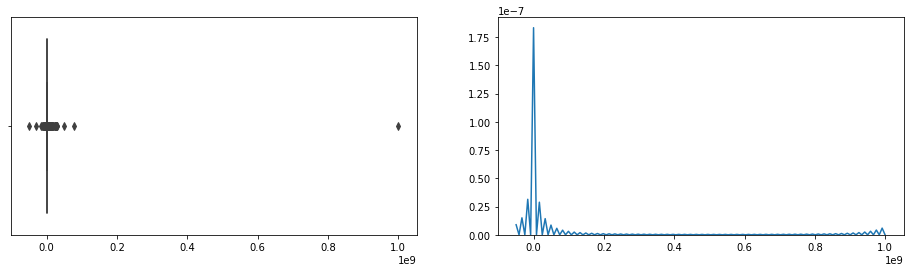

In [528]:
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[cols[4]]-train_df[cols[5]], ax=ax[0])
sns.kdeplot(train_df[cols[4]]-train_df[cols[5]], ax=ax[1])#,label='0')

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[train_df[cols[3]] > 0][cols[4]]-train_df[train_df[cols[5]] > 0][cols[3]], ax=ax[0])
sns.kdeplot(train_df[train_df[cols[3]] > 0][cols[4]]-train_df[train_df[cols[5]] > 0][cols[3]], ax=ax[1])#,label='0')


In [527]:
cols

['PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.CURRENT.BALANCE',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT']

231883 233154


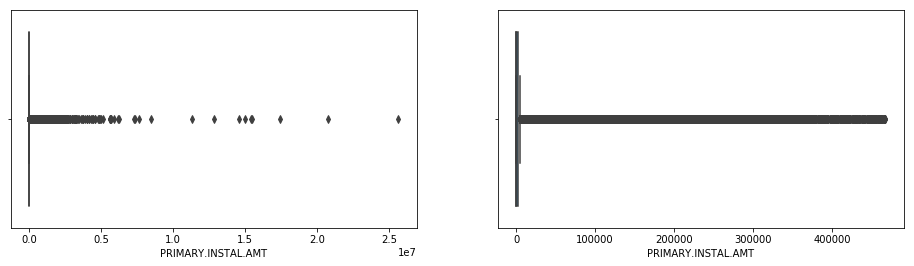

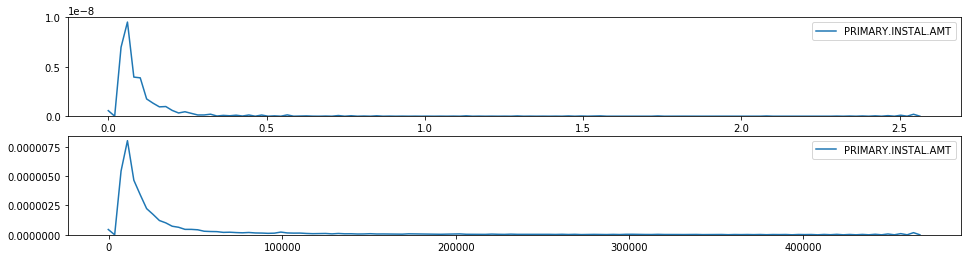

In [373]:
col = cols[6]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

In [37]:
train_test.drop('MobileNo_Avl_Flag', axis=1, inplace=True)


low:  0.0    high:  5700.0
null count:  [3408]


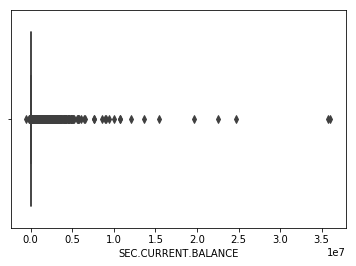

In [45]:
remove_and_fill_outlier(train_test['SEC.CURRENT.BALANCE'],'both')
sns.boxplot(train_test['SEC.CURRENT.BALANCE'])

In [54]:
col = 'SEC.CURRENT.BALANCE'
train_df[train_df[col] > 5700].shape, \
test_df[test_df[col] > 5700].shape, \
train_test[train_test[col] > 5700].shape,\
train_test[train_test[col] > 10000].shape,\
train_test[train_test[col] < 0].shape

((2850, 41), (644, 40), (3346, 60), (3097, 60), (62, 60))

In [58]:
col = 'SEC.DISBURSED.AMOUNT'
remove_and_fill_outlier(train_test[col],'both')

# col = 'SEC.CURRENT.BALANCE'
train_df[train_df[col] > 30000].shape, \
test_df[test_df[col] > 30000].shape, \
train_test[train_test[col] > 30000].shape,\
train_test[train_test[col] > 30000].shape,\
train_test[train_test[col] < 0].shape

low:  0.0    high:  30000.0
null count:  [3325]


((2819, 41), (646, 40), (3325, 60), (3325, 60), (0, 60))

In [66]:
col1 = 'SEC.CURRENT.BALANCE'
col2 = 'SEC.DISBURSED.AMOUNT'

train_test[(train_test[col1] >= 0) & (train_test[col1] < 10000) & \
           (train_test[col2] < 30000) & (train_test[col2] >= 0)].shape, \
train_test.shape, \
train_test[(train_test[col1] >= 0) & (train_test[col1] < 10000)].shape


((331026, 60), (334666, 60), (331506, 60))

In [69]:
print(train_test.shape[0], "==>", end=" ")
train_test = train_test[train_test['SEC.CURRENT.BALANCE']<10000]
train_test = train_test[train_test['SEC.CURRENT.BALANCE']>=0]
print(train_test.shape[0])

print(train_test.shape[0], "==>", end=" ")
train_test = train_test[train_test['SEC.DISBURSED.AMOUNT']<30000]
train_test = train_test[train_test['SEC.DISBURSED.AMOUNT']>=0]
print(train_test.shape[0])

334666 ==> 331506
331506 ==> 331026


In [88]:
print(train_test.shape[0], "==>", end=" ")
drop_cols = ['SEC.OVERDUE.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.NO.OF.ACCTS', 'VoterID_flag', 
             'Driving_flag', 'Passport_flag']
train_test.drop(drop_cols, axis=1, inplace=True)
print(train_test.shape[0])



331026 ==> 331026


In [95]:
print(train_test.shape[0], "==>", end=" ")
train_test = train_test[train_test['PRIMARY.INSTAL.AMT']<202000]
train_test = train_test[train_test['PRIMARY.INSTAL.AMT']>=0]
print(train_test.shape[0])

train_test.drop('SEC.INSTAL.AMT', axis=1, inplace=True)

331026 ==> 327714


In [94]:
# plt.plot(train_test['PRIMARY.INSTAL.AMT'],'-o')
col = 'PRIMARY.INSTAL.AMT'
print(np.percentile(train_test[col], q=1))
print(np.percentile(train_test[col], q=99))

col = 'SEC.INSTAL.AMT'
print(np.percentile(train_test[col], q=1))
print(np.percentile(train_test[col], q=99.1))


0.0
202000.0
0.0
0.0


In [85]:
col = 'SEC.SANCTIONED.AMOUNT'
print(np.percentile(train_test[col], q=99.7))
# remove_and_fill_outlier(train_test[col],'both')

train_df[train_df[col] > 10000].shape, \
test_df[test_df[col] > 10000].shape, \
train_test[train_test[col] > 10000].shape,\
train_test[train_test[col] > 10000].shape,\
train_test[train_test[col] < 0].shape

0.0


((3475, 41), (783, 40), (492, 60), (492, 60), (0, 60))

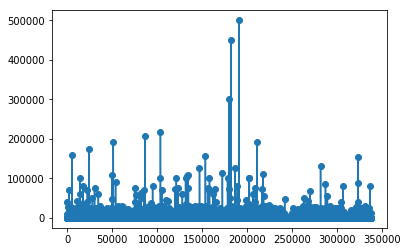

In [72]:
plt.plot(train_test[col],'-o')

In [ ]:
print(train_test.shape[0], "==>", end=" ")
train_test = train_test[train_test['SEC.CURRENT.BALANCE']<10000]
train_test = train_test[train_test['SEC.CURRENT.BALANCE']>=0]
print(train_test.shape[0])

In [97]:
train_test['NO.OF_INQUIRIES'].value_counts()

0     283166
1      31800
2       7695
3       2501
4       1134
5        498
6        349
7        200
8        138
9         65
10        50
12        26
11        25
13        14
14        11
15         9
17         8
19         6
16         4
18         4
21         3
20         2
22         2
23         2
28         1
36         1
Name: NO.OF_INQUIRIES, dtype: int64

In [99]:
train_test['NO.OF_INQUIRIES'][train_test['NO.OF_INQUIRIES'] != 0] = 1
train_test['NO.OF_INQUIRIES'].value_counts()

0    283166
1     44548
Name: NO.OF_INQUIRIES, dtype: int64

In [119]:
((train_test['DisbursalDate_new'] - train_test['date_of_birth'])/30)/ np.timedelta64(1, 'D')

0         421.100000
1         403.666667
2         401.000000
3         302.200000
4         499.633333
5         342.266667
6         373.933333
7         358.366667
9         617.200000
10        483.866667
11        415.800000
12        543.566667
13        414.400000
14        554.333333
15        297.800000
16        519.866667
17        432.966667
18        364.166667
19        468.566667
20        496.400000
21        419.933333
22        295.066667
23        478.466667
24        360.433333
25        399.266667
26        615.066667
27        520.766667
28        558.466667
29        599.366667
30        544.766667
31        344.933333
32        641.400000
33        268.600000
34        506.500000
35        309.700000
37        338.800000
38        503.266667
39        267.500000
40        605.600000
41        307.900000
42        442.400000
43        349.300000
44        509.166667
45        344.900000
46        313.300000
47        399.066667
48        542.200000
49        463

In [117]:
train_test['age(in years)'] = ((train_test['DisbursalDate_new'] - \
                    train_test['date_of_birth'])/365) / np.timedelta64(1, 'D')
train_test['age(in years)'] = train_test['age(in years)'].astype('int')
train_test['age(in years)'][:5]

0    34
1    33
2    32
3    24
4    41
Name: age(in years), dtype: int64

In [120]:
train_test['age(in month)'] = ((train_test['DisbursalDate_new'] - \
                    train_test['date_of_birth'])/30) / np.timedelta64(1, 'D')
train_test['age(in month)'] = train_test['age(in years)'].astype('int')
train_test['age(in month)'][:5]

0    34
1    33
2    32
3    24
4    41
Name: age(in month), dtype: int64

In [124]:
col = 'NEW.ACCTS.IN.LAST.SIX.MONTHS'
train_test[col].value_counts()

0     262172
1      42176
2      13823
3       5226
4       2146
5        996
6        494
7        292
8        139
9         76
10        64
11        38
12        21
13        13
14        11
17         7
15         4
16         4
19         3
22         2
18         2
20         2
23         2
21         1
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [132]:
col = 'NEW.ACCTS.IN.LAST.SIX.MONTHS'
new_col = 'new_acc_past_month'

bins = pd.IntervalIndex.from_tuples([(-1,0),(0,1),(1,2),(2,3),(3,4),(4,50)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)

train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack()
train_test.drop(col, axis=1, inplace=True)

(-1, 0]    262172
(0, 1]      42176
(1, 2]      13823
(2, 3]       5226
(4, 50]      2171
(3, 4]       2146
Name: new_acc_past_month, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 3, closed='right')
 Interval(3, 4, closed='right') Interval(4, 50, closed='right')]


In [128]:
train_test['PRI.NO.OF.ACCTS'].value_counts()

0      170635
1       49740
2       27790
3       18314
4       12820
5        9672
6        7341
7        5757
8        4600
9        3644
10       2929
11       2375
12       1931
13       1631
14       1325
15       1057
16        890
17        744
18        629
19        554
20        457
21        375
22        336
24        267
23        243
25        199
26        165
28        135
27        129
29        114
30        102
31         94
33         66
32         66
34         61
35         59
38         43
36         38
40         34
37         34
39         31
41         25
42         23
43         23
45         15
46         14
50         12
47         12
49         11
44         10
51          8
62          8
48          6
60          6
52          6
55          6
56          6
59          6
54          5
53          4
57          4
58          4
61          4
63          4
65          4
68          4
76          3
77          3
78          3
72          3
93          3
66    

In [133]:
col = 'PRI.NO.OF.ACCTS'
new_col = 'pri_no_of_accts'

bins = pd.IntervalIndex.from_tuples([(-1,0),(0,1),(1,2),(2,3),(3,4),(4,8),(8,15),(15,1000)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)

train_test.drop(col, axis=1, inplace=True)
train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack()


(-1, 0]       170635
(0, 1]         49740
(1, 2]         27790
(4, 8]         27370
(2, 3]         18314
(8, 15]        14892
(3, 4]         12820
(15, 1000]      6153
Name: pri_no_of_accts, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 3, closed='right')
 Interval(3, 4, closed='right') Interval(4, 8, closed='right')
 Interval(8, 15, closed='right') Interval(15, 1000, closed='right')]


loan_default       0.0    1.0
pri_no_of_accts              
0                87727  26374
1                26030   7414
2                14662   4030
3                 9738   2495
4                 6966   1675
5                15086   3600
6                 8358   1883
7                 3576    762

In [135]:
train_test.to_csv('store_data/train_test_5.csv',index=None)

train_unique_id = train_df[['UniqueID']]
test_unique_id = test_df[['UniqueID']]

train_df1 = pd.merge(train_unique_id, train_test, on='UniqueID', how='left')
print(train_df.shape, "==>", train_df1.shape)

test_df1 = pd.merge(test_unique_id, train_test, on='UniqueID', how='left')
print(test_df.shape, "==>", test_df1.shape)

(233154, 41) ==> (233154, 55)
(112392, 40) ==> (112392, 55)


In [136]:
train_df1.isnull().sum()

UniqueID                                   0
AVERAGE.ACCT.AGE                       12778
Aadhar_flag                            12778
CREDIT.HISTORY.LENGTH                  12778
Current_pincode_ID                     12778
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    12778
DisbursalDate                          12778
Employee_code_ID                       12778
Employment.Type                        12778
NO.OF_INQUIRIES                        12778
PAN_flag                               12778
PRI.CURRENT.BALANCE                    12778
PRI.DISBURSED.AMOUNT                   12778
PRI.SANCTIONED.AMOUNT                  12778
PRIMARY.INSTAL.AMT                     12778
SEC.CURRENT.BALANCE                    12778
SEC.DISBURSED.AMOUNT                   12778
SEC.SANCTIONED.AMOUNT                  12778
State_ID                               12778
asset_cost                             12778
branch_id                              12778
disbursed_amount                       12778
loan_defau

In [137]:
test_df1.isnull().sum()

UniqueID                                    0
AVERAGE.ACCT.AGE                         5054
Aadhar_flag                              5054
CREDIT.HISTORY.LENGTH                    5054
Current_pincode_ID                       5054
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      5054
DisbursalDate                            5054
Employee_code_ID                         5054
Employment.Type                          5054
NO.OF_INQUIRIES                          5054
PAN_flag                                 5054
PRI.CURRENT.BALANCE                      5054
PRI.DISBURSED.AMOUNT                     5054
PRI.SANCTIONED.AMOUNT                    5054
PRIMARY.INSTAL.AMT                       5054
SEC.CURRENT.BALANCE                      5054
SEC.DISBURSED.AMOUNT                     5054
SEC.SANCTIONED.AMOUNT                    5054
State_ID                                 5054
asset_cost                               5054
branch_id                                5054
disbursed_amount                  

In [139]:
[col for col in train_test.columns]

['AVERAGE.ACCT.AGE',
 'Aadhar_flag',
 'CREDIT.HISTORY.LENGTH',
 'Current_pincode_ID',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'DisbursalDate',
 'Employee_code_ID',
 'Employment.Type',
 'NO.OF_INQUIRIES',
 'PAN_flag',
 'PRI.CURRENT.BALANCE',
 'PRI.DISBURSED.AMOUNT',
 'PRI.SANCTIONED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'SEC.CURRENT.BALANCE',
 'SEC.DISBURSED.AMOUNT',
 'SEC.SANCTIONED.AMOUNT',
 'State_ID',
 'UniqueID',
 'asset_cost',
 'branch_id',
 'disbursed_amount',
 'loan_default',
 'ltv',
 'manufacturer_id',
 'supplier_id',
 'train_flag',
 'date_of_birth',
 'DisbursalDate_new',
 'disbursal_week',
 'disbursal_day',
 'disbursal_month',
 'credit_hist_year',
 'credit_hist_month',
 'credit_hist_total_month',
 'loan_tenure_year',
 'loan_tenure_month',
 'loan_tenure_total_month',
 'Bureau_desc',
 'bureau_score',
 'manufac_week_disbursed_mean',
 'state_week_disbursed_mean',
 'branch_week_disbursed_mean',
 'manufac_disbursed_mean',
 'state_disbursed_mean',
 'branch_disbursed_mean',
 'pay_by_yours

In [149]:
train_df_save1 = train_df.copy()
test_df_save1 = test_df.copy()

train_df_save.shape, train_df_save1.shape

((233154, 47), (233154, 51))

In [155]:

# target = train_df['loan_default']
# train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
# test_df.drop('UniqueID', axis=1, inplace=True)

train_df[['credit_hist_year','credit_hist_month','loan_tenure_year','loan_tenure_month']] = \
train_df[['credit_hist_year','credit_hist_month','loan_tenure_year','loan_tenure_month']].astype('int')
test_df[['credit_hist_year','credit_hist_month','loan_tenure_year','loan_tenure_month']] = \
test_df[['credit_hist_year','credit_hist_month','loan_tenure_year','loan_tenure_month']].astype('int')

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.5
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=50, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

# sub_df = pd.DataFrame({"ID_code":test_id})
# sub_df["target"] = predictions

# sub_df.columns = sub.columns
# sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

(174865,) (58289,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.660532	valid_1's auc: 0.64924
[100]	training's auc: 0.662125	valid_1's auc: 0.650493
[150]	training's auc: 0.663824	valid_1's auc: 0.651822
[200]	training's auc: 0.66611	valid_1's auc: 0.65321
[250]	training's auc: 0.669116	valid_1's auc: 0.655472
[300]	training's auc: 0.671336	valid_1's auc: 0.656946
[350]	training's auc: 0.673914	valid_1's auc: 0.658606
[400]	training's auc: 0.676017	valid_1's auc: 0.659976
[450]	training's auc: 0.678017	valid_1's auc: 0.661093
[500]	training's auc: 0.680351	valid_1's auc: 0.662147
[550]	training's auc: 0.682148	valid_1's auc: 0.663052
[600]	training's auc: 0.683902	valid_1's auc: 0.663925
[650]	training's auc: 0.68565	valid_1's auc: 0.664514
[700]	training's auc: 0.687061	valid_1's auc: 0.664931
[750]	training's auc: 0.688567	valid_1's auc: 0.665451
[800]	training's auc: 0.690017	valid_1's auc: 0.665962
[850]	training's auc: 0.691388	valid_

KeyboardInterrupt: 

<BarContainer object of 49 artists>

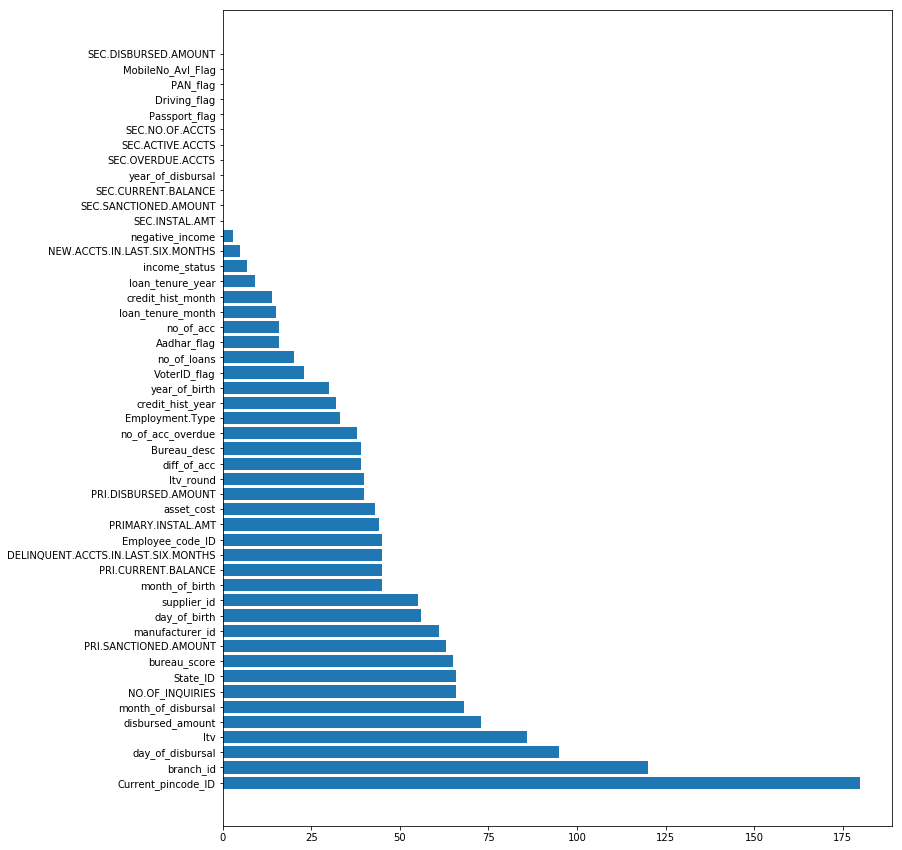

In [156]:
# lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
# lgb_imp.columns = ['feature','imp']
# lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
# plt.figure(figsize=(12,15))
# plt.barh(lgb_imp.feature, lgb_imp.imp)

In [160]:
del train_df, test_df
gc.collect()
train_df = train_df_save1.copy()
test_df = test_df_save1.copy()

# Let's investigate other columns

In [157]:
# 28 	SEC.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Secondary accounts are those which the custome...
# 29 	SEC.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 30 	SEC.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN

# 31 	SEC.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	NaN
# 32 	SEC.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 33 	SEC.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo...

cat_cols = ['SEC.ACTIVE.ACCTS', 'SEC.NO.OF.ACCTS','SEC.OVERDUE.ACCTS']
int_cols = ['SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT',
            'SEC.INSTAL.AMT','SEC.SANCTIONED.AMOUNT']

In [158]:
train_df[cat_cols].apply(lambda x: pd.Series.value_counts(x).shape[0])

SEC.ACTIVE.ACCTS     23
SEC.NO.OF.ACCTS      37
SEC.OVERDUE.ACCTS     9
dtype: int64

SEC.ACTIVE.ACCTS
(23, 3)


Text(0.5, 0.98, 'SEC.ACTIVE.ACCTS vs loan-default (in norm)')

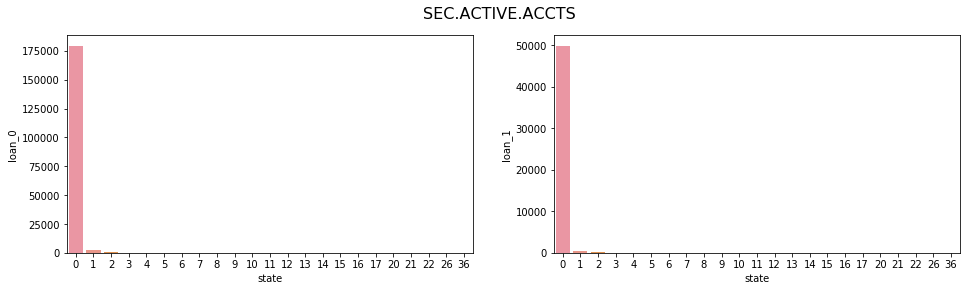

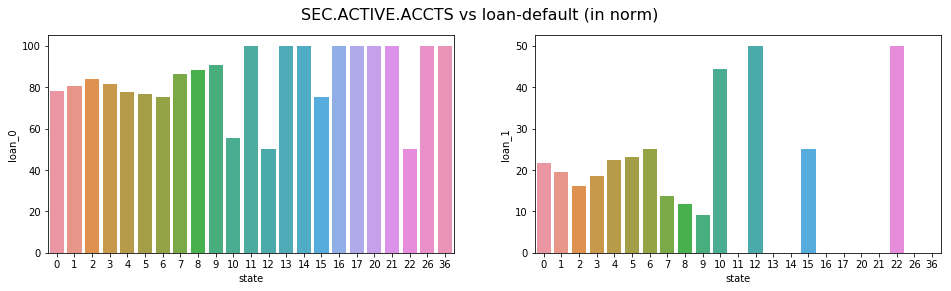

In [161]:
col = cat_cols[0]
print(col)
manufac_gps = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index
print(manufac_gps.shape)
# manufac_gps[['loan_0']] = 100*manufac_gps[['loan_0']]/train_df.shape[0]
# manufac_gps[['loan_1']] = 100*manufac_gps[['loan_1']]/train_df.shape[0]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col, fontsize=16)
    
    
manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col+' vs loan-default (in norm)', fontsize=16)


SEC.NO.OF.ACCTS
(37, 3)


Text(0.5, 0.98, 'SEC.NO.OF.ACCTS vs loan-default (in norm)')

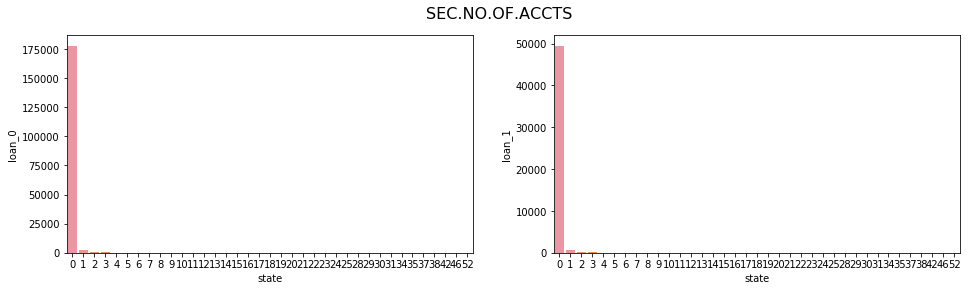

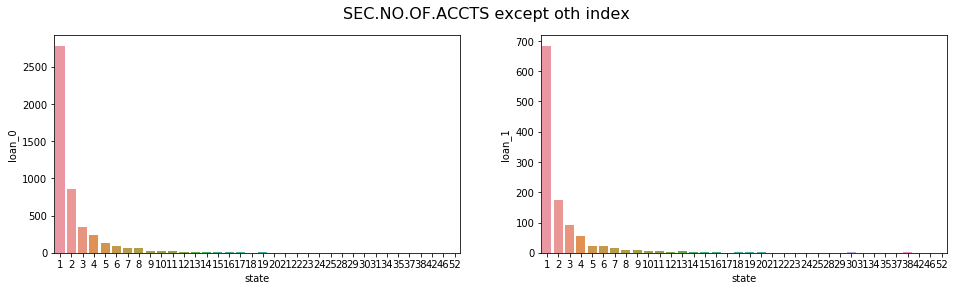

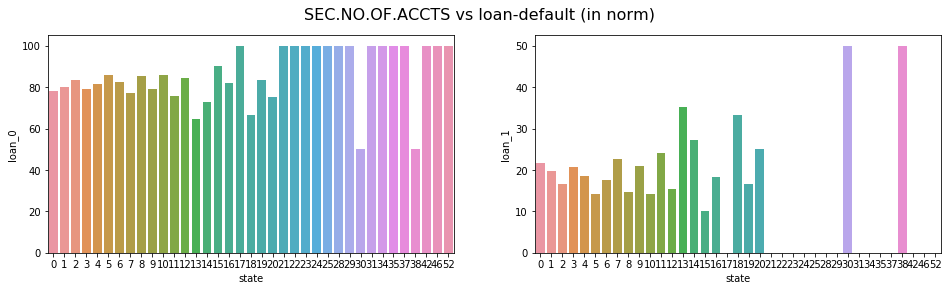

In [166]:
col = cat_cols[1]
print(col)
manufac_gps = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index
print(manufac_gps.shape)
# manufac_gps[['loan_0']] = 100*manufac_gps[['loan_0']]/train_df.shape[0]
# manufac_gps[['loan_1']] = 100*manufac_gps[['loan_1']]/train_df.shape[0]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col, fontsize=16)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps.iloc[1:,:], ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps.iloc[1:,:], ax=ax[1])#,label='1')
fig.suptitle(col+" except oth index", fontsize=16)

manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col+' vs loan-default (in norm)', fontsize=16)


SEC.OVERDUE.ACCTS
(9, 3)


Text(0.5, 0.98, 'SEC.OVERDUE.ACCTS vs loan-default (in norm)')

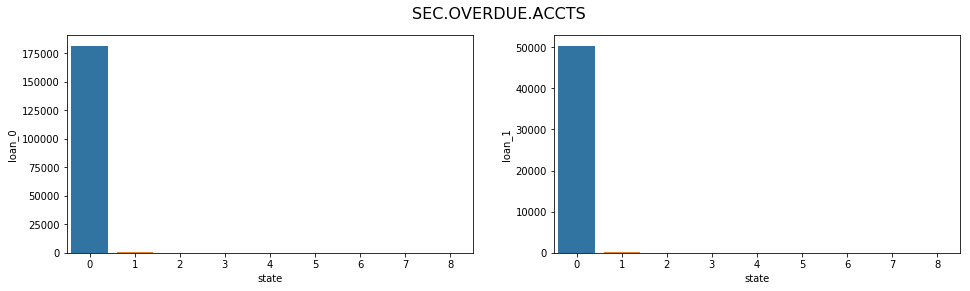

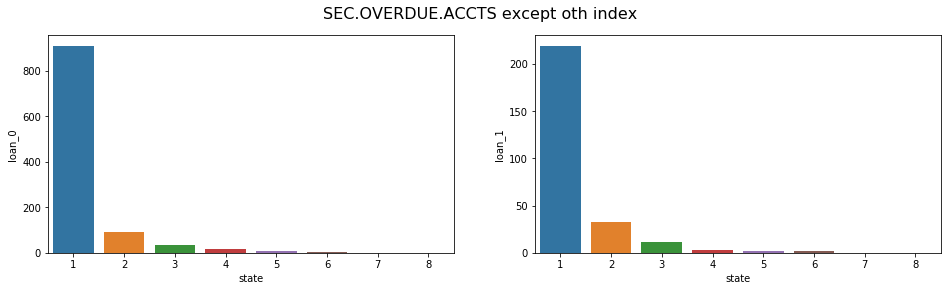

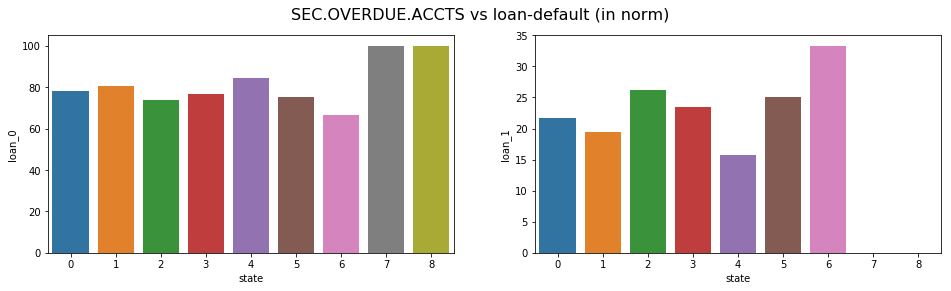

In [167]:
col = cat_cols[2]
print(col)
manufac_gps = train_df.groupby([col,'loan_default'])['loan_default'].count().unstack()
manufac_gps.columns = ['loan_0', 'loan_1']
manufac_gps['state'] = manufac_gps.index
print(manufac_gps.shape)
# manufac_gps[['loan_0']] = 100*manufac_gps[['loan_0']]/train_df.shape[0]
# manufac_gps[['loan_1']] = 100*manufac_gps[['loan_1']]/train_df.shape[0]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col, fontsize=16)


fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps.iloc[1:,:], ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps.iloc[1:,:], ax=ax[1])#,label='1')
fig.suptitle(col+" except oth index", fontsize=16)


manufac_gps[['loan_0','loan_1']] = 100*manufac_gps[['loan_0','loan_1']].apply(lambda x: x/x.sum(), axis=1)

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.barplot(x='state',y="loan_0", data=manufac_gps, ax=ax[0])#,label='0')
sns.barplot(x='state',y="loan_1", data=manufac_gps, ax=ax[1])#,label='1')
fig.suptitle(col+' vs loan-default (in norm)', fontsize=16)


In [168]:
train_df[cat_cols[0]].value_counts(), \
train_df[cat_cols[1]].value_counts(), \
train_df[cat_cols[2]].value_counts()

(0     229337
 1       2684
 2        636
 3        195
 4        116
 5         65
 6         32
 7         22
 8         17
 9         11
 10         9
 11         7
 12         6
 15         4
 13         3
 16         2
 22         2
 26         1
 14         1
 17         1
 20         1
 21         1
 36         1
 Name: SEC.ACTIVE.ACCTS, dtype: int64, 0     227289
 1       3466
 2       1036
 3        444
 4        292
 5        148
 6        119
 7         75
 8         68
 9         38
 10        35
 11        29
 13        17
 12        13
 16        11
 14        11
 15        10
 18         6
 19         6
 17         5
 20         4
 22         4
 23         4
 31         4
 21         3
 46         2
 24         2
 38         2
 30         2
 34         2
 37         1
 42         1
 28         1
 35         1
 29         1
 25         1
 52         1
 Name: SEC.NO.OF.ACCTS, dtype: int64, 0    231817
 1      1129
 2       126
 3        47
 4        19
 5         8
 6     

In [169]:
use_index = train_df[cat_cols[0]][train_df[cat_cols[0]]>0].index
train_df.loc[use_index, cat_cols[0]] = 1

use_index = train_df[cat_cols[1]][train_df[cat_cols[1]]>0].index
train_df.loc[use_index, cat_cols[1]] = 1

use_index = train_df[cat_cols[2]][train_df[cat_cols[2]]>0].index
train_df.loc[use_index, cat_cols[2]] = 1


# We need to categorize these `SEC` int columns

232642 233154


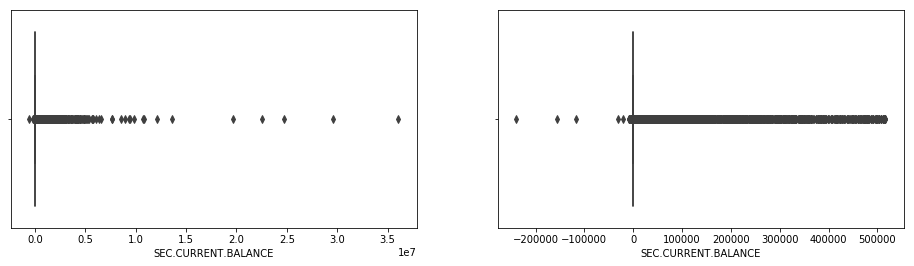

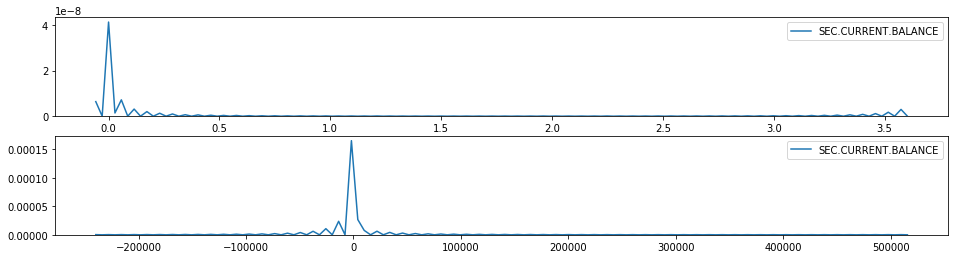

In [552]:
col = int_cols[0]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

232531 233154


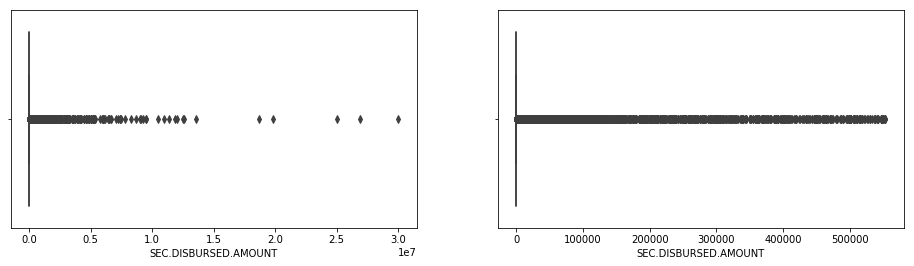

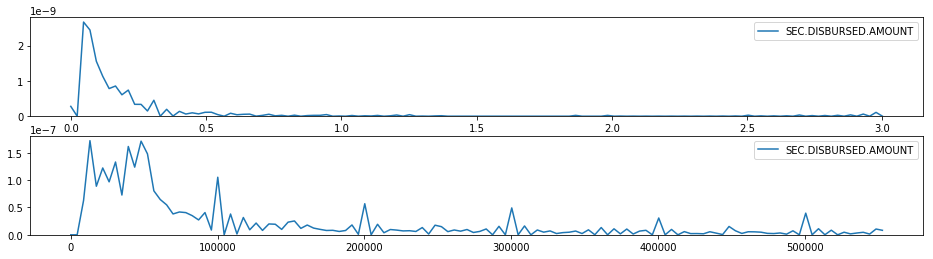

In [553]:
col = int_cols[1]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

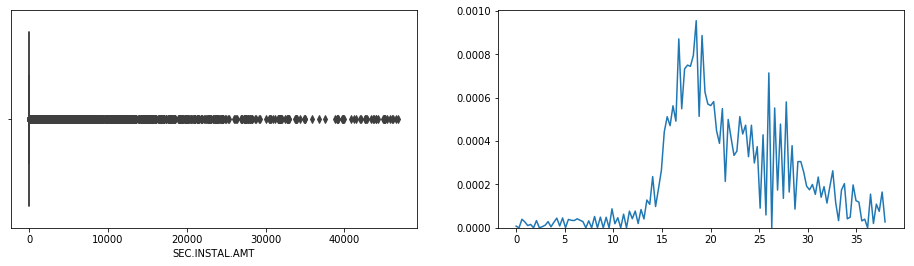

In [601]:
col = int_cols[2]
temp = train_df[train_df['PRI.CURRENT.BALANCE']<3000000][[int_cols[2]]]
tp = temp[col][(np.abs(stats.zscore(temp[[col]])) < 3).all(axis=1)]

fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(tp, ax=ax[0])
sns.kdeplot(boxcox(1+tp,lmbda=0.2),ax=ax[1])


In [603]:
tp[tp != 0]

154        9382
296        6485
316        1563
331        1065
403        1330
683        5185
710        2372
1538       1345
1589       3290
1718       9419
1759       1812
1768       2563
2038      12568
2113      14463
2212       1736
2215      10571
2247       4021
2262      15504
2286       1213
2302      45171
2308      12870
2362        433
2394       3171
2539       5813
2621       1676
2991      10575
3245       6889
3246       1534
3249        198
3280      20211
          ...  
226319    14870
226368      277
226508     7300
226793    19033
226988     4664
227666      982
229223    13302
229250     5000
229316      800
229849     6779
230169    10076
230233     1079
230239     3965
230247    17000
230399     2348
230431    10432
231198      625
231212     5082
231491    16807
231838     1232
231855      684
231868     2600
231967     2337
231970     4001
232159     9408
232173     1410
232174     1743
232348     2665
232675     2917
232829     3500
Name: SEC.INSTAL.AMT, Le

232912 233154


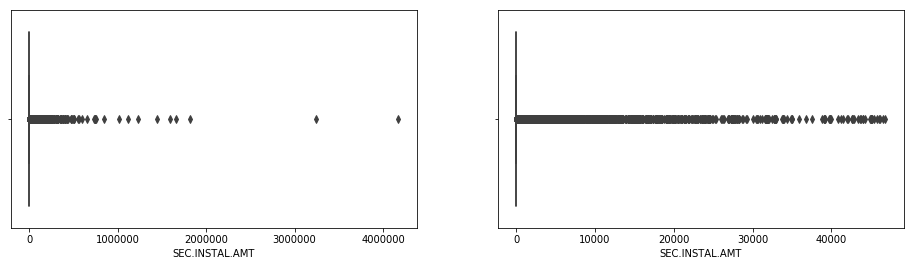

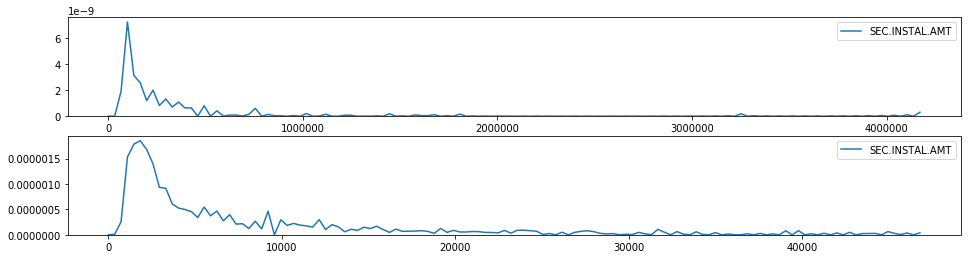

In [550]:
col = int_cols[2]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

232522 233154


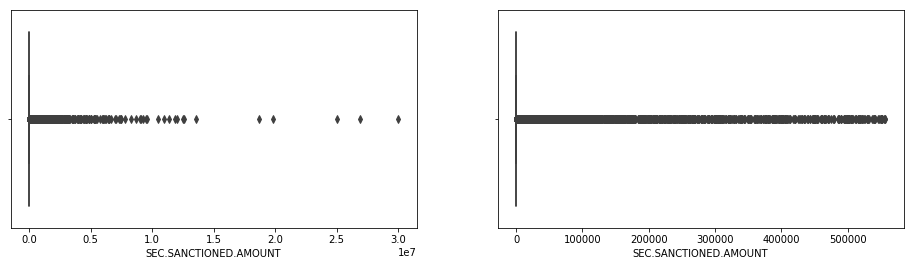

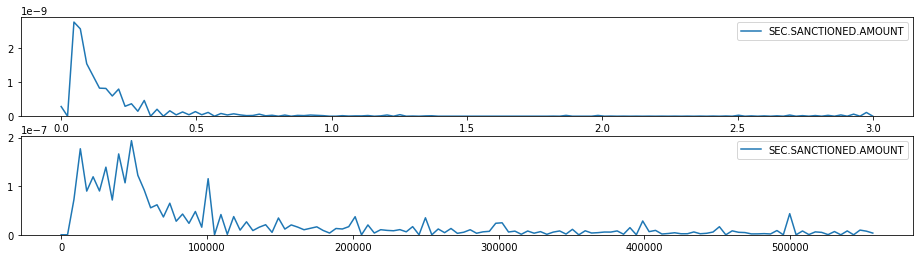

In [551]:
col = int_cols[3]
fig, ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_df[col], ax=ax[0])

tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])

fig, ax = plt.subplots(2,1,figsize=(16,4))
sns.kdeplot(train_df[col], ax=ax[0])#,label='0')
sns.kdeplot(tp, ax=ax[1])#,label='1')

In [176]:
int_cols

['SEC.CURRENT.BALANCE',
 'SEC.DISBURSED.AMOUNT',
 'SEC.INSTAL.AMT',
 'SEC.SANCTIONED.AMOUNT']

# I mess with `SEC.ACTIVE.ACCTS`, do all operation on this variable again

In [177]:
# New loans taken by the customer in last 6 mont... 	
train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

0     181494
1      32099
2      11015
3       4458
4       1957
5        964
6        480
7        302
8        147
9         79
10        55
11        31
12        20
13        15
14        11
16         6
17         6
20         3
15         2
18         2
19         2
23         2
28         1
21         1
22         1
35         1
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [178]:
use_index = train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'][
    train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS']>1].index
train_df.loc[use_index, 'NEW.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
print(train_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts())

use_index = test_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'][
    test_df['NEW.ACCTS.IN.LAST.SIX.MONTHS']>1].index
test_df.loc[use_index, 'NEW.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
print(test_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'].value_counts())


(19561,)
0    181494
1     32099
2     19561
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64
(7679,)
0    90847
1    13866
2     7679
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64


In [609]:
# DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS: When a loan defaults, it is sent to a debt collection agency whose job is to contact the borrower and receive the unpaid funds. 

train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

0     214959
1      14941
2       2470
3        537
4        138
5         58
6         20
7         13
8          7
12         3
11         3
10         2
9          2
20         1
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [179]:
use_index = train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'][
    train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']>1].index
train_df.loc[use_index, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
print(train_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts())

use_index = test_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'][
    test_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']>1].index
test_df.loc[use_index, 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = 2
print(use_index.shape)
test_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'].value_counts()

# train_df.groupby(['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','loan_default'])['loan_default'].count().unstack()

(3254,)
0    214959
1     14941
2      3254
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64
(1464,)


0    104185
1      6743
2      1464
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64

In [ ]:
# 14 	MobileNo_Avl_Flag 	if Mobile no. was shared by the customer then ... 	NaN
# 15 	Aadhar_flag 	if aadhar was shared by the customer then flag... 	NaN
# 16 	PAN_flag 	if pan was shared by the customer then flagged... 	NaN
# 17 	VoterID_flag 	if voter was shared by the customer then flag... 	NaN
# 18 	Driving_flag 	if DL was shared by the customer then flagged ... 	NaN
# 19 	Passport_flag 	if passport was shared by the customer then fl... 	NaN


In [180]:
cols = ['MobileNo_Avl_Flag','Aadhar_flag','PAN_flag','VoterID_flag',
        'Driving_flag','Passport_flag']
train_df[cols].apply(lambda x: pd.Series.value_counts(x))

MobileNo_Avl_Flag  Aadhar_flag  PAN_flag  VoterID_flag  Driving_flag  \
0                NaN        37230    215533        199360        227735   
1           233154.0       195924     17621         33794          5419   

   Passport_flag  
0         232658  
1            496

In [181]:
train_df.drop('MobileNo_Avl_Flag', axis=1, inplace=True)
test_df.drop('MobileNo_Avl_Flag', axis=1, inplace=True)


In [ ]:
# 0  UniqueID 	Identifier for customers 	NaN
# 1  loan_default 	Payment default in the first EMI on due date 	NaN
# 2  disbursed_amount 	Amount of Loan disbursed 	NaN
# 3  asset_cost 	Cost of the Asset 	NaN
# 4  ltv 	Loan to Value of the asset 	NaN
# 5  branch_id 	Branch where the loan was disbursed 	NaN
# 6  supplier_id 	Vehicle Dealer where the loan was disbursed 	NaN
# 7  manufacturer_id 	Vehicle manufacturer(Hero, Honda, TVS etc.) 	NaN
# 8  Current_pincode 	Current pincode of the customer 	NaN
# 9  Date.of.Birth 	Date of birth of the customer 	NaN
# 10 Employment.Type 	Employment Type of the customer (Salaried/Self... 	NaN
# 11 DisbursalDate 	Date of disbursement 	NaN
# 12 State_ID 	State of disbursement 	NaN
# 13 Employee_code_ID 	Employee of the organization who logged the di... 	NaN

# 22 PRI.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Primary accounts are those which the customer ...
# 23 PRI.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 24 PRI.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN
# 25 PRI.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	NaN
# 26 PRI.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 27 PRI.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo... 	NaN
# 28 SEC.NO.OF.ACCTS 	count of total loans taken by the customer at ... 	Secondary accounts are those which the custome...
# 29 SEC.ACTIVE.ACCTS 	count of active loans taken by the customer at... 	NaN
# 30 SEC.OVERDUE.ACCTS 	count of default accounts at the time of disbu... 	NaN
# 31 SEC.CURRENT.BALANCE 	total Principal outstanding amount of the acti... 	NaN
# 32 SEC.SANCTIONED.AMOUNT 	total amount that was sanctioned for all the l... 	NaN
# 33 SEC.DISBURSED.AMOUNT 	total amount that was disbursed for all the lo... 	NaN
# 34 PRIMARY.INSTAL.AMT 	EMI Amount of the primary loan 	NaN
# 35 SEC.INSTAL.AMT 	EMI Amount of the secondary loan 	NaN
# 36 NEW.ACCTS.IN.LAST.SIX.MONTHS 	New loans taken by the customer in last 6 mont... 	NaN
# 37 DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS 	Loans defaulted in the last 6 months 	NaN
# 38 AVERAGE.ACCT.AGE 	Average loan tenure 	NaN
# 39 CREDIT.HISTORY.LENGTH 	Time since first loan 	NaN
# 40 NO.OF_INQUIRIES 	Enquries done by the customer for loans 	NaN

In [189]:
cols = ['day_of_birth','month_of_birth','year_of_birth',
        'day_of_disbursal','month_of_disbursal','year_of_disbursal',
        'credit_hist_year','credit_hist_month',
        'loan_tenure_year','loan_tenure_month']

train_df[cols] = train_df[cols].astype('int')
test_df[cols]  = test_df[cols].astype('int')

train_df['credit_history'] = train_df['credit_hist_year']*12+train_df['credit_hist_month']
test_df['credit_history'] = test_df['credit_hist_year']*12+test_df['credit_hist_month']

In [646]:
# train_df.groupby(['day_of_birth','month_of_birth','year_of_birth','loan_default'])['loan_default'].count().unstack()
# train_df.groupby(['credit_hist_year','credit_hist_month','loan_default'])['loan_default'].count().unstack()


In [190]:
train_df.credit_history.value_counts().sort_index()

0      119127
1        1853
2        1977
3        1982
4        2143
5        2086
6        4761
7        4017
8        2459
9        2403
10       2367
11       2627
12       3389
13       3024
14       2203
15       2268
16       1882
17       1868
18       2176
19       2167
20       1643
21       1811
22       1818
23       2364
24       3833
25       4745
26       1793
27       1407
28       1378
29       1376
        ...  
279         1
280         1
282         2
288         1
290         1
292         2
295         2
296         1
300         1
306         2
307         2
308         1
311         1
315         1
320         1
323         1
327         1
328         1
337         1
339         1
343         1
345         1
349         1
355         2
367         1
369         1
413         1
423         1
449         1
468         1
Name: credit_history, Length: 294, dtype: int64

In [673]:
# train_df.credit_hist_year.value_counts().sort_index()

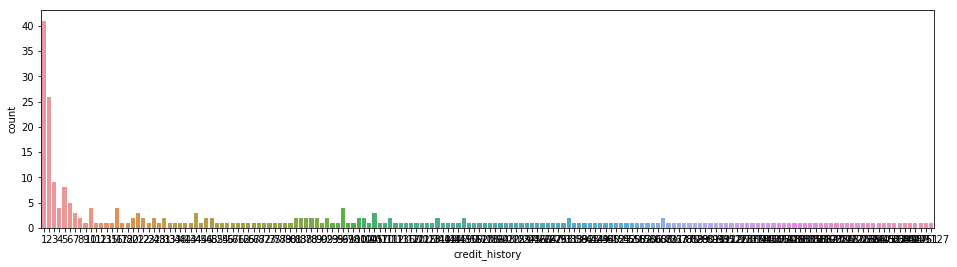

In [191]:
plt.figure(figsize=(16,4))
sns.countplot(train_df.credit_history.value_counts())

In [192]:
bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 12), (12, 24), 
                                     (24, 36), (36, 60), (60, 120), (120,500)])
train_df['credit_history'] = pd.cut(train_df.credit_history, bins)
test_df['credit_history'] = pd.cut(test_df.credit_history, bins)

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 1), (1, 3), (3, 6), (6, 9), (9, 50)])
train_df['credit_hist_year'] = pd.cut(train_df.credit_hist_year, bins)
test_df['credit_hist_year'] = pd.cut(test_df.credit_hist_year, bins)

print(train_df.credit_history.value_counts())
print(train_df.credit_hist_year.value_counts())


(-1, 0]       119127
(0, 12]        32064
(12, 24]       27057
(24, 36]       20462
(36, 60]       18388
(60, 120]      11793
(120, 500]      4263
Name: credit_history, dtype: int64
(-1, 0]    147802
(1, 3]      34511
(0, 1]      26613
(3, 6]      15446
(6, 9]       4423
(9, 50]      4359
Name: credit_hist_year, dtype: int64


In [193]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df['credit_history']) + list(test_df['credit_history']))
print(le.classes_)
train_df['credit_history'] = le.transform(train_df['credit_history'])
test_df['credit_history']  = le.transform(test_df['credit_history'])

le.fit(list(train_df['credit_hist_year']) + list(test_df['credit_hist_year']))
print(le.classes_)
train_df['credit_hist_year'] = le.transform(train_df['credit_hist_year'])
test_df['credit_hist_year']  = le.transform(test_df['credit_hist_year'])


[Interval(-1, 0, closed='right') Interval(0, 12, closed='right')
 Interval(12, 24, closed='right') Interval(24, 36, closed='right')
 Interval(36, 60, closed='right') Interval(60, 120, closed='right')
 Interval(120, 500, closed='right')]
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 6, closed='right')
 Interval(6, 9, closed='right') Interval(9, 50, closed='right')]


# Also try, if category further can be reduced or grouped

In [674]:
train_df[['day_of_disbursal','month_of_disbursal','year_of_disbursal']]

day_of_disbursal  month_of_disbursal  year_of_disbursal
0                      8                   3               2018
1                     26                   9               2018
2                      8                   1               2018
3                     26                  10               2018
4                     26                   9               2018
5                     19                   9               2018
6                     23                   9               2018
7                     16                   9               2018
8                      9                   5               2018
9                     16                   9               2018
10                    29                   9               2018
11                     9                   3               2018
12                    30                   8               2018
13                    30                   8               2018
14                    31                   8               2018
15                    22                  10               2018
16                    18                   9               2018
17                    20                   9               2018
18                     9                   6               2018
19                    10                  11               2018
20                    20                  10               2018
21                    27                   8               2018
22                    10                   8               2018
23                    17                   9               2018
24                     9                  10               2018
25                    18                  10               2018
26                    16                   8               2018
27                    10                  10               2018
28                    23                  10               2018
29                    19                   9               2018
...                  ...                 ...                ...
233124                17                  10               2018
233125                13                  10               2018
233126                10                   5               2018
233127                13                  10               2018
233128                23                  10               2018
233129                 9                  10               2018
233130                20                   8               2018
233131                27                   9               2018
233132                30                   8               2018
233133                26                  10               2018
233134                24                  10               2018
233135                26                  10               2018
233136                23                  10               2018
233137                27                  10               2018
233138                23                  10               2018
233139                24                  10               2018
233140                26                  10               2018
233141                23                  10               2018
233142                23                  10               2018
233143                26                  10               2018
233144                24                  10               2018
233145                23                  10               2018
233146                26                  10               2018
233147                31                  10               2018
233148                24                  10               2018
233149                26                  10               2018
233150                23                  10               2018
233151                24                  10               2018
233152                29                   9               2018
233153                27                  10               2018

[233154 rows x 3 columns]

In [194]:
train_df.drop('year_of_disbursal',axis=1, inplace=True)
test_df.drop('year_of_disbursal',axis=1, inplace=True)


In [195]:
train_df.month_of_disbursal.value_counts()

10    84875
8     56975
9     54443
11     6709
6      5991
12     5613
3      5148
4      4627
7      4150
5      2890
1      1708
2        25
Name: month_of_disbursal, dtype: int64

In [196]:
train_df.loan_tenure_year.value_counts()

0     168390
1      36650
2      14839
3       6622
4       3033
5       1600
6        810
7        467
8        234
9        150
10       129
11       102
12        57
13        35
14        15
15        10
16         5
17         2
24         1
18         1
22         1
30         1
Name: loan_tenure_year, dtype: int64

In [197]:
train_df.loan_tenure_month.value_counts()

0     127976
6      11085
1      10117
7       9881
4       9757
3       9720
2       9682
5       9519
8       8936
10      8842
9       8842
11      8797
Name: loan_tenure_month, dtype: int64

In [198]:
train_df['loan_tenure'] = train_df['loan_tenure_year']*12+train_df['loan_tenure_month']
test_df['loan_tenure']  = test_df['loan_tenure_year']*12+test_df['loan_tenure_month']

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 12), (12, 24), (24, 60), (60,500)])
train_df['loan_tenure'] = pd.cut(train_df.loan_tenure, bins)
test_df['loan_tenure'] = pd.cut(test_df.loan_tenure, bins)

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 1), (1, 2), (2, 5), (5, 10), (10, 50)])
train_df['loan_tenure_year'] = pd.cut(train_df.loan_tenure_year, bins)
test_df['loan_tenure_year'] = pd.cut(test_df.loan_tenure_year, bins)

print(train_df.loan_tenure.value_counts())
print(train_df.loan_tenure_year.value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df['loan_tenure']) + list(test_df['loan_tenure']))
print(le.classes_)
train_df['loan_tenure'] = le.transform(train_df['loan_tenure'])
test_df['loan_tenure']  = le.transform(test_df['loan_tenure'])

le.fit(list(train_df['loan_tenure_year']) + list(test_df['loan_tenure_year']))
print(le.classes_)
train_df['loan_tenure_year'] = le.transform(train_df['loan_tenure_year'])
test_df['loan_tenure_year']  = le.transform(test_df['loan_tenure_year'])


(-1, 0]      119373
(0, 12]       54048
(12, 24]      33582
(24, 60]      22715
(60, 500]      3436
Name: loan_tenure, dtype: int64
(-1, 0]     168390
(0, 1]       36650
(1, 2]       14839
(2, 5]       11255
(5, 10]       1790
(10, 50]       230
Name: loan_tenure_year, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 12, closed='right')
 Interval(12, 24, closed='right') Interval(24, 60, closed='right')
 Interval(60, 500, closed='right')]
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 5, closed='right')
 Interval(5, 10, closed='right') Interval(10, 50, closed='right')]


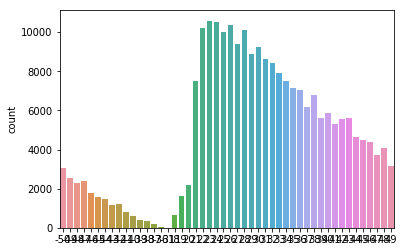

In [199]:
sns.countplot(train_df_save['year_of_disbursal'] - train_df['year_of_birth'])

In [751]:
sorted(test_df['year_of_birth'].unique())

[1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 2060,
 2061,
 2062,
 2063,
 2064,
 2065,
 2066,
 2067,
 2068]

In [201]:
train_df.year_of_birth = train_df.year_of_birth.apply(lambda x: int(str(19)+str(x)[-2:]))
test_df.year_of_birth  = test_df.year_of_birth.apply(lambda x: int(str(19)+str(x)[-2:]))

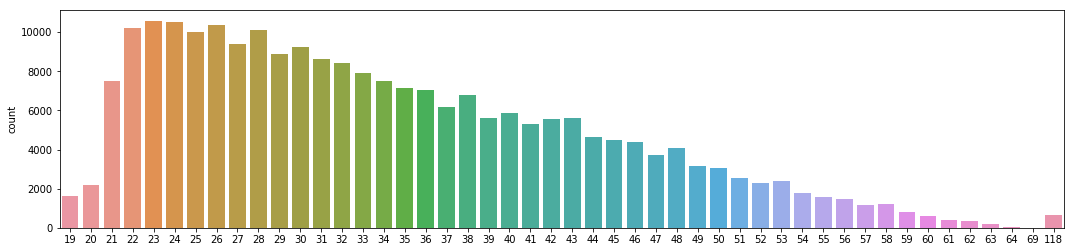

In [202]:
plt.figure(figsize=(18,4))
sns.countplot(train_df_save['year_of_disbursal'] - train_df['year_of_birth'])

In [203]:
train_df['age_till_disbursal'] = train_df_save['year_of_disbursal'] - train_df['year_of_birth']
test_df['age_till_disbursal']  = test_df_save['year_of_disbursal'] - test_df['year_of_birth']

In [758]:
train_df.head()

UniqueID  disbursed_amount  asset_cost    ltv  branch_id  supplier_id  \
0    420825             50578       58400  89.55         67        22807   
1    537409             47145       65550  73.23         67        22807   
2    417566             53278       61360  89.63         67        22807   
3    624493             57513       66113  88.48         67        22807   
4    539055             52378       60300  88.39         67        22807   

   manufacturer_id  Current_pincode_ID  Employment.Type  State_ID  \
0               45                1441                0         6   
1               45                1502                1         6   
2               45                1497                1         6   
3               45                1501                1         6   
4               45                1495                1         6   

          ...          loan_tenure_year  loan_tenure_month  day_of_disbursal  \
0         ...                         0                  0                 8   
1         ...                         1                 11                26   
2         ...                         0                  0                 8   
3         ...                         0                  8                26   
4         ...                         0                  0                26   

   month_of_disbursal  Bureau_desc  bureau_score  loan_default  \
0                   3           13             0             0   
1                   9            8           598             1   
2                   1           13             0             0   
3                  10           11           305             1   
4                   9           13             0             1   

   credit_history  loan_tenure  age_till_disbursal  
0               0            0                  34  
1               2            2                  33  
2               0            0                  33  
3               2            1                  25  
4               0            0                  41  

[5 rows x 48 columns]

232432 233154


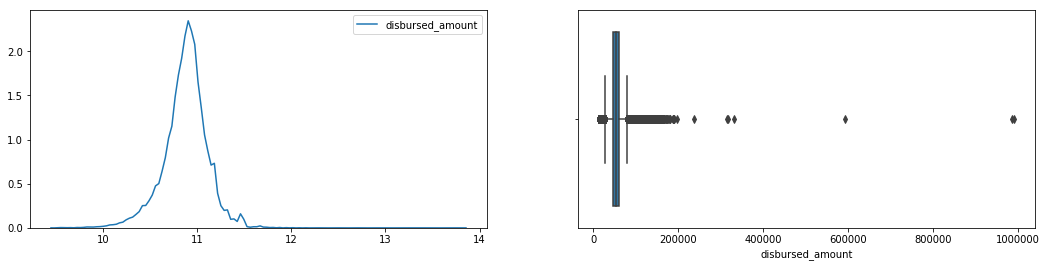

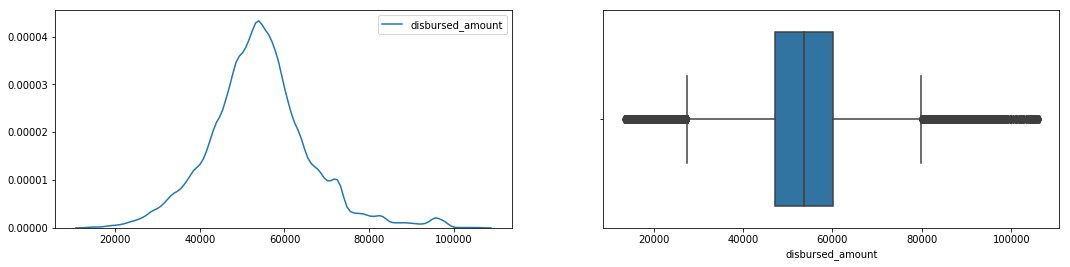

In [214]:
col = 'disbursed_amount'

fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(np.log(train_df[col]), ax=ax[0])
sns.boxplot(train_df[col], ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 4).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

# sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])


In [221]:
train_df[col][train_df[col]>100000].shape, test_df[col][test_df[col]>100000].shape

((835,), (530,))

(835,)
(530,)


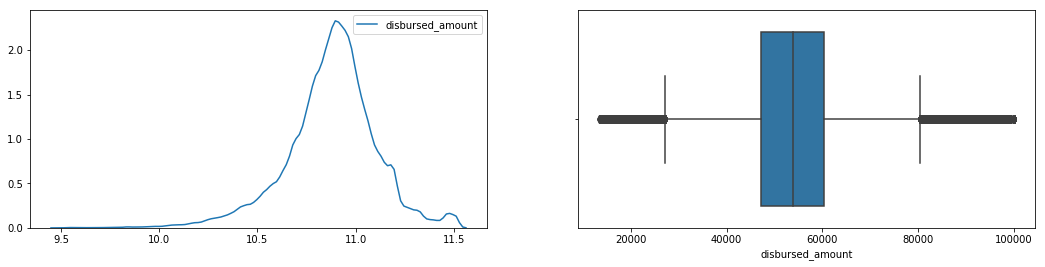

In [223]:
col = 'disbursed_amount'

use_index = train_df[col][train_df[col]>100000].index
train_df.loc[use_index, col] = 100000
print(use_index.shape)

use_index = test_df[col][test_df[col]>100000].index
test_df.loc[use_index, col] = 100000
print(use_index.shape)

fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(np.log(train_df[col]), ax=ax[0])
sns.boxplot(train_df[col], ax=ax[1])


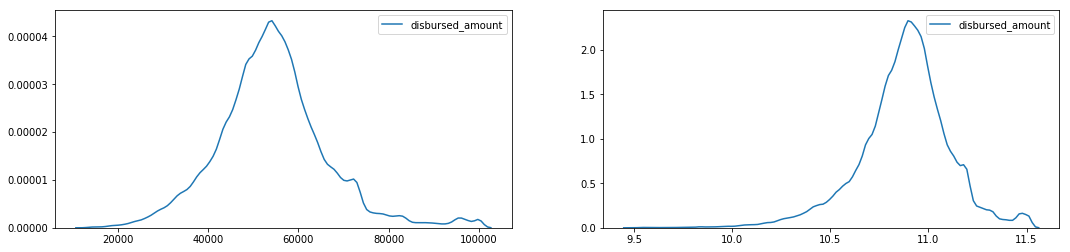

In [225]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0])
sns.kdeplot(np.log(train_df[col]), ax=ax[1])


230465 233154


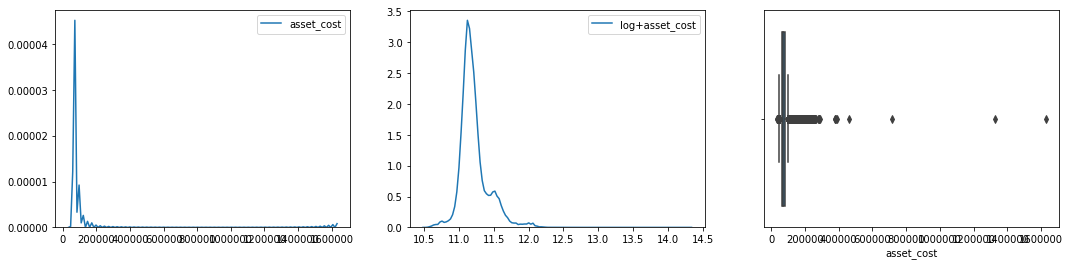

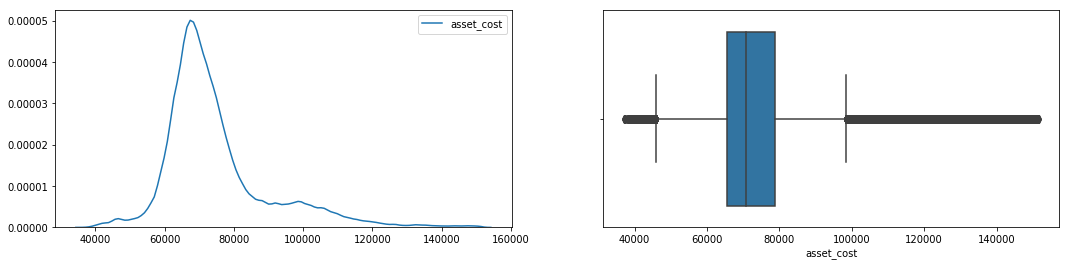

In [229]:
col = 'asset_cost'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 4).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

# sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])


In [235]:
train_df[col][train_df[col]>170000].shape, test_df[col][test_df[col]>170000].shape

((1091,), (630,))

(0,)
(0,)


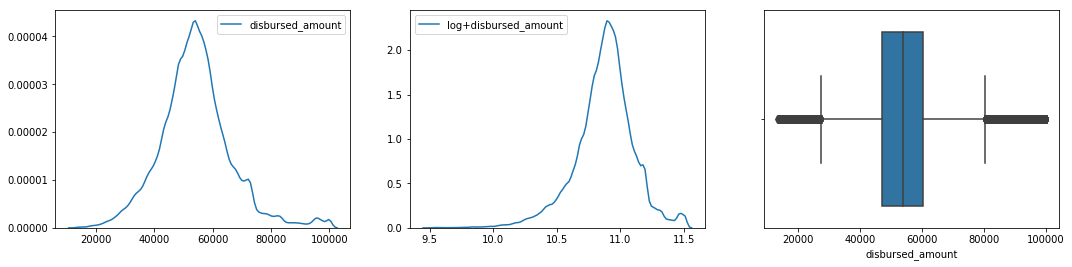

In [236]:
col = 'disbursed_amount'

use_index = train_df[col][train_df[col]>170000].index
train_df.loc[use_index, col] = 170000
print(use_index.shape)

use_index = test_df[col][test_df[col]>170000].index
test_df.loc[use_index, col] = 170000
print(use_index.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])


230409 233154


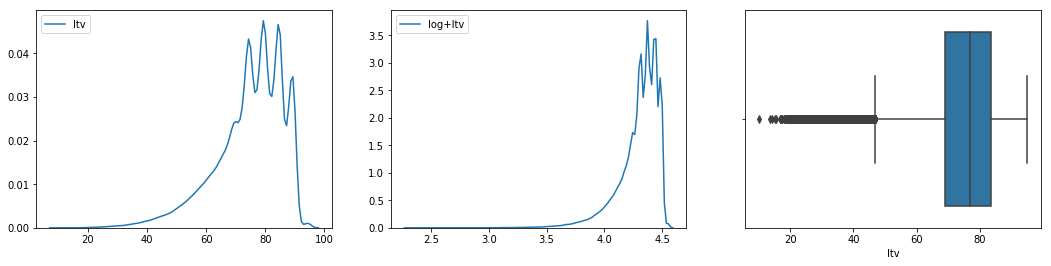

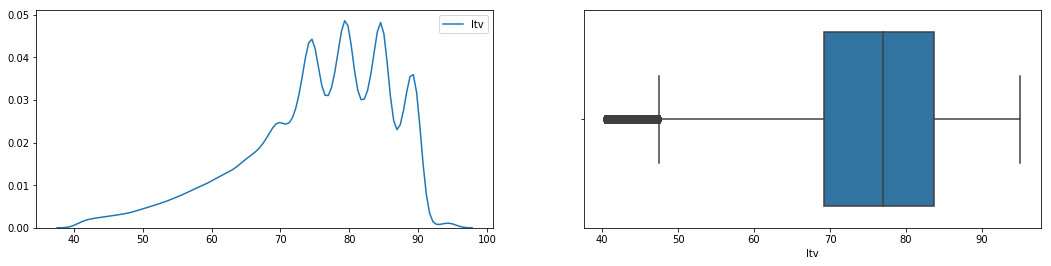

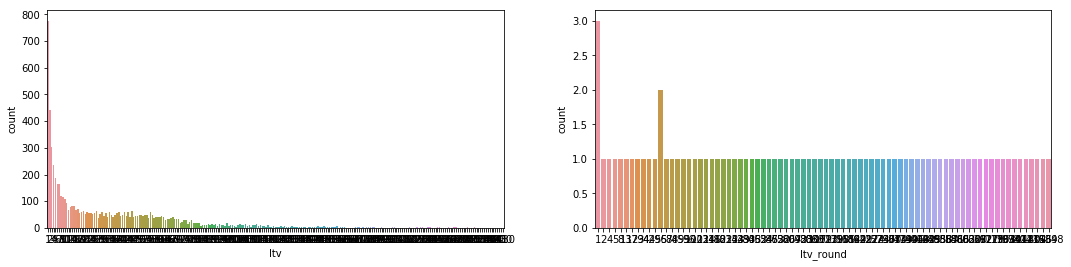

In [244]:
col = 'ltv'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

fig, ax = plt.subplots(1,2,figsize=(18,4))
bar = train_df.ltv.value_counts()
sns.countplot(bar, ax=ax[0])
bar = train_df.ltv_round.value_counts()
sns.countplot(bar, ax=ax[1])

# sns.boxplot(tp, ax=ax[1])
print(tp.shape[0], train_df.shape[0])


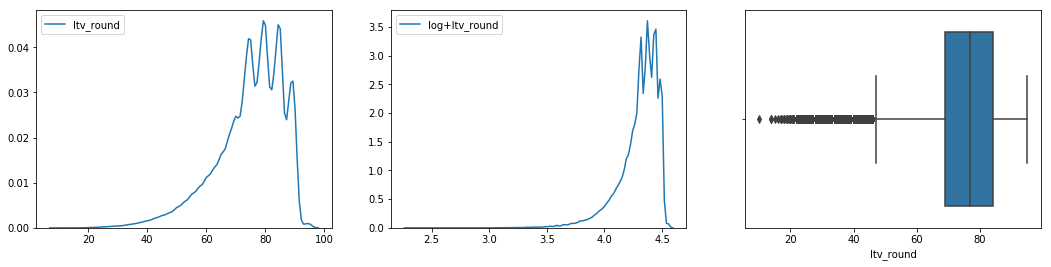

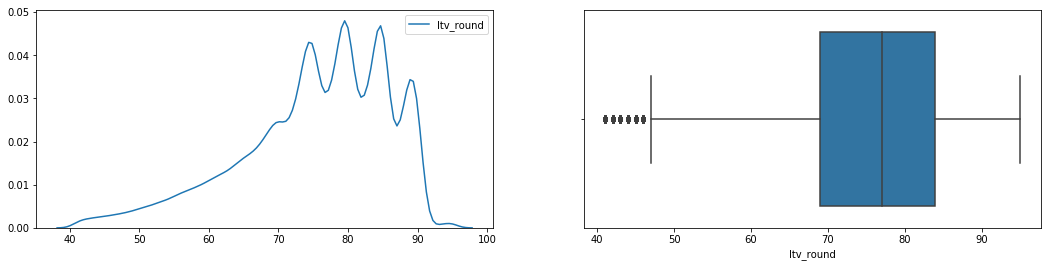

In [262]:
col = 'ltv_round'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

In [245]:
train_df.ltv_round.value_counts().sort_index()

10.0        1
14.0        2
15.0        1
16.0        1
17.0        5
18.0        4
19.0        8
20.0       13
21.0       17
22.0       29
23.0       42
24.0       34
25.0       49
26.0       57
27.0       56
28.0       96
29.0       84
30.0      100
31.0       95
32.0      122
33.0      146
34.0      180
35.0      181
36.0      243
37.0      235
38.0      280
39.0      352
40.0      354
41.0      387
42.0      463
        ...  
66.0     3996
67.0     4199
68.0     4885
69.0     5387
70.0     6320
71.0     4986
72.0     5883
73.0     7118
74.0    10480
75.0    12116
76.0     6020
77.0     6627
78.0     7767
79.0    11404
80.0    13639
81.0     5841
82.0     6392
83.0     7130
84.0     9804
85.0    15848
86.0     4006
87.0     4229
88.0     5865
89.0     9741
90.0     9334
91.0       56
92.0       85
93.0      134
94.0      249
95.0      346
Name: ltv_round, Length: 83, dtype: int64

In [263]:
col = 'ltv_round'
new_col = 'ltv_round_cat'

bins_ = [(9.99, 57.0), (57.0, 64.0), (64.0, 69.0), (69.0, 72.0), 
        (72.0, 75.0), (75.0, 77.0), (77.0, 79.0), (79.0, 81.0), 
        (81.0, 84.0), (84.0, 85.0), (85.0, 89.0), (89.0, 95.0)]

bins = pd.IntervalIndex.from_tuples(bins_)
train_df[new_col] = pd.cut(train_df[col], bins)
test_df[new_col]  = pd.cut(test_df[col], bins)
print(train_df[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df[new_col]) + list(test_df[new_col]))
print(le.classes_)
train_df[new_col] = le.transform(train_df[new_col])
test_df[new_col]  = le.transform(test_df[new_col])


(72.0, 75.0]    29714
(85.0, 89.0]    23841
(81.0, 84.0]    23326
(64.0, 69.0]    22207
(9.99, 57.0]    20283
(79.0, 81.0]    19480
(57.0, 64.0]    19244
(77.0, 79.0]    19171
(69.0, 72.0]    17189
(84.0, 85.0]    15848
(75.0, 77.0]    12647
(89.0, 95.0]    10204
Name: ltv_round_cat, dtype: int64
[Interval(9.99, 57.0, closed='right') Interval(57.0, 64.0, closed='right')
 Interval(64.0, 69.0, closed='right') Interval(69.0, 72.0, closed='right')
 Interval(72.0, 75.0, closed='right') Interval(75.0, 77.0, closed='right')
 Interval(77.0, 79.0, closed='right') Interval(79.0, 81.0, closed='right')
 Interval(81.0, 84.0, closed='right') Interval(84.0, 85.0, closed='right')
 Interval(85.0, 89.0, closed='right') Interval(89.0, 95.0, closed='right')]


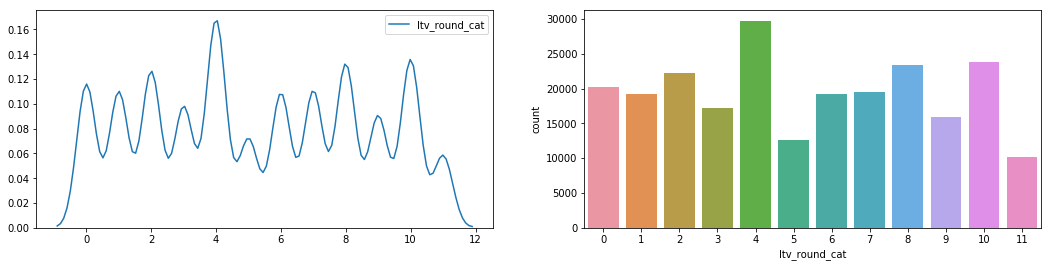

In [267]:
col = 'ltv_round_cat'

fig, ax = plt.subplots(1,2,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.countplot(train_df[col], ax=ax[1])

In [268]:
train_df.drop('ltv_round', axis=1, inplace=True)
test_df.drop('ltv_round', axis=1, inplace=True)


In [277]:
train_df['NO.OF_INQUIRIES'].value_counts()

col = 'NO.OF_INQUIRIES'
new_col = 'no_of_inquiry'

bins_ = [(-1,0),(0,1),(1,3),(3,100)]

bins = pd.IntervalIndex.from_tuples(bins_)
train_df[new_col] = pd.cut(train_df[col], bins)
test_df[new_col]  = pd.cut(test_df[col], bins)
print(train_df[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(list(train_df[new_col]) + list(test_df[new_col]))
print(le.classes_)
train_df[new_col] = le.transform(train_df[new_col])
test_df[new_col]  = le.transform(test_df[new_col])

train_df.drop(col, axis=1, inplace=True)
test_df.drop(col, axis=1, inplace=True)


(-1, 0]     201961
(0, 1]       22285
(1, 3]        7176
(3, 100]      1732
Name: no_of_inquiry, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 100, closed='right')]


In [282]:
train_df['SEC.INSTAL.AMT'].value_counts()

0         230937
2100           7
1100           6
5000           6
1065           6
1232           6
2400           5
1565           5
1834           5
50000          5
833            5
1167           5
3334           4
2500           4
2065           4
2250           4
1149           4
1              4
1375           4
1750           4
3000           4
100000         4
1850           4
4500           4
2542           4
1650           4
2150           3
1877           3
231            3
10000          3
           ...  
26846          1
299843         1
55882          1
11210          1
181000         1
81000          1
9419           1
3278           1
17735          1
5581           1
7756           1
1615           1
4046           1
43333          1
19033          1
2769           1
4946           1
4563           1
3025           1
5330           1
7379           1
105699         1
23899          1
3537           1
1616           1
1744           1
6098           1
2256          

In [285]:
col = 'SEC.INSTAL.AMT'

train_df[col][train_df[col]==0].shape

(230937,)

In [286]:
col = 'SEC.INSTAL.AMT'

use_index = train_df[col][train_df[col]!=0].index
train_df.loc[use_index, col] = 1
print(use_index.shape)

use_index = test_df[col][test_df[col]!=0].index
test_df.loc[use_index, col] = 1
print(use_index.shape)


(2217,)
(488,)


In [287]:
train_df[col].value_counts()

0    230937
1      2217
Name: SEC.INSTAL.AMT, dtype: int64

/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


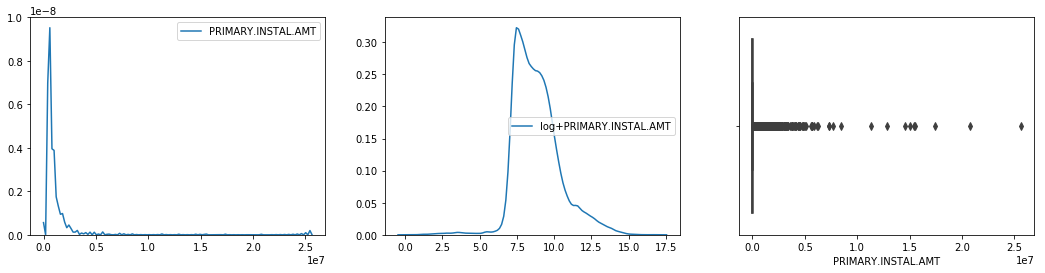

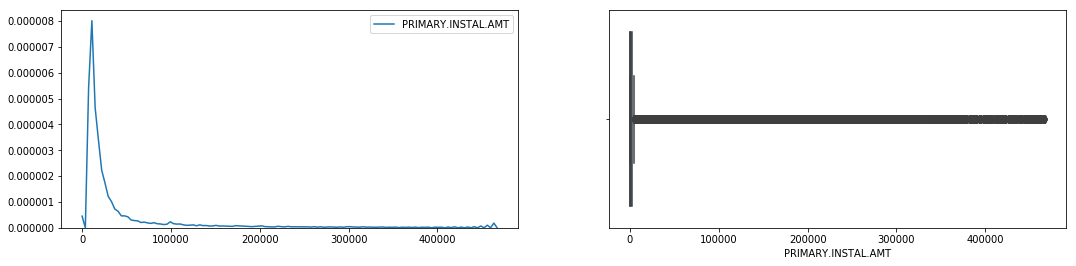

In [289]:
col = 'PRIMARY.INSTAL.AMT'

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])

fig, ax = plt.subplots(1,2,figsize=(18,4))
tp = train_df[col][(np.abs(stats.zscore(train_df[[col]])) < 3).all(axis=1)]
sns.kdeplot(tp, ax=ax[0])
sns.boxplot(tp, ax=ax[1])

In [295]:
train_df[col][train_df[col]>600000].shape, test_df[col][test_df[col]>600000].shape

((944,), (359,))

(1181,)
(449,)


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


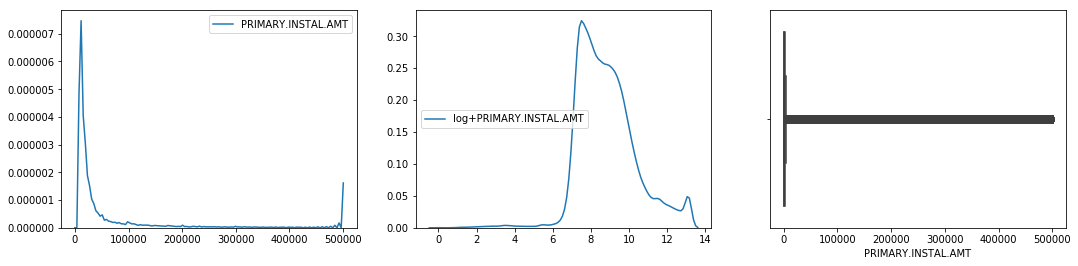

In [296]:
col = 'PRIMARY.INSTAL.AMT'

use_index = train_df[col][train_df[col]>500000].index
train_df.loc[use_index, col] = 500000
print(use_index.shape)

use_index = test_df[col][test_df[col]>500000].index
test_df.loc[use_index, col] = 500000
print(use_index.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(np.log(train_df[col]), ax=ax[1], label='log+'+col)
sns.boxplot(train_df[col], ax=ax[2])


In [300]:
train_df[col][train_df[col]>100000].shape, test_df[col][test_df[col]>100000].shape

((4854,), (1908,))

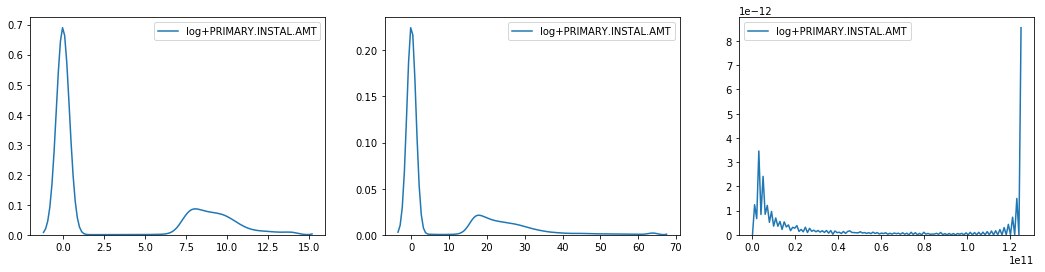

In [312]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
# sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.01), ax=ax[0], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.2), ax=ax[1], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=2), ax=ax[2], label='log+'+col)


In [319]:
train_df[col][train_df[col]<100000].shape, test_df[col][test_df[col]<100000].shape,\
np.percentile(train_df[col],98)

((228214,), (110451,), 106000.0)

Before:  (233154, 52)
After:  (228214, 52)


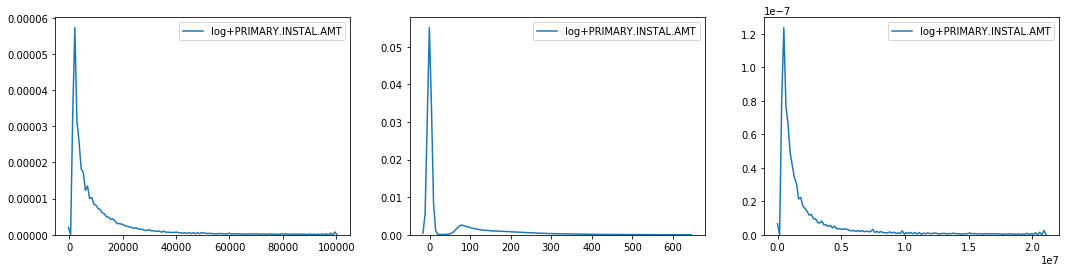

In [320]:
print("Before: ", train_df.shape)
train_df = train_df[train_df[col]<100000]
print("After: ", train_df.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
# sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1), ax=ax[0], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.5), ax=ax[1], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1.5), ax=ax[2], label='log+'+col)


In [325]:
train_df[col][train_df[col]<20000].shape, test_df[col][test_df[col]<20000].shape,\
np.percentile(train_df[col],95)

((218429,), (106178,), 17618.349999999977)

Before:  (228214, 52)
After:  (224607, 52)


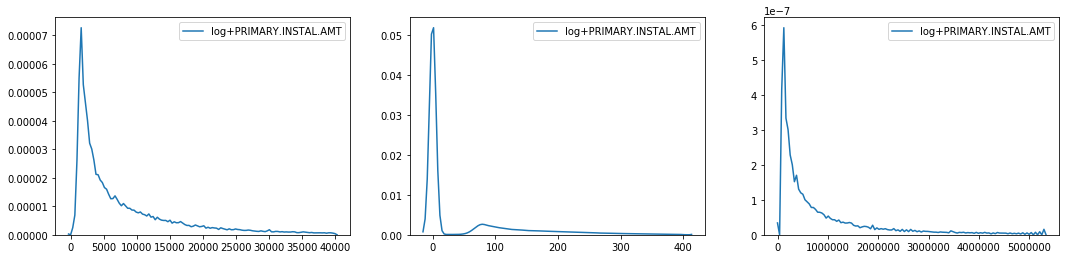

In [326]:
print("Before: ", train_df.shape)
train_df = train_df[train_df[col]<40000]
print("After: ", train_df.shape)

fig, ax = plt.subplots(1,3,figsize=(18,4))
# sns.kdeplot(train_df[col], ax=ax[0], label=col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1), ax=ax[0], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=0.5), ax=ax[1], label='log+'+col)
sns.kdeplot(boxcox(train_df[col]+1, lmbda=1.5), ax=ax[2], label='log+'+col)


In [329]:
train_df_save2 = train_df.copy()
test_df_save2  = test_df.copy()

train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
test_df.drop('UniqueID', axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
target = train_df_save2.loan_default
test_id = test_df_save2.UniqueID

train_df_save.shape, train_df_save1.shape, train_df_save2.shape, train_df.shape

((233154, 47), (233154, 51), (224607, 52), (224607, 50))

In [341]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=50, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.658055	valid_1's auc: 0.649907
[100]	training's auc: 0.660458	valid_1's auc: 0.652178
[150]	training's auc: 0.66301	valid_1's auc: 0.653871
[200]	training's auc: 0.665726	valid_1's auc: 0.655789
[250]	training's auc: 0.66781	valid_1's auc: 0.657361
[300]	training's auc: 0.670516	valid_1's auc: 0.659152
[350]	training's auc: 0.672434	valid_1's auc: 0.660358
[400]	training's auc: 0.674801	valid_1's auc: 0.661921
[450]	training's auc: 0.677013	valid_1's auc: 0.663092
[500]	training's auc: 0.678963	valid_1's auc: 0.664193
[550]	training's auc: 0.680733	valid_1's auc: 0.664862
[600]	training's auc: 0.682542	valid_1's auc: 0.665879
[650]	training's auc: 0.68421	valid_1's auc: 0.6668
[700]	training's auc: 0.685769	valid_1's auc: 0.667288
[750]	training's auc: 0.687284	valid_1's auc: 0.66786
[800]	training's auc: 0.688819	valid_1's auc: 0.668482
[850]	training's auc: 0.690387	valid_1'

NameError: name 'sub' is not defined

In [336]:
train_df_save.to_csv('store_data/train_df_save.csv',index=None)
train_df_save1.to_csv('store_data/train_df_save1.csv',index=None)
train_df_save2.to_csv('store_data/train_df_save2.csv',index=None)

test_df_save.to_csv('store_data/test_df_save.csv',index=None)
test_df_save1.to_csv('store_data/test_df_save1.csv',index=None)
test_df_save2.to_csv('store_data/test_df_save2.csv',index=None)



In [337]:
del train_df_save, train_df_save1, test_df_save, test_df_save1
gc.collect()

2635

In [339]:
gc.collect()
gc.collect()
gc.collect()

0

In [340]:
train_df_save2.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
       'Employment.Type', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'loan_default', 'day_of_birth',
       'month_of_birth', 'year_of_birth', 'credit_hist_year',
       'credit_hist_month', 'loan_tenure_year', 'loan_tenure_month',
       'day_of_disbursal', 'month_of_disbursal', 'Bureau_desc', 'bureau_score',
       'no_of_loans', 'no_of_acc', 'no_of_acc_overdue', 'diff_of_acc',
       'negative_income', 'income_status', 'credit_history'

In [344]:
train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])

disbursed_amount                       23592
asset_cost                             45522
ltv                                     6556
branch_id                                 82
supplier_id                             2946
manufacturer_id                           11
Current_pincode_ID                      6601
Employment.Type                            2
State_ID                                  22
Employee_code_ID                        3268
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PRI.CURRENT.BALANCE                    64301
PRI.SANCTIONED.AMOUNT                  40168
PRI.DISBURSED.AMOUNT                   43426
SEC.NO.OF.ACCTS                            2
SEC.ACTIVE.ACCTS                           2
SEC.OVERDUE.ACCTS                          2
SEC.CURRENT.BALANCE                     3042
SEC.SANCTI

In [352]:
train_df = train_df_save2.copy()
test_df  = test_df_save2.copy()


In [393]:
print("Before: ", train_df.shape)

train_df['inst_per_year'] = train_df['disbursed_amount']/1.0*(1+train_df['loan_tenure_year'])
test_df['inst_per_year']  = test_df['disbursed_amount']/1.0*(1+test_df['loan_tenure_year'])

train_df['inst_per_month'] = train_df['disbursed_amount']/1.0*(\
                    1+train_df['credit_hist_year']*12 + train_df['credit_hist_month'])
test_df['inst_per_month']  = test_df['disbursed_amount']/1.0*(\
                    1+test_df['credit_hist_year']*12 + test_df['credit_hist_month'])

train_df['inst_per_credit_year'] = (train_df['disbursed_amount']/(1+train_df['credit_hist_year']))
test_df['inst_per_credit_year']  = (test_df['disbursed_amount']/(1+test_df['credit_hist_year']))

train_df['inst_per_credit_month'] = train_df['disbursed_amount']/1.0*(\
                    1+train_df['credit_hist_year']*12 + train_df['credit_hist_month'])
test_df['inst_per_credit_month']  = test_df['disbursed_amount']/1.0*(\
                    1+test_df['credit_hist_year']*12 + test_df['credit_hist_month'])

train_df['loan_tenure/credit(in month)'] = (
    (train_df['loan_tenure_year']*12 +train_df['loan_tenure_month'])/(
    1+train_df['credit_hist_year']*12 + train_df['credit_hist_month'])).fillna(0)
test_df['loan_tenure/credit(in month)'] = (
    (test_df['loan_tenure_year']*12 + test_df['loan_tenure_month'])/(
    1+test_df['credit_hist_year']*12 + test_df['credit_hist_month'])).fillna(0)


train_df['assest-disbursed'] = train_df['asset_cost'] - train_df['disbursed_amount']
test_df['assest-disbursed'] = test_df['asset_cost'] - test_df['disbursed_amount']

print("After: ", train_df.shape)


Before:  (224607, 52)
After:  (224607, 58)


In [394]:
train_df_save2 = train_df.copy()
test_df_save2  = test_df.copy()

train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
test_df.drop('UniqueID', axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
target = train_df_save2.loan_default
test_id = test_df_save2.UniqueID

train_df_save.shape, train_df_save1.shape, train_df_save2.shape, train_df.shape

NameError: name 'train_df_save' is not defined

(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.653119	valid_1's auc: 0.64377
[100]	training's auc: 0.656524	valid_1's auc: 0.647822
[150]	training's auc: 0.65992	valid_1's auc: 0.650291
[200]	training's auc: 0.663109	valid_1's auc: 0.653117
[250]	training's auc: 0.665918	valid_1's auc: 0.655329
[300]	training's auc: 0.669244	valid_1's auc: 0.657633
[350]	training's auc: 0.671601	valid_1's auc: 0.659124
[400]	training's auc: 0.674506	valid_1's auc: 0.661122
[450]	training's auc: 0.676944	valid_1's auc: 0.662334
[500]	training's auc: 0.679117	valid_1's auc: 0.663302
[550]	training's auc: 0.681125	valid_1's auc: 0.664202
[600]	training's auc: 0.682997	valid_1's auc: 0.665139
[650]	training's auc: 0.684779	valid_1's auc: 0.665947
[700]	training's auc: 0.686553	valid_1's auc: 0.666592
[750]	training's auc: 0.688141	valid_1's auc: 0.667154
[800]	training's auc: 0.689791	valid_1's auc: 0.667681
[850]	training's auc: 0.691359	vali

<BarContainer object of 56 artists>

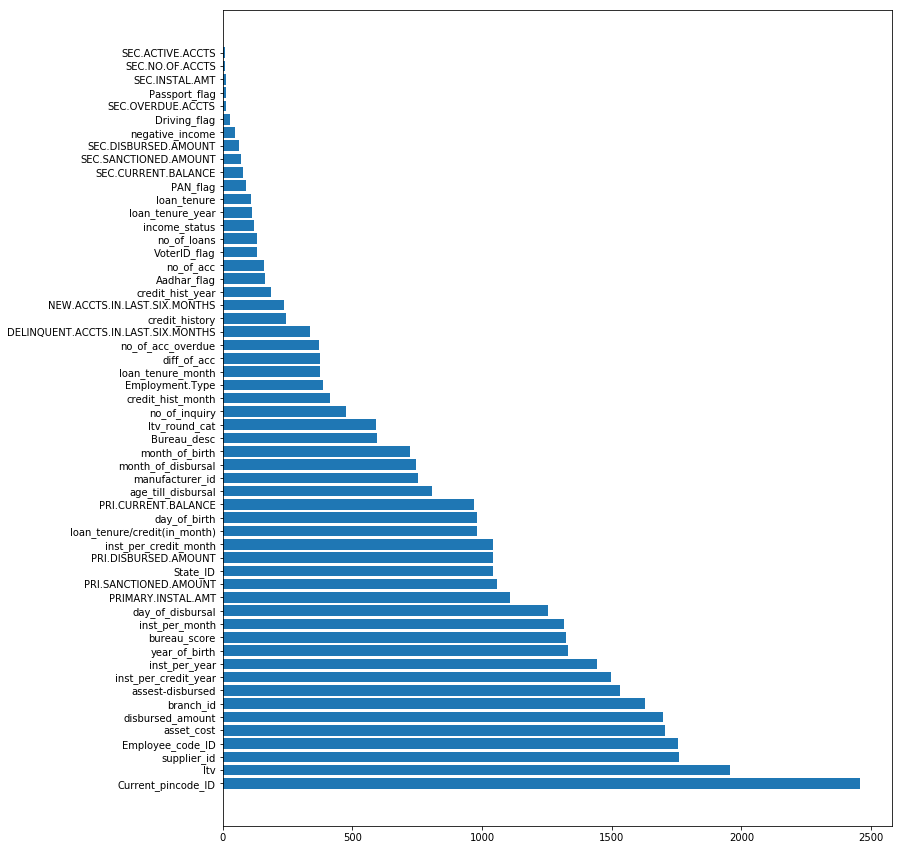

In [401]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline1'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=200, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [402]:
!ls submission/

check.zip  lightgbm_target_baseline1.csv  lightgbm_target_baseline.csv


In [403]:
!zip submission/lightgbm_target_baseline1.zip submission/lightgbm_target_baseline1.csv

  adding: submission/lightgbm_target_baseline1.csv (deflated 54%)


In [404]:
del train_df, test_df
train_df = train_df_save2.copy()
test_df  = test_df_save2.copy()


In [440]:
del branch_gps, state_gps, manufac_gps
gc.collect()

6463

In [469]:
print("check status: ", len(set(train_df['branch_id']).intersection(
    set(test_df['branch_id']))), \
    len(set(test_df['branch_id'])), len(set(train_df['branch_id'])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby(['branch_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['branch_id','branch_asset_amt_mean','branch_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on='branch_id', how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby(['branch_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['branch_id','branch_asset_amt_mean','branch_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on='branch_id', how='left')
print("After", test_df.shape)

check status:  82 82 82
Before:  (224607, 58)
After (224607, 60)
Before:  (112392, 57)
After (112392, 59)


In [483]:
print("check status: ", len(set(train_df['supplier_id']).intersection(
    set(test_df['supplier_id']))), \
    len(set(test_df['supplier_id'])), len(set(train_df['supplier_id'])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby(['supplier_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['supplier_id','supplier_asset_amt_mean','supplier_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on='supplier_id', how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby(['supplier_id'])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = ['supplier_id','supplier_asset_amt_mean','supplier_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on='supplier_id', how='left')
print("After", test_df.shape)

check status:  2725 2863 2946


/home/ankish/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Before:  (224607, 60)
After (224607, 62)
Before:  (112392, 59)
After (112392, 61)


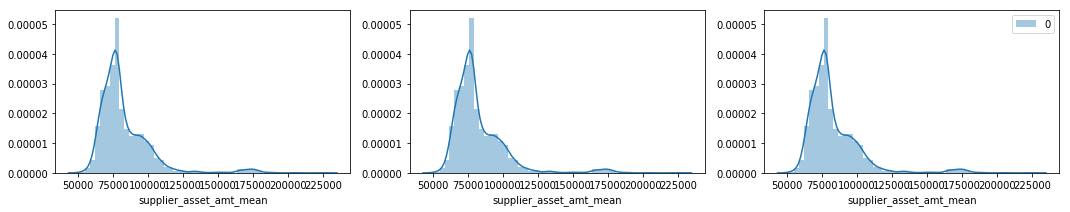

In [484]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp['supplier_asset_amt_mean'].fillna(
    branch_gp['supplier_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp['supplier_asset_amt_mean'].fillna(
    branch_gp['supplier_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp['supplier_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [488]:
col = 'manufacturer_id'
half_col = 'manufacturer'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  10 11 11
Before:  (224607, 62)


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


After (224607, 64)
Before:  (112392, 61)
After (112392, 63)


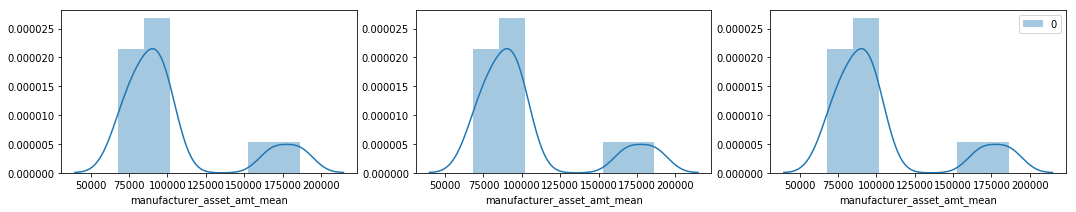

In [489]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [491]:
col = 'State_ID'
half_col = 'State'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  22 22 22
Before:  (224607, 64)
After (224607, 66)
Before:  (112392, 63)
After (112392, 65)


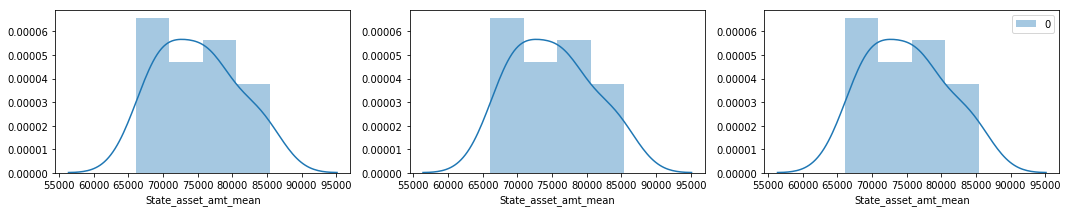

In [492]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

check status:  5766 6202 6601


In [494]:
col = 'Employee_code_ID'
half_col = 'Employee'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  3014 3143 3268


/home/ankish/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Before:  (224607, 66)
After (224607, 68)
Before:  (112392, 65)
After (112392, 67)


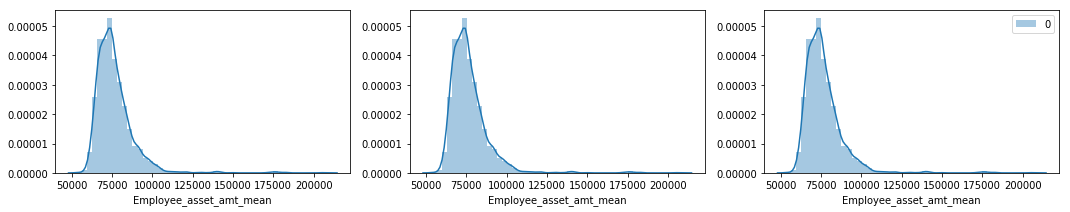

In [495]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [497]:
col = 'Current_pincode_ID'
half_col = 'Pincode'

print("check status: ", len(set(train_df[col]).intersection(set(test_df[col]))), \
    len(set(test_df[col])), len(set(train_df[col])))

def get_mean(data):
    return data[(np.abs(stats.zscore(data)) < 3).all(axis=1)].mean()

branch_gp = train_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", train_df.shape)
train_df = pd.merge(train_df, branch_gp, on=col, how='left')
print("After", train_df.shape)

branch_gp = test_df.groupby([col])['asset_cost','disbursed_amount'].apply(get_mean)
branch_gp = pd.DataFrame(data=[list(branch_gp.index), 
                               list(branch_gp.values[:,0]), 
                               list(branch_gp.values[:,1])]).T
branch_gp.columns = [col,half_col+'_asset_amt_mean',half_col+'_disbursed_amt_mean']
branch_gp.fillna(branch_gp.median(), inplace=True)

print("Before: ", test_df.shape)
test_df = pd.merge(test_df, branch_gp, on=col, how='left')
print("After", test_df.shape)

check status:  5766 6202 6601


/home/ankish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


Before:  (224607, 68)
After (224607, 70)
Before:  (112392, 67)
After (112392, 69)


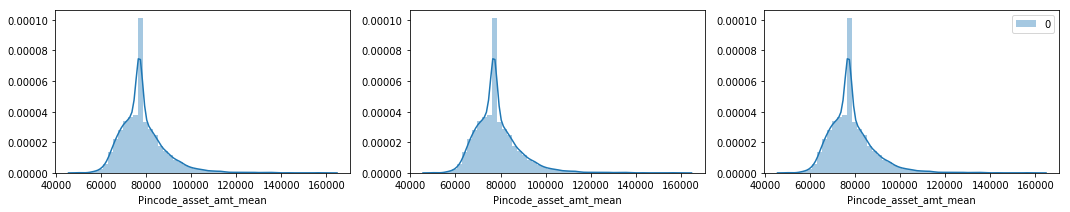

In [498]:
fig, ax = plt.subplots(1,3,figsize=(18,3))
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].mean()), ax=ax[0], label='mean')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(
    branch_gp[half_col+'_asset_amt_mean'].median()), ax=ax[1], label='median')
sns.distplot(branch_gp[half_col+'_asset_amt_mean'].fillna(0), ax=ax[2], label='0')
plt.legend()

In [499]:
train_df_save2 = train_df.copy()
test_df_save2  = test_df.copy()

train_df.drop(['UniqueID','loan_default'], axis=1, inplace=True)
test_df.drop('UniqueID', axis=1, inplace=True)

train_df.reset_index(drop=True, inplace=True)
target = train_df_save2.loan_default
test_id = test_df_save2.UniqueID

train_df_save2.shape, train_df.shape

((224607, 70), (224607, 68))

(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664969	valid_1's auc: 0.654364
[400]	training's auc: 0.678074	valid_1's auc: 0.663229
[600]	training's auc: 0.687379	valid_1's auc: 0.667844
[800]	training's auc: 0.694686	valid_1's auc: 0.670587
[1000]	training's auc: 0.701048	valid_1's auc: 0.672158
[1200]	training's auc: 0.706892	valid_1's auc: 0.673335
[1400]	training's auc: 0.712329	valid_1's auc: 0.674078
[1600]	training's auc: 0.717554	valid_1's auc: 0.674611
Early stopping, best iteration is:
[1710]	training's auc: 0.720367	valid_1's auc: 0.674995
  auc =  0.6749945388719458
(168455,) (56152,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664653	valid_1's auc: 0.656581
[400]	training's auc: 0.67772	valid_1's auc: 0.664912
[600]	training's auc: 0.687251	valid_1's auc: 0.66943
[800]	training's auc: 0.694569	valid_1's auc: 0.671929
[1000]	training's auc: 0.701071	valid_1's a

<BarContainer object of 68 artists>

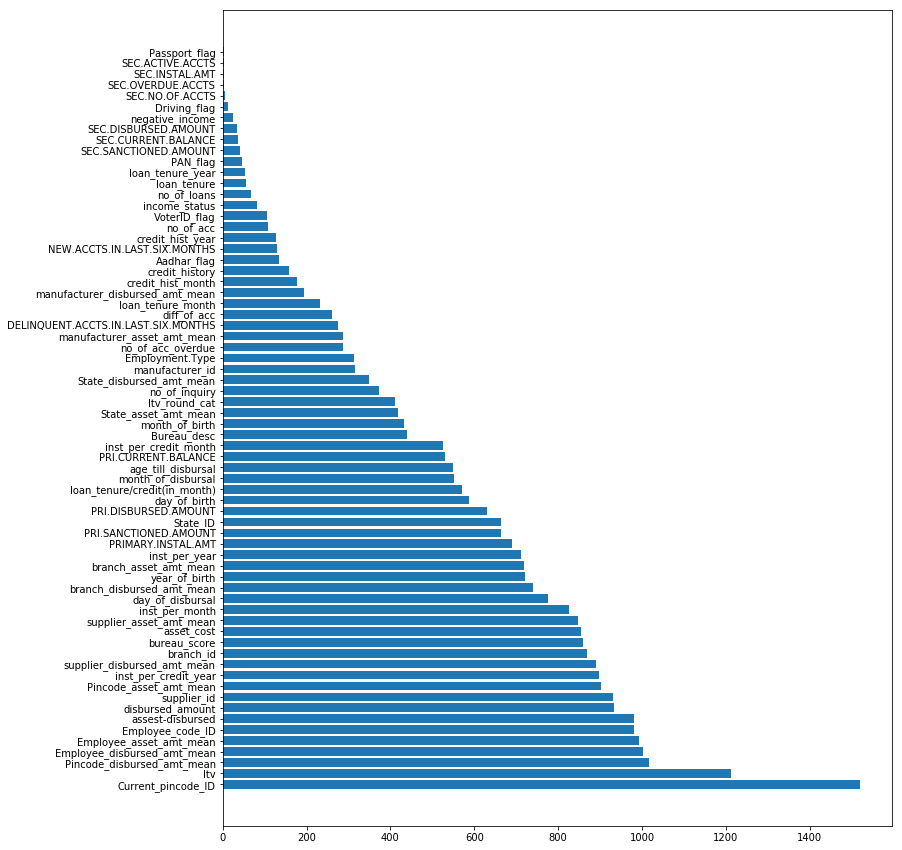

In [500]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline2'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=200, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [501]:
!zip submission/lightgbm_target_baseline2.zip submission/lightgbm_target_baseline2.csv

  adding: submission/lightgbm_target_baseline2.csv (deflated 54%)


In [502]:
train_df.drop(['Current_pincode_ID','Employee_code_ID','supplier_id'], axis=1, inplace=True)
test_df.drop(['Current_pincode_ID','Employee_code_ID','supplier_id'], axis=1, inplace=True)


(168455,) (56152,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.662914	valid_1's auc: 0.652765
[400]	training's auc: 0.676361	valid_1's auc: 0.661829
[600]	training's auc: 0.685285	valid_1's auc: 0.666189
[800]	training's auc: 0.69236	valid_1's auc: 0.668699
[1000]	training's auc: 0.698597	valid_1's auc: 0.670331
[1200]	training's auc: 0.704315	valid_1's auc: 0.671337
[1400]	training's auc: 0.709611	valid_1's auc: 0.672051
[1600]	training's auc: 0.714717	valid_1's auc: 0.672719
Early stopping, best iteration is:
[1642]	training's auc: 0.715787	valid_1's auc: 0.672846
  auc =  0.6728462858449251
(168455,) (56152,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.662134	valid_1's auc: 0.654462
[400]	training's auc: 0.675403	valid_1's auc: 0.663477
[600]	training's auc: 0.684809	valid_1's auc: 0.668085
[800]	training's auc: 0.692212	valid_1's auc: 0.670704
[1000]	training's auc: 0.698546	valid_1's 

<BarContainer object of 65 artists>

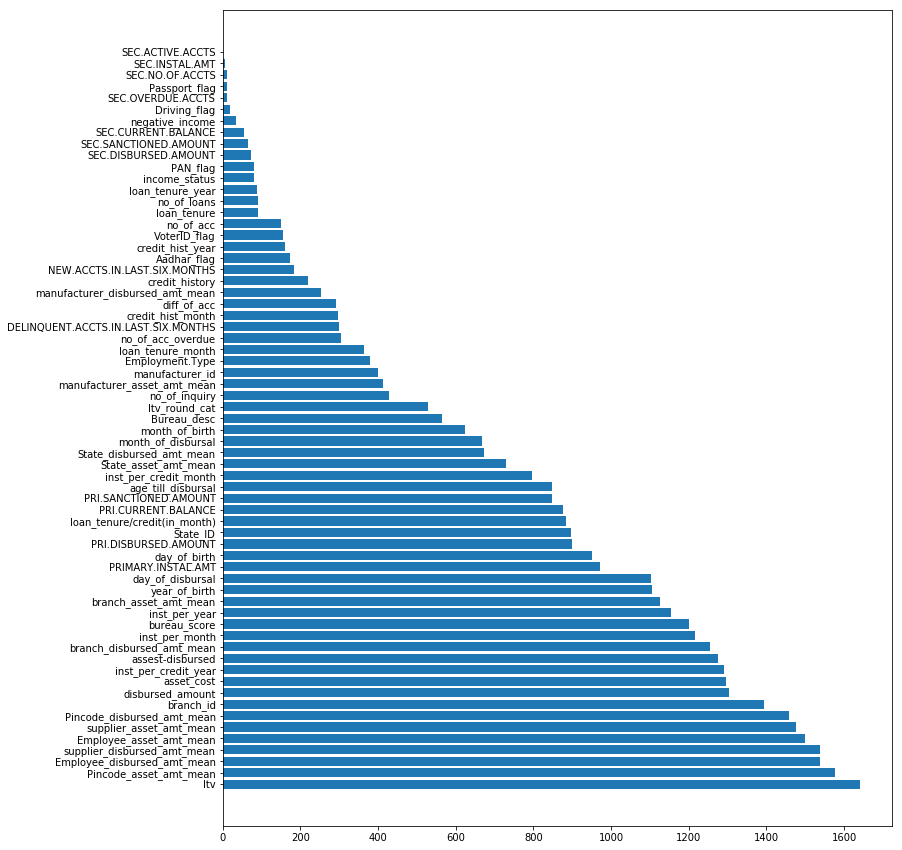

In [503]:

from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

file_path = 'baseline3'
splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.05
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=200, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)
    
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

sub_df = pd.DataFrame({"ID_code":test_id})
sub_df["target"] = predictions

sub_df.columns = sub.columns
sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

In [504]:
!zip submission/lightgbm_target_baseline3.zip submission/lightgbm_target_baseline3.csv

  adding: submission/lightgbm_target_baseline3.csv (deflated 54%)
